In [ ]:
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from resnet import resnet32x4

ModuleNotFoundError: No module named 'torchsummary'

In [3]:
# Transforms the images (Normalized them)
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding = 4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(), 
     transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

test_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

batch_size = 128

train_set = torchvision.datasets.CIFAR100(root = './data', 
                                         train = True,
                                         download = True, 
                                         transform = train_transform)
                                         
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size = batch_size,
                                           shuffle = True, 
                                           num_workers = 2)

test_set = torchvision.datasets.CIFAR100(root = './data', 
                                        train = False,
                                        download = True, 
                                        transform = test_transform)

test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size = batch_size,
                                          shuffle = False, 
                                          num_workers = 2)

classes = train_set.classes
num_classes = 100

100%|████████████████████████████████████████| 169M/169M [00:04<00:00, 34.4MB/s]


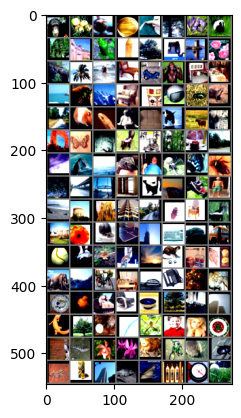

chimpanzee apple flatfish bowl 


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)  # clamp to valid range
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [4]:
# Create convolutional neural netwrok, student1
class Student1(nn.Module):
    # The constructor for the class
    def __init__(self):
        super().__init__()
        
        self.feature_extractor = nn.Sequential(

            # First convoluational layer, 3 input channels, 32 output channels
            nn.Conv2d(3, 32, kernel_size = (5, 5), padding = 2),
            nn.ReLU(),

            # Second convoluational layer, 32 input channels, 64 output channels
            nn.Conv2d(32, 64, kernel_size = (3, 3), stride = 2, padding = 1),
            nn.MaxPool2d(2, 2),

            # Third convoluational layer, 64 input channels, 128 output channels
            nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 2, padding = 1),
            nn.ReLU(),
        
            # Fourth convoluational layer, 128 input channels, 256 output channels
            nn.Conv2d(128, 256, kernel_size = (3, 3), stride = 1, padding = 1),
            nn.ReLU(),
        
        )
        # flatten the C256, H4, W4
        self.linear = nn.Linear(in_features = 256 * 4 * 4, out_features = 100)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        logits = self.linear(x)
        return logits


In [5]:
# Train without teacher
def training_without_teacher(dataloader, model, criterion, optimizer, device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()

    model = model.to(device)
    
    all_losses = []
    for batch_idx, (X, y) in enumerate(tqdm(dataloader, total = len(dataloader))):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        logits = model(X) # Shape: (batch_size, num_classes)
        pred = torch.argmax(logits, dim = 1)
        loss = criterion(logits, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss, current = loss.item(), batch_idx * batch_size + len(X)
        all_losses.append(loss)
        if batch_idx % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print(f"Accuracy: {torch.mean((pred == y).float())*100}")
    return all_losses

In [6]:
# Test evaluation
def testing(dataloader, model, num_classes, device=torch.device("cpu")):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    model = model.to(device)
    correct = 0
    total = 0

    all_probabilities = []
    all_labels = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for X, y in tqdm(dataloader, total = len(dataloader)):
            X = X.to(device)
            y = y.to(device)
            logits = model(X) # Shape: (batch_size, num_classes)

            # For accuracy
            pred = torch.argmax(logits, dim = 1)
            correct += torch.sum(pred == y)
            total += len(y)

            # For AUC
            prob = F.softmax(logits, dim = 1) # Convert logits to probabilities, shape: (batch_size, num_classes)
            all_probabilities.append(prob)
            all_labels.append(y)

    # Accuracy
    accuracy = correct.item() / total * 100

    # AUC
    # Concatenate all collected tensors and convert to NumPy arrays
    y_score = torch.cat(all_probabilities).cpu().numpy()
    y_true = torch.cat(all_labels).cpu().numpy()

    # Binarize labels for One-vs-Rest AUC calculation
    lb = LabelBinarizer()
    # One-hot coding of all classes
    y_true_binarized = lb.fit_transform(y_true)

    # Calculate One-vs-Rest ROC AUC score
    # 'macro' average calculates AUC for each class and then takes the unweighted average
    ovr_auc = roc_auc_score(y_true_binarized, 
                            y_score, 
                            multi_class = 'ovr', 
                            average = 'macro', 
                            labels = range(num_classes))
    
    return accuracy, ovr_auc

In [8]:
epochs = 100
num_runs = 5
lr = 0.1
lr_min = 1e-5
weight_decay=0.0005
device = torch.device("mps")


--- Run 1/5 ---
Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 100]         409,700
Total params: 799,652
Trainable params: 799,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.75
Params size (MB): 3.05
Estimated Total Size (MB): 3.81
------

  3%|██▋                                                                                             | 11/391 [00:05<02:29,  2.54it/s]

loss: 4.605535  [  128/50000]
Accuracy: 0.0


 32%|██████████████████████████████▏                                                                | 124/391 [00:06<00:03, 82.21it/s]

loss: 4.473734  [12928/50000]
Accuracy: 2.34375


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:07<00:01, 117.82it/s]

loss: 4.179902  [25728/50000]
Accuracy: 3.90625


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:08<00:00, 119.64it/s]

loss: 3.948373  [38528/50000]
Accuracy: 10.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.45it/s]


Epoch 2
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:24,  2.62it/s]

loss: 3.858227  [  128/50000]
Accuracy: 10.15625


 30%|████████████████████████████▉                                                                  | 119/391 [00:06<00:03, 78.83it/s]

loss: 3.764584  [12928/50000]
Accuracy: 11.71875


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:07<00:01, 118.82it/s]

loss: 3.487896  [25728/50000]
Accuracy: 20.3125


 80%|███████████████████████████████████████████████████████████████████████████                   | 312/391 [00:08<00:00, 119.74it/s]

loss: 3.581767  [38528/50000]
Accuracy: 19.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.64it/s]


Epoch 3
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:28,  2.56it/s]

loss: 3.629878  [  128/50000]
Accuracy: 15.625


 30%|████████████████████████████▏                                                                  | 116/391 [00:06<00:03, 72.94it/s]

loss: 3.728341  [12928/50000]
Accuracy: 17.1875


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:07<00:01, 112.88it/s]

loss: 3.306453  [25728/50000]
Accuracy: 23.4375


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 313/391 [00:08<00:00, 117.23it/s]

loss: 3.192036  [38528/50000]
Accuracy: 22.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.48it/s]


Epoch 4
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:24,  2.64it/s]

loss: 3.289291  [  128/50000]
Accuracy: 21.09375


 29%|███████████████████████████▍                                                                   | 113/391 [00:06<00:03, 70.64it/s]

loss: 3.272790  [12928/50000]
Accuracy: 17.96875


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:07<00:01, 115.22it/s]

loss: 2.811404  [25728/50000]
Accuracy: 29.6875


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:08<00:00, 128.17it/s]

loss: 3.021276  [38528/50000]
Accuracy: 29.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.84it/s]


Epoch 5
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:22,  2.66it/s]

loss: 2.903161  [  128/50000]
Accuracy: 28.90625


 30%|████████████████████████████▍                                                                  | 117/391 [00:06<00:03, 76.04it/s]

loss: 2.981521  [12928/50000]
Accuracy: 26.5625


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:07<00:01, 115.05it/s]

loss: 2.773618  [25728/50000]
Accuracy: 29.6875


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:08<00:00, 120.72it/s]

loss: 2.966812  [38528/50000]
Accuracy: 32.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.78it/s]


Epoch 6
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:17,  2.77it/s]

loss: 2.848561  [  128/50000]
Accuracy: 30.46875


 31%|█████████████████████████████▍                                                                 | 121/391 [00:06<00:03, 82.42it/s]

loss: 2.838026  [12928/50000]
Accuracy: 28.90625


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:07<00:01, 114.83it/s]

loss: 3.060002  [25728/50000]
Accuracy: 24.21875


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 313/391 [00:07<00:00, 123.46it/s]

loss: 2.775356  [38528/50000]
Accuracy: 28.90625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.02it/s]


Epoch 7
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:21,  2.69it/s]

loss: 2.834491  [  128/50000]
Accuracy: 29.6875


 29%|███████████████████████████▍                                                                   | 113/391 [00:06<00:03, 71.75it/s]

loss: 2.618349  [12928/50000]
Accuracy: 32.8125


 56%|████████████████████████████████████████████████████▋                                         | 219/391 [00:07<00:01, 114.88it/s]

loss: 2.624424  [25728/50000]
Accuracy: 39.84375


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 117.46it/s]

loss: 2.605001  [38528/50000]
Accuracy: 30.46875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.82it/s]


Epoch 8
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:20,  2.71it/s]

loss: 2.648691  [  128/50000]
Accuracy: 35.9375


 32%|██████████████████████████████▎                                                                | 125/391 [00:06<00:03, 84.62it/s]

loss: 2.615031  [12928/50000]
Accuracy: 35.9375


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:07<00:01, 114.73it/s]

loss: 2.469133  [25728/50000]
Accuracy: 40.625


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:08<00:00, 118.97it/s]

loss: 2.605675  [38528/50000]
Accuracy: 28.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.93it/s]


Epoch 9
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:24,  2.62it/s]

loss: 2.650161  [  128/50000]
Accuracy: 28.90625


 31%|█████████████████████████████▍                                                                 | 121/391 [00:06<00:03, 79.96it/s]

loss: 2.661345  [12928/50000]
Accuracy: 33.59375


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:07<00:01, 113.85it/s]

loss: 2.481635  [25728/50000]
Accuracy: 32.8125


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:08<00:00, 116.96it/s]

loss: 2.643149  [38528/50000]
Accuracy: 30.46875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.58it/s]


Epoch 10
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:20,  2.70it/s]

loss: 2.238795  [  128/50000]
Accuracy: 39.84375


 31%|█████████████████████████████▍                                                                 | 121/391 [00:06<00:03, 80.88it/s]

loss: 2.395334  [12928/50000]
Accuracy: 42.1875


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:07<00:01, 120.83it/s]

loss: 2.139690  [25728/50000]
Accuracy: 42.96875


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:08<00:00, 118.86it/s]

loss: 2.741333  [38528/50000]
Accuracy: 33.59375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.86it/s]


Epoch 11
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:25,  2.61it/s]

loss: 2.054207  [  128/50000]
Accuracy: 42.96875


 30%|████████████████████████████▉                                                                  | 119/391 [00:06<00:03, 76.68it/s]

loss: 2.209130  [12928/50000]
Accuracy: 46.875


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:07<00:01, 114.12it/s]

loss: 2.322395  [25728/50000]
Accuracy: 45.3125


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:08<00:00, 118.02it/s]

loss: 2.538422  [38528/50000]
Accuracy: 35.15625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.53it/s]


Epoch 12
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:17,  2.76it/s]

loss: 2.266274  [  128/50000]
Accuracy: 39.0625


 32%|██████████████████████████████▏                                                                | 124/391 [00:06<00:03, 82.76it/s]

loss: 2.288136  [12928/50000]
Accuracy: 43.75


 58%|██████████████████████████████████████████████████████▊                                       | 228/391 [00:07<00:01, 128.62it/s]

loss: 2.003090  [25728/50000]
Accuracy: 47.65625


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:08<00:00, 119.58it/s]

loss: 2.035070  [38528/50000]
Accuracy: 46.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.03it/s]


Epoch 13
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:23,  2.65it/s]

loss: 2.218750  [  128/50000]
Accuracy: 37.5


 33%|███████████████████████████████                                                                | 128/391 [00:06<00:02, 90.93it/s]

loss: 1.767264  [12928/50000]
Accuracy: 44.53125


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:07<00:01, 121.74it/s]

loss: 2.326834  [25728/50000]
Accuracy: 40.625


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:08<00:00, 120.06it/s]

loss: 1.926927  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.83it/s]


Epoch 14
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:26,  2.59it/s]

loss: 2.004695  [  128/50000]
Accuracy: 48.4375


 29%|███████████████████████████▍                                                                   | 113/391 [00:06<00:03, 70.55it/s]

loss: 2.056399  [12928/50000]
Accuracy: 47.65625


 54%|███████████████████████████████████████████████████▏                                          | 213/391 [00:07<00:01, 119.21it/s]

loss: 2.106384  [25728/50000]
Accuracy: 40.625


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 124.60it/s]

loss: 2.192907  [38528/50000]
Accuracy: 45.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.64it/s]


Epoch 15
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:25,  2.61it/s]

loss: 1.960424  [  128/50000]
Accuracy: 47.65625


 31%|█████████████████████████████▍                                                                 | 121/391 [00:06<00:03, 81.32it/s]

loss: 1.738642  [12928/50000]
Accuracy: 53.125


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:07<00:01, 118.47it/s]

loss: 2.338308  [25728/50000]
Accuracy: 43.75


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 118.04it/s]

loss: 2.256009  [38528/50000]
Accuracy: 42.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.60it/s]


Epoch 16
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:24,  2.63it/s]

loss: 1.988560  [  128/50000]
Accuracy: 49.21875


 30%|████████████████████████████▍                                                                  | 117/391 [00:06<00:03, 76.43it/s]

loss: 1.957580  [12928/50000]
Accuracy: 46.875


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:07<00:01, 117.24it/s]

loss: 1.830317  [25728/50000]
Accuracy: 48.4375


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:08<00:00, 118.40it/s]

loss: 2.346447  [38528/50000]
Accuracy: 36.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.72it/s]


Epoch 17
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:21,  2.68it/s]

loss: 1.935732  [  128/50000]
Accuracy: 52.34375


 31%|█████████████████████████████▋                                                                 | 122/391 [00:06<00:03, 80.87it/s]

loss: 1.951163  [12928/50000]
Accuracy: 46.09375


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:07<00:01, 122.64it/s]

loss: 2.031134  [25728/50000]
Accuracy: 42.96875


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:08<00:00, 122.03it/s]

loss: 1.583875  [38528/50000]
Accuracy: 55.46875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.81it/s]


Epoch 18
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:24,  2.62it/s]

loss: 2.236544  [  128/50000]
Accuracy: 42.1875


 31%|█████████████████████████████▍                                                                 | 121/391 [00:06<00:03, 83.08it/s]

loss: 1.939564  [12928/50000]
Accuracy: 46.875


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:07<00:01, 117.52it/s]

loss: 2.079187  [25728/50000]
Accuracy: 41.40625


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:08<00:00, 115.99it/s]

loss: 2.086073  [38528/50000]
Accuracy: 43.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.71it/s]


Epoch 19
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:20,  2.70it/s]

loss: 2.013402  [  128/50000]
Accuracy: 46.09375


 30%|████████████████████████████▍                                                                  | 117/391 [00:06<00:03, 75.04it/s]

loss: 2.021897  [12928/50000]
Accuracy: 42.96875


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:07<00:01, 113.06it/s]

loss: 1.747219  [25728/50000]
Accuracy: 53.125


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:08<00:00, 118.48it/s]

loss: 1.868722  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.84it/s]


Epoch 20
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:20,  2.71it/s]

loss: 1.646023  [  128/50000]
Accuracy: 54.6875


 31%|█████████████████████████████▏                                                                 | 120/391 [00:06<00:03, 80.98it/s]

loss: 2.074762  [12928/50000]
Accuracy: 49.21875


 58%|██████████████████████████████████████████████████████▊                                       | 228/391 [00:07<00:01, 130.22it/s]

loss: 1.979838  [25728/50000]
Accuracy: 53.125


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 121.52it/s]

loss: 1.905283  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.91it/s]


Epoch 21
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:25,  2.61it/s]

loss: 1.787896  [  128/50000]
Accuracy: 50.78125


 31%|█████████████████████████████▍                                                                 | 121/391 [00:06<00:03, 80.57it/s]

loss: 1.594792  [12928/50000]
Accuracy: 54.6875


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:07<00:01, 114.66it/s]

loss: 1.922266  [25728/50000]
Accuracy: 53.125


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:08<00:00, 116.84it/s]

loss: 2.021720  [38528/50000]
Accuracy: 46.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.55it/s]


Epoch 22
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:15,  2.80it/s]

loss: 1.767806  [  128/50000]
Accuracy: 47.65625


 30%|████████████████████████████▋                                                                  | 118/391 [00:06<00:03, 75.95it/s]

loss: 1.646819  [12928/50000]
Accuracy: 55.46875


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:07<00:01, 113.45it/s]

loss: 1.679578  [25728/50000]
Accuracy: 50.0


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:07<00:00, 119.02it/s]

loss: 2.039613  [38528/50000]
Accuracy: 46.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.08it/s]


Epoch 23
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:19,  2.72it/s]

loss: 1.749774  [  128/50000]
Accuracy: 51.5625


 31%|█████████████████████████████▍                                                                 | 121/391 [00:06<00:03, 83.41it/s]

loss: 1.846331  [12928/50000]
Accuracy: 47.65625


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:07<00:01, 123.31it/s]

loss: 1.666027  [25728/50000]
Accuracy: 53.90625


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 119.21it/s]

loss: 2.014430  [38528/50000]
Accuracy: 50.78125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.86it/s]


Epoch 24
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:11,  2.88it/s]

loss: 1.832280  [  128/50000]
Accuracy: 50.78125


 31%|█████████████████████████████▋                                                                 | 122/391 [00:06<00:03, 81.88it/s]

loss: 1.603989  [12928/50000]
Accuracy: 55.46875


 56%|████████████████████████████████████████████████████▋                                         | 219/391 [00:07<00:01, 115.34it/s]

loss: 1.533892  [25728/50000]
Accuracy: 56.25


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:07<00:00, 117.22it/s]

loss: 1.694009  [38528/50000]
Accuracy: 54.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.18it/s]


Epoch 25
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:15,  2.79it/s]

loss: 1.501981  [  128/50000]
Accuracy: 60.15625


 29%|███████████████████████████▏                                                                   | 112/391 [00:06<00:03, 74.53it/s]

loss: 1.770647  [12928/50000]
Accuracy: 56.25


 54%|███████████████████████████████████████████████████▏                                          | 213/391 [00:07<00:01, 113.83it/s]

loss: 1.616349  [25728/50000]
Accuracy: 56.25


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 313/391 [00:07<00:00, 118.74it/s]

loss: 1.845555  [38528/50000]
Accuracy: 46.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.03it/s]


Epoch 26
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:07,  2.99it/s]

loss: 1.507808  [  128/50000]
Accuracy: 56.25


 30%|████████████████████████████▋                                                                  | 118/391 [00:05<00:03, 86.42it/s]

loss: 1.392076  [12928/50000]
Accuracy: 59.375


 54%|███████████████████████████████████████████████████▏                                          | 213/391 [00:06<00:01, 115.61it/s]

loss: 1.368349  [25728/50000]
Accuracy: 64.0625


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:07<00:00, 119.91it/s]

loss: 1.606580  [38528/50000]
Accuracy: 55.46875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.53it/s]


Epoch 27
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:23,  2.65it/s]

loss: 1.550233  [  128/50000]
Accuracy: 59.375


 31%|█████████████████████████████▋                                                                 | 122/391 [00:06<00:03, 80.79it/s]

loss: 1.471128  [12928/50000]
Accuracy: 60.15625


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:07<00:01, 119.59it/s]

loss: 1.833655  [25728/50000]
Accuracy: 51.5625


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:08<00:00, 119.05it/s]

loss: 1.446953  [38528/50000]
Accuracy: 60.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.73it/s]


Epoch 28
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:20,  2.71it/s]

loss: 1.489621  [  128/50000]
Accuracy: 61.71875


 31%|█████████████████████████████▏                                                                 | 120/391 [00:06<00:03, 80.74it/s]

loss: 1.536136  [12928/50000]
Accuracy: 64.0625


 54%|███████████████████████████████████████████████████▏                                          | 213/391 [00:07<00:01, 121.51it/s]

loss: 1.583360  [25728/50000]
Accuracy: 54.6875


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 119.23it/s]

loss: 1.791554  [38528/50000]
Accuracy: 52.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.83it/s]


Epoch 29
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:12,  2.87it/s]

loss: 1.410293  [  128/50000]
Accuracy: 57.8125


 31%|█████████████████████████████▋                                                                 | 122/391 [00:06<00:03, 83.10it/s]

loss: 1.552730  [12928/50000]
Accuracy: 55.46875


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:07<00:01, 118.57it/s]

loss: 1.673403  [25728/50000]
Accuracy: 53.125


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:07<00:00, 119.86it/s]

loss: 1.675065  [38528/50000]
Accuracy: 54.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.22it/s]


Epoch 30
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:15,  2.80it/s]

loss: 1.267148  [  128/50000]
Accuracy: 63.28125


 30%|████████████████████████████▋                                                                  | 118/391 [00:06<00:03, 78.36it/s]

loss: 1.434844  [12928/50000]
Accuracy: 60.15625


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:07<00:01, 114.44it/s]

loss: 1.724361  [25728/50000]
Accuracy: 54.6875


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:07<00:00, 119.98it/s]

loss: 1.660339  [38528/50000]
Accuracy: 56.25


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.06it/s]


Epoch 31
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:19,  2.73it/s]

loss: 1.364924  [  128/50000]
Accuracy: 57.8125


 32%|██████████████████████████████▏                                                                | 124/391 [00:06<00:03, 82.46it/s]

loss: 1.268576  [12928/50000]
Accuracy: 66.40625


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:07<00:01, 115.07it/s]

loss: 1.491047  [25728/50000]
Accuracy: 58.59375


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:08<00:00, 117.78it/s]

loss: 1.378659  [38528/50000]
Accuracy: 62.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.84it/s]


Epoch 32
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:19,  2.73it/s]

loss: 1.044970  [  128/50000]
Accuracy: 75.78125


 32%|██████████████████████████████▏                                                                | 124/391 [00:06<00:03, 81.43it/s]

loss: 1.070176  [12928/50000]
Accuracy: 69.53125


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:07<00:01, 115.69it/s]

loss: 1.018872  [25728/50000]
Accuracy: 66.40625


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:08<00:00, 118.30it/s]

loss: 1.064796  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.91it/s]


Epoch 33
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:12,  2.86it/s]

loss: 0.961572  [  128/50000]
Accuracy: 75.78125


 31%|█████████████████████████████▏                                                                 | 120/391 [00:06<00:03, 81.79it/s]

loss: 0.986504  [12928/50000]
Accuracy: 69.53125


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:07<00:01, 116.04it/s]

loss: 0.944628  [25728/50000]
Accuracy: 70.3125


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:07<00:00, 118.07it/s]

loss: 1.091352  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.14it/s]


Epoch 34
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.26it/s]

loss: 0.928179  [  128/50000]
Accuracy: 72.65625


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 70.90it/s]

loss: 0.970524  [12928/50000]
Accuracy: 72.65625


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 122.99it/s]

loss: 1.156165  [25728/50000]
Accuracy: 71.09375


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 313/391 [00:09<00:00, 129.75it/s]

loss: 1.286473  [38528/50000]
Accuracy: 60.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.90it/s]


Epoch 35
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 0.853380  [  128/50000]
Accuracy: 76.5625


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 70.68it/s]

loss: 0.956364  [12928/50000]
Accuracy: 77.34375


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 125.73it/s]

loss: 1.269253  [25728/50000]
Accuracy: 68.75


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 133.51it/s]

loss: 1.090380  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.04it/s]


Epoch 36
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.33it/s]

loss: 1.185125  [  128/50000]
Accuracy: 65.625


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 73.63it/s]

loss: 1.039782  [12928/50000]
Accuracy: 70.3125


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:08<00:01, 121.20it/s]

loss: 1.283980  [25728/50000]
Accuracy: 64.0625


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:08<00:00, 132.70it/s]

loss: 1.212987  [38528/50000]
Accuracy: 63.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.05it/s]


Epoch 37
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:37,  2.42it/s]

loss: 1.075092  [  128/50000]
Accuracy: 71.875


 32%|██████████████████████████████▊                                                                | 127/391 [00:07<00:03, 76.74it/s]

loss: 0.909022  [12928/50000]
Accuracy: 71.875


 56%|████████████████████████████████████████████████████▋                                         | 219/391 [00:07<00:01, 119.74it/s]

loss: 1.381381  [25728/50000]
Accuracy: 58.59375


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:08<00:00, 123.81it/s]

loss: 1.123461  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.33it/s]


Epoch 38
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:55,  2.17it/s]

loss: 1.055755  [  128/50000]
Accuracy: 66.40625


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 73.98it/s]

loss: 0.848732  [12928/50000]
Accuracy: 74.21875


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:08<00:01, 119.09it/s]

loss: 1.138545  [25728/50000]
Accuracy: 70.3125


 81%|████████████████████████████████████████████████████████████████████████████▍                 | 318/391 [00:09<00:00, 122.56it/s]

loss: 1.062952  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.59it/s]


Epoch 39
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:38,  2.40it/s]

loss: 0.883402  [  128/50000]
Accuracy: 75.78125


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 75.77it/s]

loss: 0.928633  [12928/50000]
Accuracy: 71.09375


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:07<00:01, 123.77it/s]

loss: 1.116760  [25728/50000]
Accuracy: 67.96875


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:08<00:00, 128.17it/s]

loss: 1.040266  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.32it/s]


Epoch 40
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 1.058107  [  128/50000]
Accuracy: 65.625


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:03, 71.06it/s]

loss: 0.759764  [12928/50000]
Accuracy: 73.4375


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 121.03it/s]

loss: 0.992434  [25728/50000]
Accuracy: 69.53125


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:09<00:00, 122.37it/s]

loss: 0.980950  [38528/50000]
Accuracy: 74.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.88it/s]


Epoch 41
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:39,  2.38it/s]

loss: 1.210702  [  128/50000]
Accuracy: 67.1875


 32%|██████████████████████████████▌                                                                | 126/391 [00:07<00:03, 82.32it/s]

loss: 1.031451  [12928/50000]
Accuracy: 71.875


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:07<00:01, 134.66it/s]

loss: 0.837102  [25728/50000]
Accuracy: 72.65625


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:08<00:00, 136.26it/s]

loss: 1.159348  [38528/50000]
Accuracy: 65.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.33it/s]


Epoch 42
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:58,  2.13it/s]

loss: 1.074028  [  128/50000]
Accuracy: 67.1875


 31%|█████████████████████████████▏                                                                 | 120/391 [00:07<00:03, 70.54it/s]

loss: 0.828702  [12928/50000]
Accuracy: 71.875


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:08<00:01, 123.43it/s]

loss: 1.013759  [25728/50000]
Accuracy: 69.53125


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:09<00:00, 129.81it/s]

loss: 1.185685  [38528/50000]
Accuracy: 65.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.52it/s]


Epoch 43
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:56,  2.16it/s]

loss: 0.832399  [  128/50000]
Accuracy: 74.21875


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 70.22it/s]

loss: 1.027528  [12928/50000]
Accuracy: 71.875


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:08<00:01, 132.09it/s]

loss: 0.910295  [25728/50000]
Accuracy: 71.875


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:09<00:00, 134.57it/s]

loss: 1.038869  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.67it/s]


Epoch 44
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.33it/s]

loss: 0.950168  [  128/50000]
Accuracy: 73.4375


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:03, 70.85it/s]

loss: 0.832798  [12928/50000]
Accuracy: 73.4375


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 126.20it/s]

loss: 0.807581  [25728/50000]
Accuracy: 78.90625


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 139.37it/s]

loss: 1.022345  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.09it/s]


Epoch 45
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.32it/s]

loss: 0.816045  [  128/50000]
Accuracy: 75.78125


 31%|█████████████████████████████▉                                                                 | 123/391 [00:07<00:03, 78.63it/s]

loss: 0.632726  [12928/50000]
Accuracy: 83.59375


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 114.36it/s]

loss: 0.722743  [25728/50000]
Accuracy: 76.5625


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:08<00:00, 128.91it/s]

loss: 0.993298  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.08it/s]


Epoch 46
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:44,  2.31it/s]

loss: 1.087203  [  128/50000]
Accuracy: 69.53125


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 74.48it/s]

loss: 1.001867  [12928/50000]
Accuracy: 70.3125


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 139.89it/s]

loss: 1.212562  [25728/50000]
Accuracy: 66.40625


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:08<00:00, 135.78it/s]

loss: 1.050132  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.23it/s]


Epoch 47
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.33it/s]

loss: 0.811970  [  128/50000]
Accuracy: 75.0


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 72.30it/s]

loss: 0.899799  [12928/50000]
Accuracy: 75.0


 54%|███████████████████████████████████████████████████▏                                          | 213/391 [00:08<00:01, 118.30it/s]

loss: 0.837780  [25728/50000]
Accuracy: 76.5625


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:08<00:00, 139.36it/s]

loss: 1.065774  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.13it/s]


Epoch 48
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:41,  2.35it/s]

loss: 0.912323  [  128/50000]
Accuracy: 70.3125


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 72.93it/s]

loss: 0.887628  [12928/50000]
Accuracy: 71.09375


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:08<00:01, 122.44it/s]

loss: 0.833286  [25728/50000]
Accuracy: 75.78125


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:08<00:00, 130.24it/s]

loss: 0.952513  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.12it/s]


Epoch 49
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:28,  2.55it/s]

loss: 0.638798  [  128/50000]
Accuracy: 85.9375


 30%|████████████████████████████▍                                                                  | 117/391 [00:06<00:03, 74.37it/s]

loss: 0.918297  [12928/50000]
Accuracy: 73.4375


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:07<00:01, 126.44it/s]

loss: 0.882899  [25728/50000]
Accuracy: 75.0


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:08<00:00, 132.81it/s]

loss: 0.969064  [38528/50000]
Accuracy: 75.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.71it/s]


Epoch 50
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:34,  2.46it/s]

loss: 0.865770  [  128/50000]
Accuracy: 75.0


 30%|████████████████████████████▏                                                                  | 116/391 [00:06<00:03, 74.68it/s]

loss: 0.742447  [12928/50000]
Accuracy: 77.34375


 58%|██████████████████████████████████████████████████████▊                                       | 228/391 [00:07<00:01, 131.72it/s]

loss: 0.873417  [25728/50000]
Accuracy: 70.3125


 84%|██████████████████████████████████████████████████████████████████████████████▊               | 328/391 [00:08<00:00, 138.22it/s]

loss: 0.722271  [38528/50000]
Accuracy: 79.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.48it/s]


Model for run 1 saved to models/without_teaching/student_run_1.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:21<00:00,  3.74it/s]


Run 1 Test Accuracy: 54.04%
Run 1 Test AUC: 0.9692
--------------------------------------------------

--- Run 2/5 ---
Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 100]         409,700
Total params: 799,652
Trainable params: 799,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.

  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.29it/s]

loss: 4.607839  [  128/50000]
Accuracy: 0.0


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 70.63it/s]

loss: 4.391969  [12928/50000]
Accuracy: 3.90625


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 131.27it/s]

loss: 4.073002  [25728/50000]
Accuracy: 7.8125


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 134.63it/s]

loss: 3.944471  [38528/50000]
Accuracy: 11.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.05it/s]


Epoch 2
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:28,  2.56it/s]

loss: 3.890823  [  128/50000]
Accuracy: 10.9375


 29%|███████████████████████████▋                                                                   | 114/391 [00:06<00:03, 74.88it/s]

loss: 3.839873  [12928/50000]
Accuracy: 12.5


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:07<00:01, 133.26it/s]

loss: 3.511151  [25728/50000]
Accuracy: 16.40625


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 128.52it/s]

loss: 3.788833  [38528/50000]
Accuracy: 15.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.76it/s]


Epoch 3
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:38,  2.40it/s]

loss: 3.395745  [  128/50000]
Accuracy: 17.1875


 31%|█████████████████████████████▏                                                                 | 120/391 [00:07<00:03, 77.25it/s]

loss: 3.357191  [12928/50000]
Accuracy: 19.53125


 56%|████████████████████████████████████████████████████▋                                         | 219/391 [00:07<00:01, 131.01it/s]

loss: 3.537789  [25728/50000]
Accuracy: 14.0625


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:08<00:00, 145.27it/s]

loss: 3.443768  [38528/50000]
Accuracy: 14.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.49it/s]


Epoch 4
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.23it/s]

loss: 2.940210  [  128/50000]
Accuracy: 32.8125


 29%|███████████████████████████▍                                                                   | 113/391 [00:07<00:04, 68.61it/s]

loss: 3.123686  [12928/50000]
Accuracy: 18.75


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:08<00:01, 124.04it/s]

loss: 3.264089  [25728/50000]
Accuracy: 21.09375


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:09<00:00, 138.85it/s]

loss: 3.027926  [38528/50000]
Accuracy: 31.25


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.82it/s]


Epoch 5
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:37,  2.41it/s]

loss: 2.786096  [  128/50000]
Accuracy: 31.25


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:03, 71.39it/s]

loss: 2.783812  [12928/50000]
Accuracy: 31.25


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:07<00:01, 130.07it/s]

loss: 2.690822  [25728/50000]
Accuracy: 33.59375


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:08<00:00, 134.17it/s]

loss: 2.549506  [38528/50000]
Accuracy: 35.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.39it/s]


Epoch 6
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:56,  2.15it/s]

loss: 3.301785  [  128/50000]
Accuracy: 22.65625


 29%|███████████████████████████▍                                                                   | 113/391 [00:07<00:04, 66.72it/s]

loss: 2.909029  [12928/50000]
Accuracy: 24.21875


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 124.26it/s]

loss: 2.816934  [25728/50000]
Accuracy: 28.90625


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:09<00:00, 128.09it/s]

loss: 2.744143  [38528/50000]
Accuracy: 28.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.52it/s]


Epoch 7
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:56,  2.15it/s]

loss: 2.764100  [  128/50000]
Accuracy: 27.34375


 32%|██████████████████████████████▎                                                                | 125/391 [00:08<00:03, 80.21it/s]

loss: 2.867080  [12928/50000]
Accuracy: 28.125


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:08<00:01, 121.08it/s]

loss: 2.709747  [25728/50000]
Accuracy: 28.90625


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 128.46it/s]

loss: 2.805919  [38528/50000]
Accuracy: 27.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.48it/s]


Epoch 8
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.29it/s]

loss: 2.420384  [  128/50000]
Accuracy: 38.28125


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:04, 68.68it/s]

loss: 2.316701  [12928/50000]
Accuracy: 40.625


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 122.90it/s]

loss: 2.584064  [25728/50000]
Accuracy: 36.71875


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:09<00:00, 133.22it/s]

loss: 2.746230  [38528/50000]
Accuracy: 25.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.99it/s]


Epoch 9
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.22it/s]

loss: 2.457851  [  128/50000]
Accuracy: 28.90625


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 72.33it/s]

loss: 2.420893  [12928/50000]
Accuracy: 42.96875


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 122.75it/s]

loss: 2.437258  [25728/50000]
Accuracy: 35.9375


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:09<00:00, 128.19it/s]

loss: 2.661630  [38528/50000]
Accuracy: 31.25


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.74it/s]


Epoch 10
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:57,  2.14it/s]

loss: 2.279124  [  128/50000]
Accuracy: 39.84375


 32%|██████████████████████████████▎                                                                | 125/391 [00:07<00:03, 76.66it/s]

loss: 2.321362  [12928/50000]
Accuracy: 35.15625


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 124.80it/s]

loss: 2.360816  [25728/50000]
Accuracy: 35.15625


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:09<00:00, 123.79it/s]

loss: 2.166831  [38528/50000]
Accuracy: 46.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.57it/s]


Epoch 11
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:48,  2.26it/s]

loss: 2.076035  [  128/50000]
Accuracy: 46.875


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 72.82it/s]

loss: 2.310894  [12928/50000]
Accuracy: 37.5


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 124.56it/s]

loss: 2.113856  [25728/50000]
Accuracy: 42.96875


 81%|████████████████████████████████████████████████████████████████████████████▍                 | 318/391 [00:09<00:00, 140.43it/s]

loss: 2.262980  [38528/50000]
Accuracy: 40.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.98it/s]


Epoch 12
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.21it/s]

loss: 2.171601  [  128/50000]
Accuracy: 42.1875


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:03, 69.86it/s]

loss: 2.039308  [12928/50000]
Accuracy: 50.78125


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 126.83it/s]

loss: 2.115795  [25728/50000]
Accuracy: 45.3125


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:09<00:00, 129.99it/s]

loss: 2.052404  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.76it/s]


Epoch 13
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:24,  2.63it/s]

loss: 2.061723  [  128/50000]
Accuracy: 41.40625


 30%|████████████████████████████▋                                                                  | 118/391 [00:06<00:03, 75.51it/s]

loss: 2.202802  [12928/50000]
Accuracy: 42.1875


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:07<00:01, 124.76it/s]

loss: 2.313423  [25728/50000]
Accuracy: 39.0625


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:08<00:00, 125.94it/s]

loss: 2.124474  [38528/50000]
Accuracy: 40.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.88it/s]


Epoch 14
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 2.222149  [  128/50000]
Accuracy: 45.3125


 31%|█████████████████████████████▉                                                                 | 123/391 [00:07<00:03, 73.74it/s]

loss: 2.013196  [12928/50000]
Accuracy: 49.21875


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 118.98it/s]

loss: 2.008538  [25728/50000]
Accuracy: 46.09375


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:09<00:00, 124.60it/s]

loss: 2.084600  [38528/50000]
Accuracy: 45.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.98it/s]


Epoch 15
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:54,  2.18it/s]

loss: 1.870260  [  128/50000]
Accuracy: 54.6875


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:04, 68.11it/s]

loss: 2.250241  [12928/50000]
Accuracy: 43.75


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:08<00:01, 121.55it/s]

loss: 1.762671  [25728/50000]
Accuracy: 46.875


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:09<00:00, 126.45it/s]

loss: 1.864367  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.59it/s]


Epoch 16
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:40,  2.37it/s]

loss: 2.036733  [  128/50000]
Accuracy: 50.78125


 31%|█████████████████████████████▉                                                                 | 123/391 [00:07<00:03, 75.86it/s]

loss: 2.024320  [12928/50000]
Accuracy: 43.75


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:07<00:01, 117.29it/s]

loss: 1.762639  [25728/50000]
Accuracy: 52.34375


 84%|██████████████████████████████████████████████████████████████████████████████▌               | 327/391 [00:08<00:00, 130.66it/s]

loss: 2.041784  [38528/50000]
Accuracy: 42.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.23it/s]


Epoch 17
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 1.888429  [  128/50000]
Accuracy: 54.6875


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 73.03it/s]

loss: 2.020017  [12928/50000]
Accuracy: 44.53125


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:08<00:01, 125.35it/s]

loss: 1.900131  [25728/50000]
Accuracy: 50.78125


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 145.12it/s]

loss: 2.018507  [38528/50000]
Accuracy: 48.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.04it/s]


Epoch 18
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:53,  2.19it/s]

loss: 1.942202  [  128/50000]
Accuracy: 47.65625


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 71.86it/s]

loss: 1.848169  [12928/50000]
Accuracy: 53.125


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:08<00:01, 134.64it/s]

loss: 1.934998  [25728/50000]
Accuracy: 48.4375


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 144.07it/s]

loss: 1.922760  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.83it/s]


Epoch 19
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:40,  2.36it/s]

loss: 1.666366  [  128/50000]
Accuracy: 51.5625


 32%|██████████████████████████████▊                                                                | 127/391 [00:07<00:03, 82.15it/s]

loss: 1.865782  [12928/50000]
Accuracy: 52.34375


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:08<00:01, 122.83it/s]

loss: 2.148599  [25728/50000]
Accuracy: 42.96875


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:08<00:00, 135.81it/s]

loss: 1.835481  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.18it/s]


Epoch 20
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.33it/s]

loss: 1.717989  [  128/50000]
Accuracy: 48.4375


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 74.82it/s]

loss: 1.828787  [12928/50000]
Accuracy: 44.53125


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:08<00:01, 122.18it/s]

loss: 1.842943  [25728/50000]
Accuracy: 51.5625


 81%|████████████████████████████████████████████████████████████████████████████▍                 | 318/391 [00:08<00:00, 125.78it/s]

loss: 1.688868  [38528/50000]
Accuracy: 54.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.07it/s]


Epoch 21
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 1.661110  [  128/50000]
Accuracy: 56.25


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 71.15it/s]

loss: 1.639130  [12928/50000]
Accuracy: 58.59375


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:08<00:01, 128.13it/s]

loss: 1.551513  [25728/50000]
Accuracy: 58.59375


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:09<00:00, 127.43it/s]

loss: 1.781225  [38528/50000]
Accuracy: 52.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.86it/s]


Epoch 22
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.26it/s]

loss: 1.648212  [  128/50000]
Accuracy: 59.375


 31%|█████████████████████████████▋                                                                 | 122/391 [00:07<00:03, 76.54it/s]

loss: 1.933128  [12928/50000]
Accuracy: 48.4375


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:08<00:01, 123.05it/s]

loss: 1.970916  [25728/50000]
Accuracy: 43.75


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:09<00:00, 125.61it/s]

loss: 1.662447  [38528/50000]
Accuracy: 54.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.91it/s]


Epoch 23
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:56,  2.16it/s]

loss: 1.386851  [  128/50000]
Accuracy: 60.15625


 31%|█████████████████████████████▍                                                                 | 121/391 [00:07<00:03, 74.21it/s]

loss: 1.697623  [12928/50000]
Accuracy: 59.375


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:08<00:01, 119.58it/s]

loss: 1.750600  [25728/50000]
Accuracy: 52.34375


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:09<00:00, 126.46it/s]

loss: 1.802987  [38528/50000]
Accuracy: 50.78125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.63it/s]


Epoch 24
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:42,  2.33it/s]

loss: 1.880652  [  128/50000]
Accuracy: 51.5625


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 72.39it/s]

loss: 1.751296  [12928/50000]
Accuracy: 48.4375


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:08<00:01, 123.57it/s]

loss: 1.448375  [25728/50000]
Accuracy: 60.9375


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 128.43it/s]

loss: 1.806071  [38528/50000]
Accuracy: 53.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.08it/s]


Epoch 25
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:52,  2.21it/s]

loss: 1.579230  [  128/50000]
Accuracy: 58.59375


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 69.56it/s]

loss: 1.880156  [12928/50000]
Accuracy: 49.21875


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 128.43it/s]

loss: 1.977000  [25728/50000]
Accuracy: 46.875


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:09<00:00, 129.20it/s]

loss: 1.934763  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.70it/s]


Epoch 26
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<03:01,  2.09it/s]

loss: 1.617392  [  128/50000]
Accuracy: 60.15625


 30%|████████████████████████████▏                                                                  | 116/391 [00:08<00:04, 67.81it/s]

loss: 1.826661  [12928/50000]
Accuracy: 52.34375


 58%|██████████████████████████████████████████████████████▊                                       | 228/391 [00:08<00:01, 128.33it/s]

loss: 1.720738  [25728/50000]
Accuracy: 53.125


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 121.40it/s]

loss: 1.800456  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.33it/s]


Epoch 27
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:28,  2.55it/s]

loss: 1.824335  [  128/50000]
Accuracy: 47.65625


 29%|███████████████████████████▍                                                                   | 113/391 [00:06<00:03, 70.67it/s]

loss: 1.650579  [12928/50000]
Accuracy: 59.375


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:07<00:01, 117.63it/s]

loss: 1.594702  [25728/50000]
Accuracy: 54.6875


 84%|██████████████████████████████████████████████████████████████████████████████▌               | 327/391 [00:08<00:00, 131.85it/s]

loss: 1.663649  [38528/50000]
Accuracy: 57.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.67it/s]


Epoch 28
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:59,  2.12it/s]

loss: 1.658122  [  128/50000]
Accuracy: 53.90625


 31%|█████████████████████████████▍                                                                 | 121/391 [00:07<00:03, 71.99it/s]

loss: 1.395710  [12928/50000]
Accuracy: 64.0625


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:08<00:01, 122.99it/s]

loss: 1.568287  [25728/50000]
Accuracy: 54.6875


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:09<00:00, 129.95it/s]

loss: 1.507579  [38528/50000]
Accuracy: 62.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.47it/s]


Epoch 29
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.33it/s]

loss: 1.412651  [  128/50000]
Accuracy: 59.375


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 73.63it/s]

loss: 1.693752  [12928/50000]
Accuracy: 59.375


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 124.36it/s]

loss: 1.522994  [25728/50000]
Accuracy: 62.5


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:08<00:00, 131.09it/s]

loss: 1.451548  [38528/50000]
Accuracy: 57.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.09it/s]


Epoch 30
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 1.349966  [  128/50000]
Accuracy: 59.375


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:04, 67.58it/s]

loss: 1.582229  [12928/50000]
Accuracy: 57.03125


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:08<00:01, 120.46it/s]

loss: 1.465214  [25728/50000]
Accuracy: 62.5


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:09<00:00, 131.96it/s]

loss: 1.330346  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.81it/s]


Epoch 31
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 1.633787  [  128/50000]
Accuracy: 60.9375


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 71.52it/s]

loss: 1.192020  [12928/50000]
Accuracy: 64.0625


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:08<00:01, 125.61it/s]

loss: 1.167634  [25728/50000]
Accuracy: 68.75


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:09<00:00, 130.63it/s]

loss: 1.315433  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.97it/s]


Epoch 32
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 1.166505  [  128/50000]
Accuracy: 65.625


 32%|██████████████████████████████▏                                                                | 124/391 [00:07<00:03, 79.29it/s]

loss: 0.935688  [12928/50000]
Accuracy: 73.4375


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 133.40it/s]

loss: 1.117861  [25728/50000]
Accuracy: 64.84375


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:08<00:00, 138.26it/s]

loss: 1.080364  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.22it/s]


Epoch 33
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:52,  2.20it/s]

loss: 1.229159  [  128/50000]
Accuracy: 64.84375


 31%|█████████████████████████████▉                                                                 | 123/391 [00:07<00:03, 73.10it/s]

loss: 1.272500  [12928/50000]
Accuracy: 67.96875


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:08<00:01, 131.00it/s]

loss: 1.297750  [25728/50000]
Accuracy: 60.9375


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:09<00:00, 133.27it/s]

loss: 1.201154  [38528/50000]
Accuracy: 66.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.88it/s]


Epoch 34
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.23it/s]

loss: 1.358953  [  128/50000]
Accuracy: 62.5


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 72.01it/s]

loss: 1.164548  [12928/50000]
Accuracy: 65.625


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:08<00:01, 125.80it/s]

loss: 1.073182  [25728/50000]
Accuracy: 70.3125


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 134.09it/s]

loss: 0.859045  [38528/50000]
Accuracy: 72.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.84it/s]


Epoch 35
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:48,  2.26it/s]

loss: 0.975967  [  128/50000]
Accuracy: 71.09375


 32%|██████████████████████████████▏                                                                | 124/391 [00:07<00:03, 74.50it/s]

loss: 1.100013  [12928/50000]
Accuracy: 74.21875


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:08<00:01, 121.47it/s]

loss: 1.023318  [25728/50000]
Accuracy: 74.21875


 84%|██████████████████████████████████████████████████████████████████████████████▊               | 328/391 [00:09<00:00, 128.00it/s]

loss: 1.284927  [38528/50000]
Accuracy: 63.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.91it/s]


Epoch 36
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 0.879666  [  128/50000]
Accuracy: 71.875


 31%|█████████████████████████████▍                                                                 | 121/391 [00:07<00:03, 74.56it/s]

loss: 1.115246  [12928/50000]
Accuracy: 70.3125


 56%|████████████████████████████████████████████████████▋                                         | 219/391 [00:08<00:01, 121.17it/s]

loss: 1.064817  [25728/50000]
Accuracy: 70.3125


 84%|███████████████████████████████████████████████████████████████████████████████               | 329/391 [00:09<00:00, 135.39it/s]

loss: 1.072705  [38528/50000]
Accuracy: 66.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.01it/s]


Epoch 37
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.21it/s]

loss: 0.931345  [  128/50000]
Accuracy: 74.21875


 32%|██████████████████████████████▊                                                                | 127/391 [00:07<00:03, 80.44it/s]

loss: 1.185297  [12928/50000]
Accuracy: 67.1875


 56%|████████████████████████████████████████████████████▋                                         | 219/391 [00:08<00:01, 123.26it/s]

loss: 1.073921  [25728/50000]
Accuracy: 70.3125


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:09<00:00, 125.60it/s]

loss: 1.318059  [38528/50000]
Accuracy: 65.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.71it/s]


Epoch 38
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.27it/s]

loss: 0.778657  [  128/50000]
Accuracy: 79.6875


 32%|██████████████████████████████▎                                                                | 125/391 [00:07<00:03, 78.31it/s]

loss: 1.035610  [12928/50000]
Accuracy: 71.09375


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 124.29it/s]

loss: 1.154521  [25728/50000]
Accuracy: 66.40625


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:09<00:00, 133.85it/s]

loss: 0.945719  [38528/50000]
Accuracy: 71.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.96it/s]


Epoch 39
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:56,  2.16it/s]

loss: 0.810705  [  128/50000]
Accuracy: 74.21875


 31%|█████████████████████████████▍                                                                 | 121/391 [00:07<00:03, 75.03it/s]

loss: 1.068515  [12928/50000]
Accuracy: 72.65625


 56%|████████████████████████████████████████████████████▋                                         | 219/391 [00:08<00:01, 123.75it/s]

loss: 1.001899  [25728/50000]
Accuracy: 78.90625


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:09<00:00, 127.38it/s]

loss: 0.842087  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.58it/s]


Epoch 40
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:42,  2.34it/s]

loss: 1.012356  [  128/50000]
Accuracy: 67.1875


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 72.34it/s]

loss: 0.743412  [12928/50000]
Accuracy: 78.90625


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 125.94it/s]

loss: 0.991829  [25728/50000]
Accuracy: 70.3125


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:08<00:00, 131.40it/s]

loss: 0.845693  [38528/50000]
Accuracy: 76.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.10it/s]


Epoch 41
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:39,  2.39it/s]

loss: 0.937898  [  128/50000]
Accuracy: 75.78125


 31%|█████████████████████████████▏                                                                 | 120/391 [00:07<00:03, 76.58it/s]

loss: 1.041560  [12928/50000]
Accuracy: 71.09375


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:07<00:01, 121.10it/s]

loss: 0.925038  [25728/50000]
Accuracy: 76.5625


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:08<00:00, 136.72it/s]

loss: 0.930085  [38528/50000]
Accuracy: 78.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.39it/s]


Epoch 42
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:53,  2.19it/s]

loss: 1.058642  [  128/50000]
Accuracy: 65.625


 31%|█████████████████████████████▏                                                                 | 120/391 [00:07<00:03, 74.46it/s]

loss: 0.710762  [12928/50000]
Accuracy: 78.90625


 56%|████████████████████████████████████████████████████▋                                         | 219/391 [00:08<00:01, 123.72it/s]

loss: 0.864836  [25728/50000]
Accuracy: 79.6875


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:09<00:00, 128.11it/s]

loss: 0.994934  [38528/50000]
Accuracy: 75.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.73it/s]


Epoch 43
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.22it/s]

loss: 1.164784  [  128/50000]
Accuracy: 64.0625


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 72.92it/s]

loss: 0.870331  [12928/50000]
Accuracy: 72.65625


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 123.92it/s]

loss: 0.763381  [25728/50000]
Accuracy: 78.125


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:09<00:00, 134.62it/s]

loss: 0.991790  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.89it/s]


Epoch 44
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:44,  2.31it/s]

loss: 1.161136  [  128/50000]
Accuracy: 71.09375


 32%|██████████████████████████████▊                                                                | 127/391 [00:07<00:03, 75.91it/s]

loss: 1.162148  [12928/50000]
Accuracy: 65.625


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:08<00:01, 120.86it/s]

loss: 0.771819  [25728/50000]
Accuracy: 80.46875


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:08<00:00, 134.10it/s]

loss: 1.009547  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.12it/s]


Epoch 45
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:39,  2.39it/s]

loss: 0.753898  [  128/50000]
Accuracy: 79.6875


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 72.83it/s]

loss: 0.967948  [12928/50000]
Accuracy: 74.21875


 54%|███████████████████████████████████████████████████▏                                          | 213/391 [00:07<00:01, 126.86it/s]

loss: 0.813711  [25728/50000]
Accuracy: 74.21875


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:08<00:00, 140.49it/s]

loss: 1.014797  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.33it/s]


Epoch 46
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:37,  2.42it/s]

loss: 0.724969  [  128/50000]
Accuracy: 79.6875


 31%|█████████████████████████████▏                                                                 | 120/391 [00:07<00:03, 74.77it/s]

loss: 0.860741  [12928/50000]
Accuracy: 78.125


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:07<00:01, 123.80it/s]

loss: 0.993426  [25728/50000]
Accuracy: 72.65625


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 127.38it/s]

loss: 0.936902  [38528/50000]
Accuracy: 75.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.38it/s]


Epoch 47
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.32it/s]

loss: 0.780156  [  128/50000]
Accuracy: 81.25


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 71.57it/s]

loss: 0.843355  [12928/50000]
Accuracy: 71.09375


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 130.10it/s]

loss: 1.059448  [25728/50000]
Accuracy: 71.09375


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:08<00:00, 126.90it/s]

loss: 0.839067  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.08it/s]


Epoch 48
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:35,  2.44it/s]

loss: 0.945829  [  128/50000]
Accuracy: 74.21875


 31%|█████████████████████████████▏                                                                 | 120/391 [00:07<00:03, 77.70it/s]

loss: 1.003529  [12928/50000]
Accuracy: 74.21875


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:07<00:01, 125.41it/s]

loss: 0.955476  [25728/50000]
Accuracy: 76.5625


 84%|██████████████████████████████████████████████████████████████████████████████▊               | 328/391 [00:08<00:00, 137.24it/s]

loss: 0.848871  [38528/50000]
Accuracy: 71.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.53it/s]


Epoch 49
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:35,  2.45it/s]

loss: 0.850046  [  128/50000]
Accuracy: 76.5625


 32%|██████████████████████████████▏                                                                | 124/391 [00:07<00:03, 81.56it/s]

loss: 0.958620  [12928/50000]
Accuracy: 74.21875


 52%|█████████████████████████████████████████████████                                              | 202/391 [00:07<00:02, 93.34it/s]

loss: 0.815843  [25728/50000]
Accuracy: 76.5625


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:08<00:00, 128.82it/s]

loss: 0.982646  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.28it/s]


Epoch 50
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:41,  2.35it/s]

loss: 0.782216  [  128/50000]
Accuracy: 78.90625


 31%|█████████████████████████████▏                                                                 | 120/391 [00:07<00:03, 75.89it/s]

loss: 0.888166  [12928/50000]
Accuracy: 69.53125


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:08<00:01, 125.90it/s]

loss: 0.839311  [25728/50000]
Accuracy: 78.90625


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:08<00:00, 129.55it/s]

loss: 0.851855  [38528/50000]
Accuracy: 75.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.18it/s]


Model for run 2 saved to models/without_teaching/student_run_2.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:21<00:00,  3.74it/s]


Run 2 Test Accuracy: 53.56%
Run 2 Test AUC: 0.9688
--------------------------------------------------

--- Run 3/5 ---
Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 100]         409,700
Total params: 799,652
Trainable params: 799,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.

  3%|██▋                                                                                             | 11/391 [00:06<02:44,  2.31it/s]

loss: 4.606134  [  128/50000]
Accuracy: 1.5625


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 71.29it/s]

loss: 4.401518  [12928/50000]
Accuracy: 3.125


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 132.58it/s]

loss: 4.102041  [25728/50000]
Accuracy: 7.8125


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:08<00:00, 122.22it/s]

loss: 4.108482  [38528/50000]
Accuracy: 9.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.08it/s]


Epoch 2
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.25it/s]

loss: 3.947529  [  128/50000]
Accuracy: 6.25


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 71.46it/s]

loss: 3.754718  [12928/50000]
Accuracy: 10.15625


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 118.06it/s]

loss: 3.540205  [25728/50000]
Accuracy: 18.75


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:09<00:00, 124.82it/s]

loss: 3.446334  [38528/50000]
Accuracy: 19.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.80it/s]


Epoch 3
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.29it/s]

loss: 3.289742  [  128/50000]
Accuracy: 26.5625


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:04, 64.84it/s]

loss: 3.064395  [12928/50000]
Accuracy: 28.125


 58%|██████████████████████████████████████████████████████▊                                       | 228/391 [00:08<00:01, 129.54it/s]

loss: 3.207555  [25728/50000]
Accuracy: 20.3125


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:08<00:00, 130.18it/s]

loss: 3.246583  [38528/50000]
Accuracy: 25.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.11it/s]


Epoch 4
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:56,  2.16it/s]

loss: 3.279016  [  128/50000]
Accuracy: 20.3125


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 70.76it/s]

loss: 3.515234  [12928/50000]
Accuracy: 16.40625


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 123.71it/s]

loss: 3.352324  [25728/50000]
Accuracy: 20.3125


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:09<00:00, 129.49it/s]

loss: 3.154153  [38528/50000]
Accuracy: 23.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.59it/s]


Epoch 5
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.23it/s]

loss: 3.011618  [  128/50000]
Accuracy: 26.5625


 32%|██████████████████████████████▎                                                                | 125/391 [00:07<00:03, 74.93it/s]

loss: 2.709473  [12928/50000]
Accuracy: 25.78125


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:08<00:01, 120.47it/s]

loss: 2.954099  [25728/50000]
Accuracy: 30.46875


 81%|████████████████████████████████████████████████████████████████████████████▍                 | 318/391 [00:09<00:00, 125.94it/s]

loss: 2.902648  [38528/50000]
Accuracy: 25.78125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.86it/s]


Epoch 6
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.23it/s]

loss: 2.900030  [  128/50000]
Accuracy: 28.125


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 69.48it/s]

loss: 3.179137  [12928/50000]
Accuracy: 24.21875


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:08<00:01, 119.83it/s]

loss: 2.790040  [25728/50000]
Accuracy: 29.6875


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:09<00:00, 127.14it/s]

loss: 2.861354  [38528/50000]
Accuracy: 28.90625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.80it/s]


Epoch 7
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 2.549154  [  128/50000]
Accuracy: 37.5


 31%|█████████████████████████████▋                                                                 | 122/391 [00:07<00:03, 75.02it/s]

loss: 3.002037  [12928/50000]
Accuracy: 22.65625


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:08<00:01, 126.87it/s]

loss: 2.465087  [25728/50000]
Accuracy: 37.5


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:08<00:00, 139.50it/s]

loss: 2.813766  [38528/50000]
Accuracy: 29.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.04it/s]


Epoch 8
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:28,  2.56it/s]

loss: 2.352056  [  128/50000]
Accuracy: 38.28125


 30%|████████████████████████████▉                                                                  | 119/391 [00:06<00:03, 77.59it/s]

loss: 2.951715  [12928/50000]
Accuracy: 32.8125


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:07<00:01, 126.84it/s]

loss: 2.792372  [25728/50000]
Accuracy: 29.6875


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:08<00:00, 127.17it/s]

loss: 2.684766  [38528/50000]
Accuracy: 34.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.73it/s]


Epoch 9
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 2.830687  [  128/50000]
Accuracy: 32.03125


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 71.18it/s]

loss: 2.699889  [12928/50000]
Accuracy: 31.25


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:08<00:01, 123.19it/s]

loss: 2.662573  [25728/50000]
Accuracy: 31.25


 84%|██████████████████████████████████████████████████████████████████████████████▌               | 327/391 [00:09<00:00, 128.63it/s]

loss: 2.601345  [38528/50000]
Accuracy: 39.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.94it/s]


Epoch 10
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:44,  2.31it/s]

loss: 2.419966  [  128/50000]
Accuracy: 34.375


 31%|█████████████████████████████▋                                                                 | 122/391 [00:07<00:03, 75.93it/s]

loss: 2.509202  [12928/50000]
Accuracy: 38.28125


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 123.27it/s]

loss: 2.252263  [25728/50000]
Accuracy: 42.96875


 84%|██████████████████████████████████████████████████████████████████████████████▌               | 327/391 [00:08<00:00, 132.14it/s]

loss: 2.186085  [38528/50000]
Accuracy: 42.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.11it/s]


Epoch 11
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:41,  2.35it/s]

loss: 2.365116  [  128/50000]
Accuracy: 39.0625


 29%|███████████████████████████▍                                                                   | 113/391 [00:07<00:04, 67.52it/s]

loss: 2.216753  [12928/50000]
Accuracy: 43.75


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 131.43it/s]

loss: 2.400074  [25728/50000]
Accuracy: 40.625


 84%|██████████████████████████████████████████████████████████████████████████████▊               | 328/391 [00:08<00:00, 145.79it/s]

loss: 2.215655  [38528/50000]
Accuracy: 45.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.24it/s]


Epoch 12
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.27it/s]

loss: 2.312631  [  128/50000]
Accuracy: 38.28125


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 73.79it/s]

loss: 1.906324  [12928/50000]
Accuracy: 47.65625


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 121.27it/s]

loss: 2.160164  [25728/50000]
Accuracy: 44.53125


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:08<00:00, 139.95it/s]

loss: 2.308268  [38528/50000]
Accuracy: 31.25


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.99it/s]


Epoch 13
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.24it/s]

loss: 2.192323  [  128/50000]
Accuracy: 42.1875


 31%|█████████████████████████████▏                                                                 | 120/391 [00:07<00:03, 71.17it/s]

loss: 1.926226  [12928/50000]
Accuracy: 46.875


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 125.64it/s]

loss: 1.995099  [25728/50000]
Accuracy: 46.09375


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:09<00:00, 128.69it/s]

loss: 2.120024  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.83it/s]


Epoch 14
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:48,  2.26it/s]

loss: 1.859076  [  128/50000]
Accuracy: 45.3125


 31%|█████████████████████████████▍                                                                 | 121/391 [00:07<00:03, 75.70it/s]

loss: 1.961288  [12928/50000]
Accuracy: 51.5625


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 140.08it/s]

loss: 1.947489  [25728/50000]
Accuracy: 49.21875


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:08<00:00, 134.46it/s]

loss: 2.337901  [38528/50000]
Accuracy: 35.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.09it/s]


Epoch 15
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.32it/s]

loss: 2.142473  [  128/50000]
Accuracy: 42.1875


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 74.20it/s]

loss: 1.938219  [12928/50000]
Accuracy: 44.53125


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 133.51it/s]

loss: 2.510034  [25728/50000]
Accuracy: 41.40625


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:08<00:00, 134.42it/s]

loss: 1.891453  [38528/50000]
Accuracy: 53.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.18it/s]


Epoch 16
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.30it/s]

loss: 2.098922  [  128/50000]
Accuracy: 46.875


 32%|██████████████████████████████▏                                                                | 124/391 [00:07<00:03, 77.72it/s]

loss: 1.936623  [12928/50000]
Accuracy: 44.53125


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 133.58it/s]

loss: 1.855174  [25728/50000]
Accuracy: 50.78125


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 313/391 [00:08<00:00, 129.06it/s]

loss: 1.909453  [38528/50000]
Accuracy: 46.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.11it/s]


Epoch 17
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:33,  2.48it/s]

loss: 2.155864  [  128/50000]
Accuracy: 43.75


 30%|████████████████████████████▍                                                                  | 117/391 [00:06<00:03, 73.21it/s]

loss: 1.638627  [12928/50000]
Accuracy: 55.46875


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:07<00:01, 127.35it/s]

loss: 2.061707  [25728/50000]
Accuracy: 46.875


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 132.58it/s]

loss: 1.852697  [38528/50000]
Accuracy: 50.78125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.49it/s]


Epoch 18
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:37,  2.42it/s]

loss: 1.761722  [  128/50000]
Accuracy: 51.5625


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 73.38it/s]

loss: 1.840729  [12928/50000]
Accuracy: 50.78125


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:07<00:01, 128.39it/s]

loss: 2.112425  [25728/50000]
Accuracy: 43.75


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 133.14it/s]

loss: 1.853131  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.36it/s]


Epoch 19
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.32it/s]

loss: 1.641121  [  128/50000]
Accuracy: 54.6875


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 71.12it/s]

loss: 1.762406  [12928/50000]
Accuracy: 53.125


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:08<00:01, 124.86it/s]

loss: 1.873712  [25728/50000]
Accuracy: 48.4375


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:08<00:00, 128.42it/s]

loss: 1.922812  [38528/50000]
Accuracy: 45.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.04it/s]


Epoch 20
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:41,  2.35it/s]

loss: 1.745475  [  128/50000]
Accuracy: 52.34375


 31%|█████████████████████████████▍                                                                 | 121/391 [00:07<00:03, 73.53it/s]

loss: 1.931309  [12928/50000]
Accuracy: 47.65625


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:08<00:01, 118.40it/s]

loss: 1.822301  [25728/50000]
Accuracy: 49.21875


 84%|███████████████████████████████████████████████████████████████████████████████               | 329/391 [00:08<00:00, 140.55it/s]

loss: 1.943100  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.23it/s]


Epoch 21
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:48,  2.25it/s]

loss: 1.932564  [  128/50000]
Accuracy: 46.875


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 74.41it/s]

loss: 1.731512  [12928/50000]
Accuracy: 53.125


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:08<00:01, 117.80it/s]

loss: 2.037858  [25728/50000]
Accuracy: 43.75


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:09<00:00, 135.19it/s]

loss: 1.662208  [38528/50000]
Accuracy: 53.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.94it/s]


Epoch 22
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:32,  2.49it/s]

loss: 2.002215  [  128/50000]
Accuracy: 46.875


 32%|██████████████████████████████▌                                                                | 126/391 [00:07<00:03, 83.70it/s]

loss: 2.138774  [12928/50000]
Accuracy: 39.84375


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:07<00:01, 126.49it/s]

loss: 1.857229  [25728/50000]
Accuracy: 49.21875


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 131.34it/s]

loss: 1.838845  [38528/50000]
Accuracy: 48.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.55it/s]


Epoch 23
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:39,  2.38it/s]

loss: 1.876051  [  128/50000]
Accuracy: 48.4375


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 71.03it/s]

loss: 1.756962  [12928/50000]
Accuracy: 56.25


 58%|██████████████████████████████████████████████████████▊                                       | 228/391 [00:08<00:01, 132.74it/s]

loss: 1.843457  [25728/50000]
Accuracy: 49.21875


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:08<00:00, 145.32it/s]

loss: 1.895358  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.42it/s]


Epoch 24
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:52,  2.21it/s]

loss: 1.652881  [  128/50000]
Accuracy: 53.90625


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 69.89it/s]

loss: 1.844661  [12928/50000]
Accuracy: 50.0


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 123.86it/s]

loss: 1.459012  [25728/50000]
Accuracy: 60.9375


 84%|██████████████████████████████████████████████████████████████████████████████▊               | 328/391 [00:09<00:00, 142.00it/s]

loss: 1.666682  [38528/50000]
Accuracy: 57.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.77it/s]


Epoch 25
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 1.460992  [  128/50000]
Accuracy: 57.8125


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 71.85it/s]

loss: 1.704450  [12928/50000]
Accuracy: 55.46875


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 125.78it/s]

loss: 1.568054  [25728/50000]
Accuracy: 52.34375


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:09<00:00, 126.78it/s]

loss: 1.424521  [38528/50000]
Accuracy: 53.90625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.79it/s]


Epoch 26
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:37,  2.42it/s]

loss: 1.586000  [  128/50000]
Accuracy: 54.6875


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 76.02it/s]

loss: 1.661743  [12928/50000]
Accuracy: 57.8125


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:07<00:01, 123.38it/s]

loss: 1.546146  [25728/50000]
Accuracy: 62.5


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:08<00:00, 129.30it/s]

loss: 1.382425  [38528/50000]
Accuracy: 60.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.36it/s]


Epoch 27
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.26it/s]

loss: 1.615437  [  128/50000]
Accuracy: 56.25


 31%|█████████████████████████████▋                                                                 | 122/391 [00:07<00:03, 74.91it/s]

loss: 1.560905  [12928/50000]
Accuracy: 57.03125


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:08<00:01, 122.40it/s]

loss: 1.702192  [25728/50000]
Accuracy: 55.46875


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:09<00:00, 131.93it/s]

loss: 1.750957  [38528/50000]
Accuracy: 54.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.96it/s]


Epoch 28
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:52,  2.21it/s]

loss: 1.567044  [  128/50000]
Accuracy: 57.03125


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 69.73it/s]

loss: 1.726647  [12928/50000]
Accuracy: 56.25


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 123.77it/s]

loss: 1.478917  [25728/50000]
Accuracy: 57.03125


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:09<00:00, 128.60it/s]

loss: 1.575742  [38528/50000]
Accuracy: 54.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.72it/s]


Epoch 29
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.23it/s]

loss: 1.600102  [  128/50000]
Accuracy: 58.59375


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 72.96it/s]

loss: 1.365746  [12928/50000]
Accuracy: 61.71875


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:08<00:01, 122.20it/s]

loss: 1.417468  [25728/50000]
Accuracy: 55.46875


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:09<00:00, 131.42it/s]

loss: 1.741549  [38528/50000]
Accuracy: 48.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.85it/s]


Epoch 30
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:41,  2.35it/s]

loss: 1.433354  [  128/50000]
Accuracy: 59.375


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:03, 71.70it/s]

loss: 1.320628  [12928/50000]
Accuracy: 62.5


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 126.90it/s]

loss: 1.425830  [25728/50000]
Accuracy: 58.59375


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:08<00:00, 135.29it/s]

loss: 1.363034  [38528/50000]
Accuracy: 60.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.22it/s]


Epoch 31
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:36,  2.43it/s]

loss: 1.639047  [  128/50000]
Accuracy: 53.90625


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 71.78it/s]

loss: 1.363989  [12928/50000]
Accuracy: 56.25


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:07<00:01, 127.94it/s]

loss: 1.148830  [25728/50000]
Accuracy: 67.96875


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:08<00:00, 128.60it/s]

loss: 1.235918  [38528/50000]
Accuracy: 67.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.40it/s]


Epoch 32
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.29it/s]

loss: 1.134991  [  128/50000]
Accuracy: 70.3125


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 76.55it/s]

loss: 1.097964  [12928/50000]
Accuracy: 68.75


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 123.21it/s]

loss: 1.172168  [25728/50000]
Accuracy: 69.53125


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:08<00:00, 127.79it/s]

loss: 1.165432  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.07it/s]


Epoch 33
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:41,  2.36it/s]

loss: 1.002583  [  128/50000]
Accuracy: 70.3125


 32%|██████████████████████████████▎                                                                | 125/391 [00:07<00:03, 79.73it/s]

loss: 1.299225  [12928/50000]
Accuracy: 58.59375


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 122.72it/s]

loss: 1.132200  [25728/50000]
Accuracy: 66.40625


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 127.95it/s]

loss: 1.100881  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.22it/s]


Epoch 34
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.21it/s]

loss: 1.039300  [  128/50000]
Accuracy: 72.65625


 31%|█████████████████████████████▏                                                                 | 120/391 [00:07<00:03, 73.19it/s]

loss: 0.993874  [12928/50000]
Accuracy: 74.21875


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:08<00:01, 117.41it/s]

loss: 1.004153  [25728/50000]
Accuracy: 69.53125


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:09<00:00, 135.84it/s]

loss: 1.338066  [38528/50000]
Accuracy: 67.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.83it/s]


Epoch 35
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.21it/s]

loss: 0.940734  [  128/50000]
Accuracy: 71.875


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 71.27it/s]

loss: 0.882346  [12928/50000]
Accuracy: 74.21875


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 120.64it/s]

loss: 1.097409  [25728/50000]
Accuracy: 67.1875


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:09<00:00, 129.84it/s]

loss: 1.139775  [38528/50000]
Accuracy: 70.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.75it/s]


Epoch 36
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.29it/s]

loss: 1.115315  [  128/50000]
Accuracy: 71.875


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 72.24it/s]

loss: 0.725220  [12928/50000]
Accuracy: 81.25


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 121.60it/s]

loss: 1.101731  [25728/50000]
Accuracy: 63.28125


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:09<00:00, 122.02it/s]

loss: 0.905083  [38528/50000]
Accuracy: 73.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.96it/s]


Epoch 37
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:56,  2.15it/s]

loss: 0.959910  [  128/50000]
Accuracy: 70.3125


 31%|█████████████████████████████▋                                                                 | 122/391 [00:07<00:03, 75.38it/s]

loss: 1.123077  [12928/50000]
Accuracy: 69.53125


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:08<00:01, 128.86it/s]

loss: 0.949684  [25728/50000]
Accuracy: 75.0


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:09<00:00, 128.43it/s]

loss: 0.966466  [38528/50000]
Accuracy: 72.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.62it/s]


Epoch 38
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:41,  2.36it/s]

loss: 0.967488  [  128/50000]
Accuracy: 73.4375


 31%|█████████████████████████████▍                                                                 | 121/391 [00:07<00:03, 81.62it/s]

loss: 0.875632  [12928/50000]
Accuracy: 69.53125


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:07<00:01, 133.18it/s]

loss: 1.058820  [25728/50000]
Accuracy: 72.65625


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:08<00:00, 130.50it/s]

loss: 1.031840  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.32it/s]


Epoch 39
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:37,  2.41it/s]

loss: 1.147288  [  128/50000]
Accuracy: 71.875


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 75.52it/s]

loss: 1.033097  [12928/50000]
Accuracy: 70.3125


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:07<00:01, 125.17it/s]

loss: 0.750572  [25728/50000]
Accuracy: 75.78125


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:08<00:00, 128.18it/s]

loss: 1.123034  [38528/50000]
Accuracy: 70.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.35it/s]


Epoch 40
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:57,  2.14it/s]

loss: 0.952227  [  128/50000]
Accuracy: 71.09375


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 73.67it/s]

loss: 0.841786  [12928/50000]
Accuracy: 75.0


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 122.65it/s]

loss: 0.930597  [25728/50000]
Accuracy: 72.65625


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:09<00:00, 124.81it/s]

loss: 0.966792  [38528/50000]
Accuracy: 75.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.51it/s]


Epoch 41
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.22it/s]

loss: 1.173210  [  128/50000]
Accuracy: 68.75


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:04, 68.85it/s]

loss: 1.131601  [12928/50000]
Accuracy: 71.875


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:08<00:01, 124.65it/s]

loss: 1.225580  [25728/50000]
Accuracy: 64.84375


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:09<00:00, 129.44it/s]

loss: 0.767262  [38528/50000]
Accuracy: 80.46875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.74it/s]


Epoch 42
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.24it/s]

loss: 0.780470  [  128/50000]
Accuracy: 75.78125


 31%|█████████████████████████████▉                                                                 | 123/391 [00:07<00:03, 78.18it/s]

loss: 1.163647  [12928/50000]
Accuracy: 68.75


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 130.95it/s]

loss: 1.291362  [25728/50000]
Accuracy: 62.5


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:09<00:00, 127.32it/s]

loss: 1.023798  [38528/50000]
Accuracy: 73.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.78it/s]


Epoch 43
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.32it/s]

loss: 0.867329  [  128/50000]
Accuracy: 72.65625


 33%|███████████████████████████████                                                                | 128/391 [00:07<00:03, 84.69it/s]

loss: 1.222757  [12928/50000]
Accuracy: 65.625


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 123.23it/s]

loss: 1.045171  [25728/50000]
Accuracy: 70.3125


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 129.14it/s]

loss: 1.056270  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.05it/s]


Epoch 44
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:42,  2.34it/s]

loss: 0.850152  [  128/50000]
Accuracy: 73.4375


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 72.19it/s]

loss: 0.896337  [12928/50000]
Accuracy: 73.4375


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:08<00:01, 126.36it/s]

loss: 0.942643  [25728/50000]
Accuracy: 77.34375


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:08<00:00, 132.56it/s]

loss: 0.997947  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.15it/s]


Epoch 45
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.23it/s]

loss: 1.184056  [  128/50000]
Accuracy: 64.84375


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 73.47it/s]

loss: 0.961439  [12928/50000]
Accuracy: 71.875


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 122.58it/s]

loss: 0.814049  [25728/50000]
Accuracy: 75.78125


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:09<00:00, 131.55it/s]

loss: 0.884592  [38528/50000]
Accuracy: 76.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.83it/s]


Epoch 46
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:44,  2.31it/s]

loss: 0.891763  [  128/50000]
Accuracy: 71.09375


 32%|██████████████████████████████▌                                                                | 126/391 [00:07<00:03, 78.22it/s]

loss: 1.059949  [12928/50000]
Accuracy: 65.625


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:08<00:01, 124.65it/s]

loss: 0.946686  [25728/50000]
Accuracy: 74.21875


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 131.88it/s]

loss: 1.003516  [38528/50000]
Accuracy: 74.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.10it/s]


Epoch 47
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:40,  2.36it/s]

loss: 0.773944  [  128/50000]
Accuracy: 78.125


 31%|█████████████████████████████▋                                                                 | 122/391 [00:07<00:03, 78.72it/s]

loss: 0.916325  [12928/50000]
Accuracy: 75.78125


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 122.03it/s]

loss: 0.638790  [25728/50000]
Accuracy: 82.03125


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 130.34it/s]

loss: 0.777810  [38528/50000]
Accuracy: 72.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.23it/s]


Epoch 48
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.27it/s]

loss: 0.844063  [  128/50000]
Accuracy: 72.65625


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 71.05it/s]

loss: 0.970892  [12928/50000]
Accuracy: 70.3125


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 123.46it/s]

loss: 0.958453  [25728/50000]
Accuracy: 71.875


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:09<00:00, 129.77it/s]

loss: 0.709041  [38528/50000]
Accuracy: 78.90625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.91it/s]


Epoch 49
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.30it/s]

loss: 0.911663  [  128/50000]
Accuracy: 69.53125


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 72.48it/s]

loss: 0.902726  [12928/50000]
Accuracy: 73.4375


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 124.48it/s]

loss: 0.839543  [25728/50000]
Accuracy: 71.875


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:09<00:00, 128.35it/s]

loss: 1.085821  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.03it/s]


Epoch 50
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.26it/s]

loss: 0.875410  [  128/50000]
Accuracy: 76.5625


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 74.77it/s]

loss: 0.978707  [12928/50000]
Accuracy: 71.09375


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 122.87it/s]

loss: 0.750227  [25728/50000]
Accuracy: 78.90625


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:09<00:00, 127.02it/s]

loss: 0.873343  [38528/50000]
Accuracy: 77.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.92it/s]


Model for run 3 saved to models/without_teaching/student_run_3.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:21<00:00,  3.71it/s]


Run 3 Test Accuracy: 53.14%
Run 3 Test AUC: 0.9687
--------------------------------------------------

--- Run 4/5 ---
Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 100]         409,700
Total params: 799,652
Trainable params: 799,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.

  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 4.602883  [  128/50000]
Accuracy: 2.34375


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 70.24it/s]

loss: 4.373384  [12928/50000]
Accuracy: 1.5625


 54%|███████████████████████████████████████████████████▏                                          | 213/391 [00:08<00:01, 118.00it/s]

loss: 3.979637  [25728/50000]
Accuracy: 11.71875


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:09<00:00, 124.60it/s]

loss: 3.799849  [38528/50000]
Accuracy: 14.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.79it/s]


Epoch 2
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.26it/s]

loss: 3.765769  [  128/50000]
Accuracy: 7.8125


 32%|██████████████████████████████▎                                                                | 125/391 [00:07<00:03, 79.74it/s]

loss: 3.713183  [12928/50000]
Accuracy: 14.84375


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 126.89it/s]

loss: 3.552158  [25728/50000]
Accuracy: 16.40625


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:09<00:00, 129.30it/s]

loss: 3.705737  [38528/50000]
Accuracy: 17.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.87it/s]


Epoch 3
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:29,  2.54it/s]

loss: 3.631783  [  128/50000]
Accuracy: 14.84375


 29%|███████████████████████████▋                                                                   | 114/391 [00:06<00:03, 73.26it/s]

loss: 3.349886  [12928/50000]
Accuracy: 19.53125


 59%|███████████████████████████████████████████████████████▌                                      | 231/391 [00:07<00:01, 138.00it/s]

loss: 3.345859  [25728/50000]
Accuracy: 22.65625


 81%|████████████████████████████████████████████████████████████████████████████▍                 | 318/391 [00:08<00:00, 126.69it/s]

loss: 3.344058  [38528/50000]
Accuracy: 17.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.80it/s]


Epoch 4
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 3.419309  [  128/50000]
Accuracy: 13.28125


 31%|█████████████████████████████▍                                                                 | 121/391 [00:07<00:03, 74.78it/s]

loss: 3.411937  [12928/50000]
Accuracy: 16.40625


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 123.14it/s]

loss: 3.202604  [25728/50000]
Accuracy: 18.75


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:09<00:00, 129.84it/s]

loss: 2.954582  [38528/50000]
Accuracy: 29.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.89it/s]


Epoch 5
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.21it/s]

loss: 2.933986  [  128/50000]
Accuracy: 26.5625


 32%|██████████████████████████████▎                                                                | 125/391 [00:07<00:03, 74.40it/s]

loss: 3.097128  [12928/50000]
Accuracy: 21.875


 56%|████████████████████████████████████████████████████▋                                         | 219/391 [00:08<00:01, 116.97it/s]

loss: 3.019209  [25728/50000]
Accuracy: 24.21875


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:09<00:00, 129.18it/s]

loss: 2.988019  [38528/50000]
Accuracy: 25.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.77it/s]


Epoch 6
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:35,  2.44it/s]

loss: 3.236672  [  128/50000]
Accuracy: 19.53125


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 75.38it/s]

loss: 2.607908  [12928/50000]
Accuracy: 28.90625


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:07<00:01, 122.21it/s]

loss: 2.805489  [25728/50000]
Accuracy: 29.6875


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:08<00:00, 127.17it/s]

loss: 2.643158  [38528/50000]
Accuracy: 34.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.39it/s]


Epoch 7
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:38,  2.40it/s]

loss: 2.897716  [  128/50000]
Accuracy: 34.375


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 73.17it/s]

loss: 2.764486  [12928/50000]
Accuracy: 29.6875


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:07<00:01, 125.80it/s]

loss: 2.807331  [25728/50000]
Accuracy: 30.46875


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:08<00:00, 129.59it/s]

loss: 2.561915  [38528/50000]
Accuracy: 35.15625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.36it/s]


Epoch 8
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.23it/s]

loss: 2.452732  [  128/50000]
Accuracy: 35.15625


 31%|█████████████████████████████▉                                                                 | 123/391 [00:07<00:03, 75.95it/s]

loss: 2.641038  [12928/50000]
Accuracy: 31.25


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:08<00:01, 128.56it/s]

loss: 2.233593  [25728/50000]
Accuracy: 41.40625


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 134.48it/s]

loss: 2.394737  [38528/50000]
Accuracy: 32.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.94it/s]


Epoch 9
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:48,  2.25it/s]

loss: 2.465852  [  128/50000]
Accuracy: 36.71875


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 75.20it/s]

loss: 2.306652  [12928/50000]
Accuracy: 38.28125


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:08<00:01, 123.29it/s]

loss: 2.331256  [25728/50000]
Accuracy: 36.71875


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:09<00:00, 130.62it/s]

loss: 2.594255  [38528/50000]
Accuracy: 39.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.90it/s]


Epoch 10
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:34,  2.45it/s]

loss: 2.490253  [  128/50000]
Accuracy: 41.40625


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 72.76it/s]

loss: 2.280173  [12928/50000]
Accuracy: 44.53125


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:07<00:01, 128.15it/s]

loss: 2.629389  [25728/50000]
Accuracy: 29.6875


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:08<00:00, 129.83it/s]

loss: 2.333062  [38528/50000]
Accuracy: 35.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.41it/s]


Epoch 11
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:44,  2.31it/s]

loss: 2.324415  [  128/50000]
Accuracy: 39.84375


 31%|█████████████████████████████▋                                                                 | 122/391 [00:07<00:03, 77.81it/s]

loss: 2.174700  [12928/50000]
Accuracy: 40.625


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:08<00:01, 129.59it/s]

loss: 2.376491  [25728/50000]
Accuracy: 39.84375


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:08<00:00, 127.13it/s]

loss: 2.119208  [38528/50000]
Accuracy: 45.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.12it/s]


Epoch 12
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:39,  2.38it/s]

loss: 2.295696  [  128/50000]
Accuracy: 35.9375


 32%|██████████████████████████████▎                                                                | 125/391 [00:07<00:03, 76.19it/s]

loss: 2.252396  [12928/50000]
Accuracy: 39.84375


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:07<00:01, 121.59it/s]

loss: 2.117912  [25728/50000]
Accuracy: 43.75


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:08<00:00, 135.17it/s]

loss: 2.231846  [38528/50000]
Accuracy: 43.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.33it/s]


Epoch 13
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:42,  2.33it/s]

loss: 1.852516  [  128/50000]
Accuracy: 50.78125


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 74.86it/s]

loss: 2.582114  [12928/50000]
Accuracy: 39.84375


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 127.37it/s]

loss: 1.828940  [25728/50000]
Accuracy: 53.125


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:08<00:00, 131.01it/s]

loss: 2.141347  [38528/50000]
Accuracy: 42.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.17it/s]


Epoch 14
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.30it/s]

loss: 2.108874  [  128/50000]
Accuracy: 50.78125


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 74.90it/s]

loss: 2.287771  [12928/50000]
Accuracy: 40.625


 58%|██████████████████████████████████████████████████████▊                                       | 228/391 [00:08<00:01, 127.82it/s]

loss: 2.036565  [25728/50000]
Accuracy: 44.53125


 84%|██████████████████████████████████████████████████████████████████████████████▌               | 327/391 [00:08<00:00, 135.10it/s]

loss: 1.959157  [38528/50000]
Accuracy: 46.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.13it/s]


Epoch 15
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:58,  2.12it/s]

loss: 1.632797  [  128/50000]
Accuracy: 53.125


 31%|█████████████████████████████▉                                                                 | 123/391 [00:07<00:03, 70.48it/s]

loss: 1.856481  [12928/50000]
Accuracy: 49.21875


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 119.86it/s]

loss: 2.313703  [25728/50000]
Accuracy: 42.96875


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:09<00:00, 124.49it/s]

loss: 1.998224  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.45it/s]


Epoch 16
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:44,  2.32it/s]

loss: 2.119031  [  128/50000]
Accuracy: 41.40625


 31%|█████████████████████████████▋                                                                 | 122/391 [00:07<00:03, 75.47it/s]

loss: 2.030192  [12928/50000]
Accuracy: 50.78125


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 126.62it/s]

loss: 2.022062  [25728/50000]
Accuracy: 46.09375


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:08<00:00, 127.39it/s]

loss: 2.304202  [38528/50000]
Accuracy: 42.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.09it/s]


Epoch 17
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:37,  2.42it/s]

loss: 1.961481  [  128/50000]
Accuracy: 48.4375


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 72.34it/s]

loss: 1.822546  [12928/50000]
Accuracy: 47.65625


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:07<00:01, 122.76it/s]

loss: 1.920915  [25728/50000]
Accuracy: 51.5625


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:08<00:00, 133.18it/s]

loss: 2.056829  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.36it/s]


Epoch 18
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.32it/s]

loss: 1.847201  [  128/50000]
Accuracy: 49.21875


 31%|█████████████████████████████▏                                                                 | 120/391 [00:07<00:03, 72.06it/s]

loss: 2.175866  [12928/50000]
Accuracy: 43.75


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 127.84it/s]

loss: 1.966056  [25728/50000]
Accuracy: 47.65625


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:08<00:00, 134.53it/s]

loss: 1.698748  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.11it/s]


Epoch 19
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 1.911857  [  128/50000]
Accuracy: 48.4375


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:03, 69.88it/s]

loss: 1.574873  [12928/50000]
Accuracy: 58.59375


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:08<00:01, 124.35it/s]

loss: 1.836633  [25728/50000]
Accuracy: 52.34375


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:09<00:00, 134.98it/s]

loss: 1.935038  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.79it/s]


Epoch 20
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<03:04,  2.06it/s]

loss: 1.580212  [  128/50000]
Accuracy: 57.03125


 32%|██████████████████████████████▊                                                                | 127/391 [00:08<00:03, 80.75it/s]

loss: 1.567672  [12928/50000]
Accuracy: 60.15625


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:09<00:01, 120.51it/s]

loss: 1.814089  [25728/50000]
Accuracy: 44.53125


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:09<00:00, 128.76it/s]

loss: 1.772850  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.28it/s]


Epoch 21
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.30it/s]

loss: 1.707831  [  128/50000]
Accuracy: 51.5625


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 70.82it/s]

loss: 1.736083  [12928/50000]
Accuracy: 57.03125


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 130.23it/s]

loss: 1.524315  [25728/50000]
Accuracy: 51.5625


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 126.31it/s]

loss: 1.623742  [38528/50000]
Accuracy: 57.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.99it/s]


Epoch 22
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 1.907672  [  128/50000]
Accuracy: 51.5625


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 77.02it/s]

loss: 1.640082  [12928/50000]
Accuracy: 51.5625


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:08<00:01, 123.57it/s]

loss: 1.785933  [25728/50000]
Accuracy: 46.875


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 123.53it/s]

loss: 1.528476  [38528/50000]
Accuracy: 56.25


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.82it/s]


Epoch 23
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:42,  2.34it/s]

loss: 1.760059  [  128/50000]
Accuracy: 53.90625


 32%|██████████████████████████████▎                                                                | 125/391 [00:07<00:03, 81.72it/s]

loss: 1.686244  [12928/50000]
Accuracy: 57.8125


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 127.94it/s]

loss: 1.748547  [25728/50000]
Accuracy: 53.90625


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:08<00:00, 131.28it/s]

loss: 1.616729  [38528/50000]
Accuracy: 57.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.09it/s]


Epoch 24
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 1.549889  [  128/50000]
Accuracy: 57.8125


 32%|██████████████████████████████▏                                                                | 124/391 [00:07<00:03, 76.61it/s]

loss: 1.437024  [12928/50000]
Accuracy: 59.375


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:08<00:01, 129.69it/s]

loss: 1.431155  [25728/50000]
Accuracy: 56.25


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:08<00:00, 139.81it/s]

loss: 1.563215  [38528/50000]
Accuracy: 52.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.16it/s]


Epoch 25
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.23it/s]

loss: 1.704758  [  128/50000]
Accuracy: 53.90625


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 70.68it/s]

loss: 1.413644  [12928/50000]
Accuracy: 60.15625


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 121.53it/s]

loss: 1.718356  [25728/50000]
Accuracy: 51.5625


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:09<00:00, 123.90it/s]

loss: 1.747930  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.75it/s]


Epoch 26
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.22it/s]

loss: 1.580196  [  128/50000]
Accuracy: 54.6875


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 69.54it/s]

loss: 1.678046  [12928/50000]
Accuracy: 53.125


 59%|███████████████████████████████████████████████████████                                       | 229/391 [00:08<00:01, 132.15it/s]

loss: 1.537904  [25728/50000]
Accuracy: 60.15625


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:09<00:00, 133.41it/s]

loss: 1.412049  [38528/50000]
Accuracy: 61.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.80it/s]


Epoch 27
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:48,  2.25it/s]

loss: 1.551466  [  128/50000]
Accuracy: 57.8125


 32%|██████████████████████████████▎                                                                | 125/391 [00:07<00:03, 80.80it/s]

loss: 1.349978  [12928/50000]
Accuracy: 61.71875


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 136.06it/s]

loss: 1.672042  [25728/50000]
Accuracy: 50.78125


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:09<00:00, 135.15it/s]

loss: 1.330408  [38528/50000]
Accuracy: 58.59375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.91it/s]


Epoch 28
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.30it/s]

loss: 1.669418  [  128/50000]
Accuracy: 53.125


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 72.75it/s]

loss: 1.576120  [12928/50000]
Accuracy: 57.03125


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:08<00:01, 123.85it/s]

loss: 1.638023  [25728/50000]
Accuracy: 57.03125


 84%|██████████████████████████████████████████████████████████████████████████████▌               | 327/391 [00:09<00:00, 129.93it/s]

loss: 1.511897  [38528/50000]
Accuracy: 57.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.04it/s]


Epoch 29
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:34,  2.46it/s]

loss: 1.516163  [  128/50000]
Accuracy: 59.375


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 75.40it/s]

loss: 1.459275  [12928/50000]
Accuracy: 58.59375


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:07<00:01, 130.58it/s]

loss: 1.543246  [25728/50000]
Accuracy: 57.8125


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:08<00:00, 128.96it/s]

loss: 1.522907  [38528/50000]
Accuracy: 57.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.51it/s]


Epoch 30
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.22it/s]

loss: 1.384822  [  128/50000]
Accuracy: 61.71875


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 69.25it/s]

loss: 1.417524  [12928/50000]
Accuracy: 60.15625


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 129.47it/s]

loss: 1.646613  [25728/50000]
Accuracy: 57.8125


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:09<00:00, 130.50it/s]

loss: 1.518333  [38528/50000]
Accuracy: 55.46875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.81it/s]


Epoch 31
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:54,  2.18it/s]

loss: 1.695564  [  128/50000]
Accuracy: 57.8125


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 69.71it/s]

loss: 1.312922  [12928/50000]
Accuracy: 62.5


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:08<00:01, 120.46it/s]

loss: 1.158667  [25728/50000]
Accuracy: 67.1875


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 129.07it/s]

loss: 1.040358  [38528/50000]
Accuracy: 67.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.63it/s]


Epoch 32
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:40,  2.36it/s]

loss: 1.187927  [  128/50000]
Accuracy: 67.1875


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 75.45it/s]

loss: 1.038218  [12928/50000]
Accuracy: 71.875


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:08<00:01, 125.31it/s]

loss: 1.050190  [25728/50000]
Accuracy: 71.875


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:08<00:00, 129.12it/s]

loss: 1.150772  [38528/50000]
Accuracy: 67.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.24it/s]


Epoch 33
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:39,  2.39it/s]

loss: 1.094523  [  128/50000]
Accuracy: 64.0625


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 70.69it/s]

loss: 1.170950  [12928/50000]
Accuracy: 68.75


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 122.51it/s]

loss: 1.212777  [25728/50000]
Accuracy: 66.40625


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:08<00:00, 119.91it/s]

loss: 1.111458  [38528/50000]
Accuracy: 67.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.20it/s]


Epoch 34
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.22it/s]

loss: 1.052346  [  128/50000]
Accuracy: 76.5625


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 70.35it/s]

loss: 1.122372  [12928/50000]
Accuracy: 66.40625


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 120.81it/s]

loss: 0.919972  [25728/50000]
Accuracy: 69.53125


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:09<00:00, 124.38it/s]

loss: 0.911704  [38528/50000]
Accuracy: 71.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.76it/s]


Epoch 35
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:53,  2.19it/s]

loss: 0.965284  [  128/50000]
Accuracy: 67.1875


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 72.37it/s]

loss: 1.079187  [12928/50000]
Accuracy: 66.40625


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 140.98it/s]

loss: 1.051768  [25728/50000]
Accuracy: 69.53125


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:09<00:00, 137.16it/s]

loss: 0.807537  [38528/50000]
Accuracy: 75.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.84it/s]


Epoch 36
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:55,  2.16it/s]

loss: 1.036075  [  128/50000]
Accuracy: 72.65625


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 72.24it/s]

loss: 1.020603  [12928/50000]
Accuracy: 72.65625


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 122.68it/s]

loss: 1.060414  [25728/50000]
Accuracy: 68.75


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:09<00:00, 124.52it/s]

loss: 0.903658  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.60it/s]


Epoch 37
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.22it/s]

loss: 0.872426  [  128/50000]
Accuracy: 71.875


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:03, 69.74it/s]

loss: 0.928511  [12928/50000]
Accuracy: 71.875


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 126.80it/s]

loss: 0.907754  [25728/50000]
Accuracy: 73.4375


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:09<00:00, 135.10it/s]

loss: 0.900845  [38528/50000]
Accuracy: 73.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.78it/s]


Epoch 38
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:42,  2.34it/s]

loss: 0.911916  [  128/50000]
Accuracy: 73.4375


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 74.57it/s]

loss: 1.136129  [12928/50000]
Accuracy: 66.40625


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 122.61it/s]

loss: 0.945620  [25728/50000]
Accuracy: 73.4375


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 127.92it/s]

loss: 1.106136  [38528/50000]
Accuracy: 65.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.13it/s]


Epoch 39
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.27it/s]

loss: 1.168858  [  128/50000]
Accuracy: 66.40625


 31%|█████████████████████████████▉                                                                 | 123/391 [00:07<00:03, 78.50it/s]

loss: 0.898568  [12928/50000]
Accuracy: 74.21875


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 120.24it/s]

loss: 0.712758  [25728/50000]
Accuracy: 77.34375


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:09<00:00, 128.78it/s]

loss: 1.140198  [38528/50000]
Accuracy: 65.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.01it/s]


Epoch 40
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:52,  2.20it/s]

loss: 1.019778  [  128/50000]
Accuracy: 67.96875


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:04, 68.01it/s]

loss: 1.031105  [12928/50000]
Accuracy: 71.09375


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 122.77it/s]

loss: 0.856341  [25728/50000]
Accuracy: 74.21875


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:09<00:00, 127.71it/s]

loss: 1.075694  [38528/50000]
Accuracy: 71.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.70it/s]


Epoch 41
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:48,  2.25it/s]

loss: 0.858323  [  128/50000]
Accuracy: 73.4375


 31%|█████████████████████████████▉                                                                 | 123/391 [00:07<00:03, 75.28it/s]

loss: 0.990758  [12928/50000]
Accuracy: 70.3125


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 125.21it/s]

loss: 1.114385  [25728/50000]
Accuracy: 68.75


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:09<00:00, 128.82it/s]

loss: 0.929159  [38528/50000]
Accuracy: 74.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.92it/s]


Epoch 42
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:41,  2.36it/s]

loss: 0.831553  [  128/50000]
Accuracy: 79.6875


 31%|█████████████████████████████▍                                                                 | 121/391 [00:07<00:03, 73.85it/s]

loss: 0.950151  [12928/50000]
Accuracy: 74.21875


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:07<00:01, 125.61it/s]

loss: 1.074475  [25728/50000]
Accuracy: 67.1875


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:08<00:00, 128.36it/s]

loss: 0.707111  [38528/50000]
Accuracy: 77.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.21it/s]


Epoch 43
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:38,  2.39it/s]

loss: 0.854645  [  128/50000]
Accuracy: 76.5625


 32%|██████████████████████████████▎                                                                | 125/391 [00:07<00:03, 77.29it/s]

loss: 0.916850  [12928/50000]
Accuracy: 75.78125


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:07<00:01, 120.73it/s]

loss: 1.032915  [25728/50000]
Accuracy: 69.53125


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:08<00:00, 136.49it/s]

loss: 1.260935  [38528/50000]
Accuracy: 61.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.39it/s]


Epoch 44
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 0.922543  [  128/50000]
Accuracy: 72.65625


 31%|█████████████████████████████▍                                                                 | 121/391 [00:07<00:03, 75.29it/s]

loss: 0.959845  [12928/50000]
Accuracy: 69.53125


 55%|████████████████████████████████████████████████████▏                                         | 217/391 [00:08<00:01, 122.54it/s]

loss: 0.929894  [25728/50000]
Accuracy: 67.96875


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 133.29it/s]

loss: 1.019142  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.04it/s]


Epoch 45
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.27it/s]

loss: 0.989381  [  128/50000]
Accuracy: 67.96875


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 72.00it/s]

loss: 1.030148  [12928/50000]
Accuracy: 71.09375


 56%|████████████████████████████████████████████████████▋                                         | 219/391 [00:08<00:01, 137.61it/s]

loss: 1.030918  [25728/50000]
Accuracy: 70.3125


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:08<00:00, 137.49it/s]

loss: 0.973748  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.04it/s]


Epoch 46
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:55,  2.16it/s]

loss: 1.005029  [  128/50000]
Accuracy: 70.3125


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:04, 68.33it/s]

loss: 1.072238  [12928/50000]
Accuracy: 67.1875


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 129.54it/s]

loss: 0.924560  [25728/50000]
Accuracy: 73.4375


 84%|██████████████████████████████████████████████████████████████████████████████▌               | 327/391 [00:09<00:00, 133.88it/s]

loss: 0.972272  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.60it/s]


Epoch 47
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.22it/s]

loss: 1.012813  [  128/50000]
Accuracy: 70.3125


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 70.94it/s]

loss: 1.016836  [12928/50000]
Accuracy: 70.3125


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 126.19it/s]

loss: 0.779909  [25728/50000]
Accuracy: 74.21875


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:09<00:00, 137.10it/s]

loss: 0.812534  [38528/50000]
Accuracy: 72.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.87it/s]


Epoch 48
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.22it/s]

loss: 0.843593  [  128/50000]
Accuracy: 75.78125


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:04, 68.10it/s]

loss: 0.867236  [12928/50000]
Accuracy: 75.0


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 136.45it/s]

loss: 0.808660  [25728/50000]
Accuracy: 78.125


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:09<00:00, 132.06it/s]

loss: 0.862926  [38528/50000]
Accuracy: 79.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.87it/s]


Epoch 49
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:27,  2.58it/s]

loss: 0.741981  [  128/50000]
Accuracy: 78.90625


 30%|████████████████████████████▏                                                                  | 116/391 [00:06<00:03, 72.48it/s]

loss: 0.804938  [12928/50000]
Accuracy: 79.6875


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:07<00:01, 123.16it/s]

loss: 1.056537  [25728/50000]
Accuracy: 65.625


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:08<00:00, 128.57it/s]

loss: 1.024893  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.76it/s]


Epoch 50
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:48,  2.26it/s]

loss: 0.820315  [  128/50000]
Accuracy: 77.34375


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 71.33it/s]

loss: 0.908175  [12928/50000]
Accuracy: 71.875


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:08<00:01, 121.05it/s]

loss: 0.933202  [25728/50000]
Accuracy: 70.3125


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 323/391 [00:09<00:00, 138.12it/s]

loss: 0.890241  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.91it/s]


Model for run 4 saved to models/without_teaching/student_run_4.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.78it/s]


Run 4 Test Accuracy: 53.32%
Run 4 Test AUC: 0.9691
--------------------------------------------------

--- Run 5/5 ---
Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 100]         409,700
Total params: 799,652
Trainable params: 799,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.

  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 4.605983  [  128/50000]
Accuracy: 1.5625


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 71.54it/s]

loss: 4.453787  [12928/50000]
Accuracy: 3.90625


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 123.67it/s]

loss: 3.925404  [25728/50000]
Accuracy: 10.15625


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:09<00:00, 131.28it/s]

loss: 3.830119  [38528/50000]
Accuracy: 9.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.86it/s]


Epoch 2
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:48,  2.26it/s]

loss: 3.802728  [  128/50000]
Accuracy: 9.375


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 70.34it/s]

loss: 3.734598  [12928/50000]
Accuracy: 14.84375


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:08<00:01, 125.42it/s]

loss: 3.432235  [25728/50000]
Accuracy: 18.75


 84%|██████████████████████████████████████████████████████████████████████████████▊               | 328/391 [00:09<00:00, 133.81it/s]

loss: 3.544188  [38528/50000]
Accuracy: 14.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.93it/s]


Epoch 3
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:40,  2.37it/s]

loss: 3.457740  [  128/50000]
Accuracy: 17.1875


 32%|██████████████████████████████▏                                                                | 124/391 [00:07<00:03, 78.46it/s]

loss: 3.108310  [12928/50000]
Accuracy: 25.78125


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:07<00:01, 121.39it/s]

loss: 3.179457  [25728/50000]
Accuracy: 20.3125


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 135.91it/s]

loss: 3.533566  [38528/50000]
Accuracy: 15.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.31it/s]


Epoch 4
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:52,  2.20it/s]

loss: 3.168162  [  128/50000]
Accuracy: 17.96875


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 73.99it/s]

loss: 3.123810  [12928/50000]
Accuracy: 23.4375


 58%|██████████████████████████████████████████████████████▊                                       | 228/391 [00:08<00:01, 126.20it/s]

loss: 2.869262  [25728/50000]
Accuracy: 25.78125


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:09<00:00, 128.22it/s]

loss: 2.874664  [38528/50000]
Accuracy: 32.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.69it/s]


Epoch 5
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.30it/s]

loss: 2.822775  [  128/50000]
Accuracy: 27.34375


 31%|█████████████████████████████▉                                                                 | 123/391 [00:07<00:03, 76.41it/s]

loss: 3.059626  [12928/50000]
Accuracy: 21.09375


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:08<00:01, 131.77it/s]

loss: 2.879669  [25728/50000]
Accuracy: 29.6875


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:08<00:00, 131.29it/s]

loss: 3.130031  [38528/50000]
Accuracy: 24.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.13it/s]


Epoch 6
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:33,  2.48it/s]

loss: 2.947254  [  128/50000]
Accuracy: 29.6875


 31%|█████████████████████████████▍                                                                 | 121/391 [00:06<00:03, 73.34it/s]

loss: 2.982684  [12928/50000]
Accuracy: 29.6875


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:07<00:01, 126.20it/s]

loss: 3.108951  [25728/50000]
Accuracy: 23.4375


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:08<00:00, 140.72it/s]

loss: 2.696484  [38528/50000]
Accuracy: 35.15625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.62it/s]


Epoch 7
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:41,  2.35it/s]

loss: 2.596579  [  128/50000]
Accuracy: 34.375


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 74.69it/s]

loss: 3.158478  [12928/50000]
Accuracy: 22.65625


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:08<00:01, 122.05it/s]

loss: 2.659570  [25728/50000]
Accuracy: 34.375


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:08<00:00, 140.66it/s]

loss: 2.868276  [38528/50000]
Accuracy: 27.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.31it/s]


Epoch 8
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.30it/s]

loss: 2.469308  [  128/50000]
Accuracy: 38.28125


 31%|█████████████████████████████▋                                                                 | 122/391 [00:07<00:03, 78.03it/s]

loss: 2.594388  [12928/50000]
Accuracy: 39.84375


 56%|████████████████████████████████████████████████████▍                                         | 218/391 [00:08<00:01, 123.25it/s]

loss: 2.576594  [25728/50000]
Accuracy: 31.25


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 121.73it/s]

loss: 2.396560  [38528/50000]
Accuracy: 37.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.92it/s]


Epoch 9
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:39,  2.39it/s]

loss: 2.626294  [  128/50000]
Accuracy: 37.5


 31%|█████████████████████████████▉                                                                 | 123/391 [00:07<00:03, 77.84it/s]

loss: 2.662609  [12928/50000]
Accuracy: 28.125


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:07<00:01, 123.67it/s]

loss: 2.416604  [25728/50000]
Accuracy: 34.375


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:08<00:00, 128.09it/s]

loss: 2.389690  [38528/50000]
Accuracy: 38.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.32it/s]


Epoch 10
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 2.522322  [  128/50000]
Accuracy: 33.59375


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 71.44it/s]

loss: 2.447935  [12928/50000]
Accuracy: 35.9375


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:08<00:01, 119.73it/s]

loss: 2.417123  [25728/50000]
Accuracy: 43.75


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:09<00:00, 131.74it/s]

loss: 2.286155  [38528/50000]
Accuracy: 38.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.01it/s]


Epoch 11
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:35,  2.44it/s]

loss: 2.194266  [  128/50000]
Accuracy: 42.1875


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 74.61it/s]

loss: 2.228868  [12928/50000]
Accuracy: 39.0625


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:07<00:01, 125.77it/s]

loss: 2.156150  [25728/50000]
Accuracy: 43.75


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 127.66it/s]

loss: 2.181181  [38528/50000]
Accuracy: 43.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.43it/s]


Epoch 12
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:20,  2.71it/s]

loss: 1.932901  [  128/50000]
Accuracy: 50.0


 29%|███████████████████████████▉                                                                   | 115/391 [00:06<00:03, 79.03it/s]

loss: 2.123606  [12928/50000]
Accuracy: 43.75


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:07<00:01, 129.72it/s]

loss: 2.388174  [25728/50000]
Accuracy: 39.84375


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:07<00:00, 127.55it/s]

loss: 2.177694  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.14it/s]


Epoch 13
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:48,  2.25it/s]

loss: 2.158665  [  128/50000]
Accuracy: 45.3125


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 74.50it/s]

loss: 1.625991  [12928/50000]
Accuracy: 52.34375


 59%|███████████████████████████████████████████████████████▌                                      | 231/391 [00:08<00:01, 134.28it/s]

loss: 2.041262  [25728/50000]
Accuracy: 47.65625


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:09<00:00, 132.60it/s]

loss: 2.313709  [38528/50000]
Accuracy: 37.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.92it/s]


Epoch 14
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.27it/s]

loss: 1.872982  [  128/50000]
Accuracy: 52.34375


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 72.32it/s]

loss: 2.149220  [12928/50000]
Accuracy: 44.53125


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 125.01it/s]

loss: 1.851434  [25728/50000]
Accuracy: 50.0


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:09<00:00, 126.41it/s]

loss: 2.026180  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.93it/s]


Epoch 15
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:48,  2.26it/s]

loss: 2.037713  [  128/50000]
Accuracy: 42.1875


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 71.03it/s]

loss: 2.196427  [12928/50000]
Accuracy: 42.96875


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 124.74it/s]

loss: 2.141518  [25728/50000]
Accuracy: 40.625


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 134.03it/s]

loss: 2.022892  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.91it/s]


Epoch 16
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:46,  2.28it/s]

loss: 1.888234  [  128/50000]
Accuracy: 50.0


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:04, 69.00it/s]

loss: 1.723233  [12928/50000]
Accuracy: 46.09375


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:08<00:01, 126.82it/s]

loss: 1.892328  [25728/50000]
Accuracy: 50.0


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:08<00:00, 138.85it/s]

loss: 2.153138  [38528/50000]
Accuracy: 45.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.00it/s]


Epoch 17
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.32it/s]

loss: 2.051444  [  128/50000]
Accuracy: 50.0


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 73.54it/s]

loss: 1.811519  [12928/50000]
Accuracy: 53.90625


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:08<00:01, 123.91it/s]

loss: 1.899941  [25728/50000]
Accuracy: 49.21875


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:08<00:00, 135.71it/s]

loss: 2.030371  [38528/50000]
Accuracy: 42.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.12it/s]


Epoch 18
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:51,  2.21it/s]

loss: 1.755090  [  128/50000]
Accuracy: 49.21875


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 70.17it/s]

loss: 1.785046  [12928/50000]
Accuracy: 49.21875


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 116.65it/s]

loss: 1.723225  [25728/50000]
Accuracy: 50.0


 81%|███████████████████████████████████████████████████████████████████████████▋                  | 315/391 [00:09<00:00, 127.04it/s]

loss: 1.843692  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.69it/s]


Epoch 19
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:34,  2.46it/s]

loss: 1.638302  [  128/50000]
Accuracy: 49.21875


 31%|█████████████████████████████▍                                                                 | 121/391 [00:06<00:03, 75.45it/s]

loss: 1.703062  [12928/50000]
Accuracy: 52.34375


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:07<00:01, 117.52it/s]

loss: 1.805298  [25728/50000]
Accuracy: 50.78125


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 129.93it/s]

loss: 1.772877  [38528/50000]
Accuracy: 52.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.45it/s]


Epoch 20
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<03:04,  2.06it/s]

loss: 1.962575  [  128/50000]
Accuracy: 50.0


 29%|███████████████████████████▉                                                                   | 115/391 [00:08<00:04, 68.08it/s]

loss: 1.780710  [12928/50000]
Accuracy: 49.21875


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:09<00:01, 124.70it/s]

loss: 1.612108  [25728/50000]
Accuracy: 58.59375


 81%|████████████████████████████████████████████████████████████████████████████▍                 | 318/391 [00:09<00:00, 127.75it/s]

loss: 1.624264  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.30it/s]


Epoch 21
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<03:09,  2.01it/s]

loss: 1.772484  [  128/50000]
Accuracy: 54.6875


 30%|████████████████████████████▉                                                                  | 119/391 [00:08<00:04, 67.99it/s]

loss: 1.786545  [12928/50000]
Accuracy: 53.90625


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:09<00:01, 120.35it/s]

loss: 1.883475  [25728/50000]
Accuracy: 49.21875


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:09<00:00, 136.27it/s]

loss: 2.040651  [38528/50000]
Accuracy: 48.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.11it/s]


Epoch 22
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:52,  2.20it/s]

loss: 1.566617  [  128/50000]
Accuracy: 57.8125


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:04, 68.79it/s]

loss: 1.474750  [12928/50000]
Accuracy: 62.5


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 120.07it/s]

loss: 1.581958  [25728/50000]
Accuracy: 54.6875


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:09<00:00, 130.97it/s]

loss: 1.812854  [38528/50000]
Accuracy: 46.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.69it/s]


Epoch 23
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<03:00,  2.11it/s]

loss: 1.889015  [  128/50000]
Accuracy: 55.46875


 30%|████████████████████████████▏                                                                  | 116/391 [00:08<00:03, 69.55it/s]

loss: 1.642584  [12928/50000]
Accuracy: 51.5625


 57%|█████████████████████████████████████████████████████▊                                        | 224/391 [00:08<00:01, 122.02it/s]

loss: 1.560861  [25728/50000]
Accuracy: 58.59375


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:09<00:00, 124.83it/s]

loss: 1.772707  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.37it/s]


Epoch 24
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:59,  2.11it/s]

loss: 1.863732  [  128/50000]
Accuracy: 50.78125


 32%|██████████████████████████████▌                                                                | 126/391 [00:08<00:03, 78.92it/s]

loss: 1.528600  [12928/50000]
Accuracy: 53.125


 57%|█████████████████████████████████████████████████████▎                                        | 222/391 [00:08<00:01, 128.48it/s]

loss: 1.452227  [25728/50000]
Accuracy: 60.9375


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:09<00:00, 130.14it/s]

loss: 1.460499  [38528/50000]
Accuracy: 61.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.39it/s]


Epoch 25
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.23it/s]

loss: 1.766749  [  128/50000]
Accuracy: 53.90625


 32%|██████████████████████████████▎                                                                | 125/391 [00:07<00:03, 79.46it/s]

loss: 1.557063  [12928/50000]
Accuracy: 56.25


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 125.66it/s]

loss: 1.791443  [25728/50000]
Accuracy: 50.78125


 80%|███████████████████████████████████████████████████████████████████████████                   | 312/391 [00:09<00:00, 129.12it/s]

loss: 1.464219  [38528/50000]
Accuracy: 59.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.87it/s]


Epoch 26
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:58,  2.13it/s]

loss: 1.659529  [  128/50000]
Accuracy: 48.4375


 31%|█████████████████████████████▍                                                                 | 121/391 [00:07<00:03, 74.42it/s]

loss: 1.420241  [12928/50000]
Accuracy: 63.28125


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 122.87it/s]

loss: 1.401360  [25728/50000]
Accuracy: 60.9375


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 314/391 [00:09<00:00, 127.58it/s]

loss: 1.624912  [38528/50000]
Accuracy: 50.78125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.48it/s]


Epoch 27
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<03:03,  2.07it/s]

loss: 1.531317  [  128/50000]
Accuracy: 59.375


 30%|████████████████████████████▏                                                                  | 116/391 [00:08<00:04, 68.20it/s]

loss: 1.374418  [12928/50000]
Accuracy: 63.28125


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:09<00:01, 123.72it/s]

loss: 1.729350  [25728/50000]
Accuracy: 57.03125


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 129.88it/s]

loss: 1.633783  [38528/50000]
Accuracy: 57.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.29it/s]


Epoch 28
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<03:08,  2.01it/s]

loss: 1.816090  [  128/50000]
Accuracy: 53.90625


 32%|██████████████████████████████▏                                                                | 124/391 [00:08<00:03, 70.38it/s]

loss: 1.228348  [12928/50000]
Accuracy: 65.625


 54%|██████████████████████████████████████████████████▉                                           | 212/391 [00:09<00:01, 127.42it/s]

loss: 1.824632  [25728/50000]
Accuracy: 49.21875


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:09<00:00, 134.25it/s]

loss: 1.635094  [38528/50000]
Accuracy: 53.90625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.21it/s]


Epoch 29
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.32it/s]

loss: 1.672623  [  128/50000]
Accuracy: 50.78125


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 73.05it/s]

loss: 1.445198  [12928/50000]
Accuracy: 62.5


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 122.37it/s]

loss: 1.550444  [25728/50000]
Accuracy: 61.71875


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 320/391 [00:08<00:00, 127.60it/s]

loss: 1.512219  [38528/50000]
Accuracy: 57.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.04it/s]


Epoch 30
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:57,  2.14it/s]

loss: 1.444651  [  128/50000]
Accuracy: 57.03125


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 70.50it/s]

loss: 1.071970  [12928/50000]
Accuracy: 66.40625


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 118.15it/s]

loss: 1.754941  [25728/50000]
Accuracy: 56.25


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:09<00:00, 130.64it/s]

loss: 1.346951  [38528/50000]
Accuracy: 62.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.50it/s]


Epoch 31
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:53,  2.19it/s]

loss: 1.554464  [  128/50000]
Accuracy: 57.03125


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 69.09it/s]

loss: 1.014173  [12928/50000]
Accuracy: 67.1875


 58%|██████████████████████████████████████████████████████                                        | 225/391 [00:08<00:01, 119.89it/s]

loss: 1.337641  [25728/50000]
Accuracy: 64.0625


 81%|████████████████████████████████████████████████████████████████████████████▍                 | 318/391 [00:09<00:00, 126.71it/s]

loss: 1.357932  [38528/50000]
Accuracy: 61.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.64it/s]


Epoch 32
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 1.061682  [  128/50000]
Accuracy: 67.96875


 31%|█████████████████████████████▋                                                                 | 122/391 [00:07<00:03, 74.34it/s]

loss: 1.195591  [12928/50000]
Accuracy: 65.625


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:08<00:01, 121.04it/s]

loss: 1.157230  [25728/50000]
Accuracy: 71.875


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:09<00:00, 123.94it/s]

loss: 1.126635  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.84it/s]


Epoch 33
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:53,  2.20it/s]

loss: 1.148130  [  128/50000]
Accuracy: 64.84375


 33%|███████████████████████████████                                                                | 128/391 [00:07<00:03, 83.50it/s]

loss: 1.170898  [12928/50000]
Accuracy: 67.1875


 58%|██████████████████████████████████████████████████████▎                                       | 226/391 [00:08<00:01, 126.90it/s]

loss: 1.263475  [25728/50000]
Accuracy: 67.1875


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 128.70it/s]

loss: 1.150350  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.75it/s]


Epoch 34
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.32it/s]

loss: 1.279200  [  128/50000]
Accuracy: 64.84375


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 72.74it/s]

loss: 1.119774  [12928/50000]
Accuracy: 67.96875


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:08<00:01, 127.79it/s]

loss: 1.072368  [25728/50000]
Accuracy: 68.75


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:08<00:00, 126.56it/s]

loss: 1.016695  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.06it/s]


Epoch 35
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:52,  2.20it/s]

loss: 0.901120  [  128/50000]
Accuracy: 74.21875


 29%|███████████████████████████▉                                                                   | 115/391 [00:07<00:03, 69.81it/s]

loss: 1.116170  [12928/50000]
Accuracy: 64.84375


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 124.06it/s]

loss: 1.101341  [25728/50000]
Accuracy: 67.1875


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:09<00:00, 133.26it/s]

loss: 0.935769  [38528/50000]
Accuracy: 70.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.71it/s]


Epoch 36
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:47,  2.27it/s]

loss: 1.025016  [  128/50000]
Accuracy: 68.75


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 70.13it/s]

loss: 1.055878  [12928/50000]
Accuracy: 69.53125


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:08<00:01, 122.98it/s]

loss: 0.863974  [25728/50000]
Accuracy: 71.875


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 326/391 [00:09<00:00, 132.18it/s]

loss: 0.905498  [38528/50000]
Accuracy: 78.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.94it/s]


Epoch 37
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.25it/s]

loss: 0.939828  [  128/50000]
Accuracy: 77.34375


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 73.30it/s]

loss: 0.731438  [12928/50000]
Accuracy: 76.5625


 55%|███████████████████████████████████████████████████▉                                          | 216/391 [00:08<00:01, 119.81it/s]

loss: 1.119325  [25728/50000]
Accuracy: 67.96875


 84%|███████████████████████████████████████████████████████████████████████████████               | 329/391 [00:09<00:00, 141.36it/s]

loss: 1.190348  [38528/50000]
Accuracy: 66.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.92it/s]


Epoch 38
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:42,  2.34it/s]

loss: 0.820518  [  128/50000]
Accuracy: 76.5625


 30%|████████████████████████████▋                                                                  | 118/391 [00:07<00:03, 73.21it/s]

loss: 1.010974  [12928/50000]
Accuracy: 64.84375


 55%|███████████████████████████████████████████████████▍                                          | 214/391 [00:08<00:01, 126.29it/s]

loss: 0.933840  [25728/50000]
Accuracy: 72.65625


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:08<00:00, 127.66it/s]

loss: 0.972630  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.15it/s]


Epoch 39
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:45,  2.30it/s]

loss: 0.806090  [  128/50000]
Accuracy: 71.875


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 74.92it/s]

loss: 1.114663  [12928/50000]
Accuracy: 62.5


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:08<00:01, 120.45it/s]

loss: 0.969244  [25728/50000]
Accuracy: 67.96875


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:08<00:00, 130.64it/s]

loss: 0.681524  [38528/50000]
Accuracy: 79.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.06it/s]


Epoch 40
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:38,  2.40it/s]

loss: 0.801044  [  128/50000]
Accuracy: 74.21875


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:03, 73.90it/s]

loss: 1.049424  [12928/50000]
Accuracy: 68.75


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:07<00:01, 135.65it/s]

loss: 1.015612  [25728/50000]
Accuracy: 69.53125


 84%|██████████████████████████████████████████████████████████████████████████████▌               | 327/391 [00:08<00:00, 128.14it/s]

loss: 1.071885  [38528/50000]
Accuracy: 65.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.33it/s]


Epoch 41
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 0.954508  [  128/50000]
Accuracy: 72.65625


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 71.27it/s]

loss: 0.908921  [12928/50000]
Accuracy: 73.4375


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:08<00:01, 124.79it/s]

loss: 1.127311  [25728/50000]
Accuracy: 69.53125


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 325/391 [00:09<00:00, 128.97it/s]

loss: 1.192647  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.86it/s]


Epoch 42
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:52,  2.21it/s]

loss: 0.999766  [  128/50000]
Accuracy: 67.96875


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 70.39it/s]

loss: 1.007339  [12928/50000]
Accuracy: 63.28125


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 122.95it/s]

loss: 1.256630  [25728/50000]
Accuracy: 60.9375


 81%|████████████████████████████████████████████████████████████████████████████▍                 | 318/391 [00:09<00:00, 123.12it/s]

loss: 0.875813  [38528/50000]
Accuracy: 71.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.69it/s]


Epoch 43
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.32it/s]

loss: 0.946115  [  128/50000]
Accuracy: 72.65625


 29%|███████████████████████████▋                                                                   | 114/391 [00:07<00:03, 70.71it/s]

loss: 0.948298  [12928/50000]
Accuracy: 71.875


 57%|█████████████████████████████████████████████████████▏                                        | 221/391 [00:08<00:01, 124.53it/s]

loss: 0.884325  [25728/50000]
Accuracy: 71.09375


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:08<00:00, 125.13it/s]

loss: 0.869730  [38528/50000]
Accuracy: 74.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.04it/s]


Epoch 44
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:05<02:26,  2.60it/s]

loss: 1.034203  [  128/50000]
Accuracy: 67.96875


 30%|████████████████████████████▏                                                                  | 116/391 [00:06<00:03, 73.82it/s]

loss: 0.966883  [12928/50000]
Accuracy: 74.21875


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:07<00:01, 129.12it/s]

loss: 0.958420  [25728/50000]
Accuracy: 73.4375


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 313/391 [00:08<00:00, 131.98it/s]

loss: 0.991975  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.85it/s]


Epoch 45
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:49,  2.24it/s]

loss: 0.920214  [  128/50000]
Accuracy: 75.78125


 30%|████████████████████████████▉                                                                  | 119/391 [00:07<00:03, 74.19it/s]

loss: 0.871813  [12928/50000]
Accuracy: 76.5625


 56%|████████████████████████████████████████████████████▉                                         | 220/391 [00:08<00:01, 121.44it/s]

loss: 0.987715  [25728/50000]
Accuracy: 70.3125


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 317/391 [00:09<00:00, 133.97it/s]

loss: 1.150459  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.93it/s]


Epoch 46
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:53,  2.19it/s]

loss: 0.727812  [  128/50000]
Accuracy: 78.90625


 30%|████████████████████████████▍                                                                  | 117/391 [00:07<00:03, 73.68it/s]

loss: 0.757573  [12928/50000]
Accuracy: 80.46875


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:08<00:01, 123.52it/s]

loss: 0.913333  [25728/50000]
Accuracy: 72.65625


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 321/391 [00:09<00:00, 126.36it/s]

loss: 1.166240  [38528/50000]
Accuracy: 66.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.66it/s]


Epoch 47
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.32it/s]

loss: 0.968934  [  128/50000]
Accuracy: 68.75


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 71.60it/s]

loss: 0.968186  [12928/50000]
Accuracy: 71.09375


 57%|█████████████████████████████████████████████████████▌                                        | 223/391 [00:08<00:01, 122.51it/s]

loss: 0.999321  [25728/50000]
Accuracy: 71.09375


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 319/391 [00:08<00:00, 125.20it/s]

loss: 0.885760  [38528/50000]
Accuracy: 72.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.07it/s]


Epoch 48
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:50,  2.23it/s]

loss: 0.945059  [  128/50000]
Accuracy: 75.78125


 31%|█████████████████████████████▏                                                                 | 120/391 [00:07<00:03, 72.73it/s]

loss: 0.973617  [12928/50000]
Accuracy: 71.09375


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:08<00:01, 122.74it/s]

loss: 0.918020  [25728/50000]
Accuracy: 68.75


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 322/391 [00:09<00:00, 129.29it/s]

loss: 1.039690  [38528/50000]
Accuracy: 75.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.80it/s]


Epoch 49
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:07<02:59,  2.12it/s]

loss: 0.942220  [  128/50000]
Accuracy: 75.0


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 68.97it/s]

loss: 0.782445  [12928/50000]
Accuracy: 74.21875


 58%|██████████████████████████████████████████████████████▌                                       | 227/391 [00:08<00:01, 129.59it/s]

loss: 0.965237  [25728/50000]
Accuracy: 74.21875


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 324/391 [00:09<00:00, 127.13it/s]

loss: 0.941423  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.45it/s]


Epoch 50
-------------------------------


  3%|██▋                                                                                             | 11/391 [00:06<02:43,  2.33it/s]

loss: 0.830670  [  128/50000]
Accuracy: 74.21875


 30%|████████████████████████████▏                                                                  | 116/391 [00:07<00:03, 70.39it/s]

loss: 0.903823  [12928/50000]
Accuracy: 75.0


 55%|███████████████████████████████████████████████████▋                                          | 215/391 [00:08<00:01, 129.87it/s]

loss: 0.976084  [25728/50000]
Accuracy: 73.4375


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 316/391 [00:08<00:00, 137.50it/s]

loss: 0.745277  [38528/50000]
Accuracy: 75.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.15it/s]


Model for run 5 saved to models/without_teaching/student_run_5.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.78it/s]


Run 5 Test Accuracy: 54.52%
Run 5 Test AUC: 0.9705
--------------------------------------------------

All runs completed.


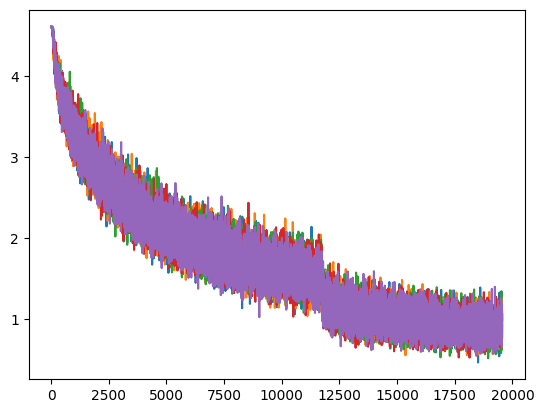

In [9]:
# Loop for multiple training and testing runs
num_runs = 5
epochs = 50

# Lists to store metrics from each run
all_runs_test_accuracies = []
all_runs_test_aucs = []

for run in range(num_runs):
    print(f"\n--- Run {run + 1}/{num_runs} ---")
    
    # Create a new instance of the CNN model for each run
    student = Student1()
    
    # Print the model architecture
    print("Model Architecture:")
    summary(student, input_size = (3, 32, 32))

    optimizer = optim.SGD(student.parameters(), lr = lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, 30, 0.2)
    
    # Training
    run_losses = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        epoch_losses = training_without_teacher(train_loader, student, criterion, optimizer, torch.device("mps"))
        run_losses += epoch_losses
        scheduler.step()

    plt.plot(run_losses)

    # Save the trained model for the current run
    student = student.cpu()
    model_save_path = f"models/without_teaching/student_run_{run + 1}.pth"
    torch.save(student.state_dict(), model_save_path)
    print(f"Model for run {run + 1} saved to {model_save_path}")
    torch.save(run_losses, f"results/without_teaching/student_losses_run_{run + 1}.pth")

    # Testing
    current_run_accuracy, current_run_auc = testing(test_loader, student, num_classes)
    
    all_runs_test_accuracies.append(current_run_accuracy)
    all_runs_test_aucs.append(current_run_auc)

    print(f"Run {run + 1} Test Accuracy: {current_run_accuracy:.2f}%")
    print(f"Run {run + 1} Test AUC: {current_run_auc:.4f}")

    # Add a separator for clarity between runs
    print("-" * 50)
    
print("\nAll runs completed.")

In [10]:
# --- Calculate and print average test metrics across all runs ---
print("\n--- Average Test Metrics Across All Runs ---")

avg_test_accuracy = np.nanmean(all_runs_test_accuracies) # Use nanmean to ignore NaNs if any occurred
std_test_accuracy = np.std(all_runs_test_accuracies)
avg_test_auc = np.nanmean(all_runs_test_aucs)

print(f"Average Test Accuracy over {num_runs} runs: {avg_test_accuracy:.2f}%")
print(f"Standard deviation of Test Accuracy over {num_runs} runs: {std_test_accuracy:.2f}%")
print(f"Average Test AUC (One-vs-Rest Macro) over {num_runs} runs: {avg_test_auc:.4f}")




--- Average Test Metrics Across All Runs ---
Average Test Accuracy over 5 runs: 53.72%
Standard deviation of Test Accuracy over 5 runs: 0.50%
Average Test AUC (One-vs-Rest Macro) over 5 runs: 0.9693


In [11]:
# Train with teacher
def training_with_teacher(dataloader, student, teacher, criterion, optimizer, loss_a, loss_temp, device):
    
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    student.train()
    teacher.eval()

    student = student.to(device)
    teacher = teacher.to(device)

    all_losses = []
    for batch_idx, (X, y) in enumerate(tqdm(dataloader, total = len(dataloader))):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        logits = student(X) # Shape: (batch_size, num_class)
        pred = torch.argmax(logits, dim = 1)

        # Teacher logits
        with torch.no_grad():
            logits_teacher = teacher(X)

        ce_loss = criterion(logits, y)
        kl_loss = (loss_temp**2) * F.kl_div(F.log_softmax(logits/loss_temp, dim = 1), 
                                            F.softmax(logits_teacher/loss_temp, dim = 1), 
                                            reduction = 'batchmean'
                                            )
        # Total loss
        loss = loss_a * ce_loss + (1 - loss_a) * kl_loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss, current = loss.item(), batch_idx * batch_size + len(X)
        all_losses.append(loss)
        if batch_idx % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print(f"Accuracy: {torch.mean((pred == y).float()) * 100}")
            
    return all_losses

Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 100]         409,700
Total params: 799,652
Trainable params: 799,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.75
Params size (MB): 3.05
Estimated Total Size (MB): 3.81
-----------------------

  1%|▉                                                                                                | 4/391 [00:06<08:17,  1.29s/it]

loss: 8.471959  [  128/50000]
Accuracy: 3.125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.91it/s]

loss: 8.649629  [12928/50000]
Accuracy: 7.03125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 8.030905  [25728/50000]
Accuracy: 3.125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 7.532817  [38528/50000]
Accuracy: 9.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.63it/s]


Epoch 2
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:31,  1.32s/it]

loss: 7.131608  [  128/50000]
Accuracy: 10.15625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.89it/s]

loss: 7.466663  [12928/50000]
Accuracy: 16.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 8.359908  [25728/50000]
Accuracy: 17.1875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.05it/s]

loss: 6.961815  [38528/50000]
Accuracy: 21.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 3
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:24,  1.30s/it]

loss: 6.693511  [  128/50000]
Accuracy: 18.75


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.93it/s]

loss: 6.974701  [12928/50000]
Accuracy: 21.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 6.891347  [25728/50000]
Accuracy: 21.875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.93it/s]

loss: 7.324049  [38528/50000]
Accuracy: 25.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 4
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:27,  1.31s/it]

loss: 6.497597  [  128/50000]
Accuracy: 21.875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 6.881914  [12928/50000]
Accuracy: 25.78125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 7.183518  [25728/50000]
Accuracy: 18.75


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 5.915199  [38528/50000]
Accuracy: 27.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 5
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:40,  1.34s/it]

loss: 6.433874  [  128/50000]
Accuracy: 26.5625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 6.399073  [12928/50000]
Accuracy: 29.6875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 6.864472  [25728/50000]
Accuracy: 24.21875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.03it/s]

loss: 5.220187  [38528/50000]
Accuracy: 33.59375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.54it/s]


Epoch 6
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:05,  1.25s/it]

loss: 6.352276  [  128/50000]
Accuracy: 33.59375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.84it/s]

loss: 6.261438  [12928/50000]
Accuracy: 32.8125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 6.026620  [25728/50000]
Accuracy: 35.15625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 5.898971  [38528/50000]
Accuracy: 32.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.70it/s]


Epoch 7
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:14,  1.03it/s]

loss: 6.261599  [  128/50000]
Accuracy: 36.71875


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 22.93it/s]

loss: 5.852145  [12928/50000]
Accuracy: 33.59375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:08, 22.95it/s]

loss: 5.757976  [25728/50000]
Accuracy: 36.71875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 22.97it/s]

loss: 5.913201  [38528/50000]
Accuracy: 34.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.26it/s]


Epoch 8
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:23,  1.30s/it]

loss: 5.747414  [  128/50000]
Accuracy: 35.9375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 5.670998  [12928/50000]
Accuracy: 35.15625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 5.621499  [25728/50000]
Accuracy: 34.375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 4.932870  [38528/50000]
Accuracy: 42.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 9
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:26,  1.15s/it]

loss: 5.294393  [  128/50000]
Accuracy: 40.625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 4.920287  [12928/50000]
Accuracy: 38.28125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.90it/s]

loss: 5.444053  [25728/50000]
Accuracy: 35.15625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 5.050228  [38528/50000]
Accuracy: 41.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.88it/s]


Epoch 10
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:21,  1.30s/it]

loss: 5.567982  [  128/50000]
Accuracy: 42.1875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.92it/s]

loss: 5.174374  [12928/50000]
Accuracy: 39.0625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 4.876741  [25728/50000]
Accuracy: 48.4375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 4.871253  [38528/50000]
Accuracy: 46.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 11
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:45,  1.20s/it]

loss: 5.600575  [  128/50000]
Accuracy: 44.53125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.87it/s]

loss: 5.271190  [12928/50000]
Accuracy: 47.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 4.827096  [25728/50000]
Accuracy: 50.0


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 4.933650  [38528/50000]
Accuracy: 42.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.80it/s]


Epoch 12
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:52,  1.22s/it]

loss: 5.078526  [  128/50000]
Accuracy: 42.96875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 5.160468  [12928/50000]
Accuracy: 34.375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.88it/s]

loss: 4.409678  [25728/50000]
Accuracy: 57.03125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.30it/s]

loss: 4.336145  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.79it/s]


Epoch 13
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:38,  1.03s/it]

loss: 5.682598  [  128/50000]
Accuracy: 42.96875


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 22.96it/s]

loss: 5.223387  [12928/50000]
Accuracy: 36.71875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.94it/s]

loss: 4.840028  [25728/50000]
Accuracy: 46.09375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 22.92it/s]

loss: 5.080157  [38528/50000]
Accuracy: 42.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.12it/s]


Epoch 14
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:26,  1.15s/it]

loss: 5.154512  [  128/50000]
Accuracy: 39.0625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 23.18it/s]

loss: 4.980361  [12928/50000]
Accuracy: 49.21875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.34it/s]

loss: 4.872905  [25728/50000]
Accuracy: 41.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.33it/s]

loss: 4.948984  [38528/50000]
Accuracy: 46.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.97it/s]


Epoch 15
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:09,  1.11s/it]

loss: 4.767231  [  128/50000]
Accuracy: 51.5625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 23.42it/s]

loss: 5.088343  [12928/50000]
Accuracy: 35.9375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.40it/s]

loss: 4.440063  [25728/50000]
Accuracy: 56.25


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.40it/s]

loss: 5.101922  [38528/50000]
Accuracy: 39.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.09it/s]


Epoch 16
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:29,  1.01s/it]

loss: 5.701055  [  128/50000]
Accuracy: 39.0625


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.39it/s]

loss: 4.061129  [12928/50000]
Accuracy: 58.59375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.43it/s]

loss: 3.952152  [25728/50000]
Accuracy: 52.34375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.39it/s]

loss: 4.967709  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.31it/s]


Epoch 17
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:17,  1.13s/it]

loss: 4.807270  [  128/50000]
Accuracy: 50.0


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 23.48it/s]

loss: 4.479207  [12928/50000]
Accuracy: 42.96875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.42it/s]

loss: 4.417900  [25728/50000]
Accuracy: 51.5625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.44it/s]

loss: 4.212700  [38528/50000]
Accuracy: 46.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.06it/s]


Epoch 18
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:38,  1.03s/it]

loss: 4.209823  [  128/50000]
Accuracy: 56.25


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.44it/s]

loss: 4.788906  [12928/50000]
Accuracy: 49.21875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.43it/s]

loss: 4.255853  [25728/50000]
Accuracy: 59.375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.43it/s]

loss: 4.688753  [38528/50000]
Accuracy: 50.78125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.27it/s]


Epoch 19
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:47,  1.05s/it]

loss: 4.969501  [  128/50000]
Accuracy: 50.0


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.41it/s]

loss: 4.644953  [12928/50000]
Accuracy: 53.125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.44it/s]

loss: 4.337973  [25728/50000]
Accuracy: 50.0


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.42it/s]

loss: 4.512978  [38528/50000]
Accuracy: 45.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.21it/s]


Epoch 20
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:44,  1.05s/it]

loss: 4.489464  [  128/50000]
Accuracy: 47.65625


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.36it/s]

loss: 4.904172  [12928/50000]
Accuracy: 47.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.38it/s]

loss: 4.515728  [25728/50000]
Accuracy: 50.78125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.37it/s]

loss: 4.395521  [38528/50000]
Accuracy: 48.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.23it/s]


Epoch 21
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:48,  1.06s/it]

loss: 4.309100  [  128/50000]
Accuracy: 52.34375


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.39it/s]

loss: 4.250293  [12928/50000]
Accuracy: 50.78125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.38it/s]

loss: 4.349503  [25728/50000]
Accuracy: 50.78125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.41it/s]

loss: 4.385331  [38528/50000]
Accuracy: 56.25


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.21it/s]


Epoch 22
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:29,  1.01s/it]

loss: 4.798118  [  128/50000]
Accuracy: 47.65625


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.44it/s]

loss: 4.670274  [12928/50000]
Accuracy: 47.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.39it/s]

loss: 4.183107  [25728/50000]
Accuracy: 50.78125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.41it/s]

loss: 3.912614  [38528/50000]
Accuracy: 59.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.31it/s]


Epoch 23
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:43,  1.04s/it]

loss: 4.300304  [  128/50000]
Accuracy: 49.21875


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.40it/s]

loss: 4.745284  [12928/50000]
Accuracy: 47.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.44it/s]

loss: 4.034476  [25728/50000]
Accuracy: 54.6875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.42it/s]

loss: 4.545865  [38528/50000]
Accuracy: 45.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.24it/s]


Epoch 24
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:49,  1.06s/it]

loss: 4.432830  [  128/50000]
Accuracy: 57.03125


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.39it/s]

loss: 4.356107  [12928/50000]
Accuracy: 50.78125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.42it/s]

loss: 4.606232  [25728/50000]
Accuracy: 50.0


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.40it/s]

loss: 4.032088  [38528/50000]
Accuracy: 48.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.20it/s]


Epoch 25
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:53,  1.07s/it]

loss: 4.244325  [  128/50000]
Accuracy: 56.25


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.42it/s]

loss: 3.680622  [12928/50000]
Accuracy: 53.90625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.44it/s]

loss: 4.461001  [25728/50000]
Accuracy: 55.46875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.44it/s]

loss: 4.212495  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.18it/s]


Epoch 26
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:58,  1.08s/it]

loss: 4.128810  [  128/50000]
Accuracy: 52.34375


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.43it/s]

loss: 4.279313  [12928/50000]
Accuracy: 57.8125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.43it/s]

loss: 3.997016  [25728/50000]
Accuracy: 57.8125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.41it/s]

loss: 4.697470  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.16it/s]


Epoch 27
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:40,  1.03s/it]

loss: 3.620168  [  128/50000]
Accuracy: 55.46875


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.48it/s]

loss: 4.240144  [12928/50000]
Accuracy: 48.4375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.41it/s]

loss: 4.076166  [25728/50000]
Accuracy: 48.4375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.41it/s]

loss: 3.974454  [38528/50000]
Accuracy: 58.59375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.25it/s]


Epoch 28
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:14,  1.12s/it]

loss: 4.224325  [  128/50000]
Accuracy: 56.25


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 23.41it/s]

loss: 3.690108  [12928/50000]
Accuracy: 57.8125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.40it/s]

loss: 4.419008  [25728/50000]
Accuracy: 57.8125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.44it/s]

loss: 4.366978  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 29
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:49,  1.06s/it]

loss: 3.389836  [  128/50000]
Accuracy: 61.71875


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.41it/s]

loss: 4.033230  [12928/50000]
Accuracy: 49.21875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.41it/s]

loss: 4.496091  [25728/50000]
Accuracy: 50.0


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.44it/s]

loss: 3.864995  [38528/50000]
Accuracy: 50.78125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.20it/s]


Epoch 30
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:43,  1.04s/it]

loss: 3.914847  [  128/50000]
Accuracy: 56.25


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.43it/s]

loss: 4.147220  [12928/50000]
Accuracy: 57.8125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.40it/s]

loss: 4.135871  [25728/50000]
Accuracy: 54.6875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.39it/s]

loss: 4.497848  [38528/50000]
Accuracy: 54.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.23it/s]


Epoch 31
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:28,  1.00s/it]

loss: 4.495765  [  128/50000]
Accuracy: 48.4375


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.39it/s]

loss: 3.403461  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.41it/s]

loss: 3.495979  [25728/50000]
Accuracy: 74.21875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.42it/s]

loss: 3.190911  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.31it/s]


Epoch 32
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:05,  1.10s/it]

loss: 3.787291  [  128/50000]
Accuracy: 57.8125


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.40it/s]

loss: 3.694819  [12928/50000]
Accuracy: 55.46875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.40it/s]

loss: 3.728915  [25728/50000]
Accuracy: 60.9375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.41it/s]

loss: 3.294600  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.11it/s]


Epoch 33
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:59,  1.09s/it]

loss: 3.496908  [  128/50000]
Accuracy: 70.3125


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.43it/s]

loss: 3.464753  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.74it/s]

loss: 3.369349  [25728/50000]
Accuracy: 64.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 22.91it/s]

loss: 3.895934  [38528/50000]
Accuracy: 64.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.02it/s]


Epoch 34
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:35,  1.18s/it]

loss: 3.490631  [  128/50000]
Accuracy: 58.59375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.92it/s]

loss: 3.108423  [12928/50000]
Accuracy: 60.9375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.91it/s]

loss: 3.323033  [25728/50000]
Accuracy: 59.375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 3.448105  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.85it/s]


Epoch 35
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:02,  1.25s/it]

loss: 3.596004  [  128/50000]
Accuracy: 60.9375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.93it/s]

loss: 3.348401  [12928/50000]
Accuracy: 64.84375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 3.453440  [25728/50000]
Accuracy: 63.28125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 3.146716  [38528/50000]
Accuracy: 72.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.71it/s]


Epoch 36
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:58,  1.24s/it]

loss: 3.129920  [  128/50000]
Accuracy: 71.09375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 3.573510  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.86it/s]

loss: 3.266253  [25728/50000]
Accuracy: 66.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 3.369262  [38528/50000]
Accuracy: 70.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.73it/s]


Epoch 37
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:15,  1.28s/it]

loss: 3.367266  [  128/50000]
Accuracy: 66.40625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.91it/s]

loss: 3.505041  [12928/50000]
Accuracy: 66.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 3.333082  [25728/50000]
Accuracy: 69.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 3.606311  [38528/50000]
Accuracy: 66.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Epoch 38
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:29,  1.16s/it]

loss: 3.483304  [  128/50000]
Accuracy: 60.9375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.95it/s]

loss: 3.952247  [12928/50000]
Accuracy: 60.15625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.90it/s]

loss: 3.234149  [25728/50000]
Accuracy: 67.96875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 3.823208  [38528/50000]
Accuracy: 64.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.87it/s]


Epoch 39
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:20,  1.29s/it]

loss: 3.487420  [  128/50000]
Accuracy: 68.75


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 3.230331  [12928/50000]
Accuracy: 72.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.87it/s]

loss: 3.455622  [25728/50000]
Accuracy: 60.15625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 3.004641  [38528/50000]
Accuracy: 73.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 40
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:45,  1.36s/it]

loss: 3.627663  [  128/50000]
Accuracy: 61.71875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 23.13it/s]

loss: 3.173306  [12928/50000]
Accuracy: 64.0625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 23.13it/s]

loss: 3.501585  [25728/50000]
Accuracy: 68.75


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.23it/s]

loss: 3.529964  [38528/50000]
Accuracy: 53.90625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 41
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:00,  1.24s/it]

loss: 2.849015  [  128/50000]
Accuracy: 74.21875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.83it/s]

loss: 3.272357  [12928/50000]
Accuracy: 68.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.86it/s]

loss: 3.137553  [25728/50000]
Accuracy: 63.28125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 3.205904  [38528/50000]
Accuracy: 74.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.72it/s]


Epoch 42
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:52,  1.22s/it]

loss: 3.580407  [  128/50000]
Accuracy: 72.65625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 3.614911  [12928/50000]
Accuracy: 60.9375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.88it/s]

loss: 3.085261  [25728/50000]
Accuracy: 72.65625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 3.583552  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.76it/s]


Epoch 43
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:09,  1.26s/it]

loss: 3.459887  [  128/50000]
Accuracy: 60.9375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 3.407198  [12928/50000]
Accuracy: 61.71875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 2.685901  [25728/50000]
Accuracy: 77.34375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 3.003990  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.68it/s]


Epoch 44
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:57,  1.08s/it]

loss: 3.349984  [  128/50000]
Accuracy: 60.9375


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 22.97it/s]

loss: 3.302005  [12928/50000]
Accuracy: 66.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 23.01it/s]

loss: 3.458242  [25728/50000]
Accuracy: 63.28125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.01it/s]

loss: 3.086810  [38528/50000]
Accuracy: 70.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.04it/s]


Epoch 45
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:12,  1.27s/it]

loss: 3.373616  [  128/50000]
Accuracy: 63.28125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 3.473356  [12928/50000]
Accuracy: 68.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.96it/s]

loss: 3.599604  [25728/50000]
Accuracy: 69.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.91it/s]

loss: 2.933901  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.66it/s]


Epoch 46
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:02,  1.25s/it]

loss: 3.593060  [  128/50000]
Accuracy: 71.875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.93it/s]

loss: 3.237370  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 2.909349  [25728/50000]
Accuracy: 75.78125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 3.449632  [38528/50000]
Accuracy: 59.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.71it/s]


Epoch 47
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:43,  1.35s/it]

loss: 3.356581  [  128/50000]
Accuracy: 67.96875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 3.247869  [12928/50000]
Accuracy: 71.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 3.254860  [25728/50000]
Accuracy: 68.75


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.00it/s]

loss: 3.165645  [38528/50000]
Accuracy: 62.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.52it/s]


Epoch 48
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:00,  1.24s/it]

loss: 3.094766  [  128/50000]
Accuracy: 67.96875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.92it/s]

loss: 3.279120  [12928/50000]
Accuracy: 69.53125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.88it/s]

loss: 3.226355  [25728/50000]
Accuracy: 66.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.05it/s]

loss: 3.054223  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.72it/s]


Epoch 49
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:17,  1.29s/it]

loss: 3.546467  [  128/50000]
Accuracy: 67.96875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.86it/s]

loss: 3.363759  [12928/50000]
Accuracy: 64.84375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 3.373651  [25728/50000]
Accuracy: 72.65625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 3.247486  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 50
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:33,  1.33s/it]

loss: 3.351123  [  128/50000]
Accuracy: 64.84375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 3.256584  [12928/50000]
Accuracy: 72.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 3.552876  [25728/50000]
Accuracy: 63.28125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.90it/s]

loss: 3.015599  [38528/50000]
Accuracy: 72.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.57it/s]


Model for run 1 saved to models/with_teaching/student_run_1.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.84it/s]


Run 1 Test Accuracy: 56.25%
Run 1 Test AUC: 0.9710
--------------------------------------------------

--- Run 2/5 ---
Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 100]         409,700
Total params: 799,652
Trainable params: 799,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.

  1%|▉                                                                                                | 4/391 [00:06<08:20,  1.29s/it]

loss: 8.913759  [  128/50000]
Accuracy: 0.0


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.89it/s]

loss: 8.630563  [12928/50000]
Accuracy: 3.90625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 7.784736  [25728/50000]
Accuracy: 3.90625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.06it/s]

loss: 7.423164  [38528/50000]
Accuracy: 6.25


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.63it/s]


Epoch 2
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:17,  1.28s/it]

loss: 7.243517  [  128/50000]
Accuracy: 14.0625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 7.329165  [12928/50000]
Accuracy: 13.28125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 7.169083  [25728/50000]
Accuracy: 11.71875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 6.891834  [38528/50000]
Accuracy: 20.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Epoch 3
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:58,  1.24s/it]

loss: 6.891117  [  128/50000]
Accuracy: 18.75


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 6.416504  [12928/50000]
Accuracy: 22.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.95it/s]

loss: 6.394766  [25728/50000]
Accuracy: 26.5625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.06it/s]

loss: 7.386985  [38528/50000]
Accuracy: 19.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.73it/s]


Epoch 4
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:27,  1.31s/it]

loss: 7.374455  [  128/50000]
Accuracy: 24.21875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.87it/s]

loss: 6.590435  [12928/50000]
Accuracy: 19.53125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.87it/s]

loss: 6.708037  [25728/50000]
Accuracy: 26.5625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 6.931033  [38528/50000]
Accuracy: 24.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 5
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:17,  1.28s/it]

loss: 6.491324  [  128/50000]
Accuracy: 23.4375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.91it/s]

loss: 6.594640  [12928/50000]
Accuracy: 35.9375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.96it/s]

loss: 6.106161  [25728/50000]
Accuracy: 32.03125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 6.671856  [38528/50000]
Accuracy: 29.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 6
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:27,  1.31s/it]

loss: 6.398953  [  128/50000]
Accuracy: 20.3125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.95it/s]

loss: 6.212559  [12928/50000]
Accuracy: 26.5625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 5.111382  [25728/50000]
Accuracy: 33.59375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 6.188230  [38528/50000]
Accuracy: 28.90625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 7
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:17,  1.29s/it]

loss: 5.395498  [  128/50000]
Accuracy: 39.84375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 5.809318  [12928/50000]
Accuracy: 32.03125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 6.037138  [25728/50000]
Accuracy: 32.8125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 5.385611  [38528/50000]
Accuracy: 28.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 8
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:10,  1.11s/it]

loss: 5.447924  [  128/50000]
Accuracy: 36.71875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 5.527872  [12928/50000]
Accuracy: 33.59375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.91it/s]

loss: 5.423099  [25728/50000]
Accuracy: 40.625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.02it/s]

loss: 6.015978  [38528/50000]
Accuracy: 32.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.97it/s]


Epoch 9
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:51,  1.22s/it]

loss: 5.571001  [  128/50000]
Accuracy: 36.71875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 5.504162  [12928/50000]
Accuracy: 36.71875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 5.008094  [25728/50000]
Accuracy: 42.1875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 5.867725  [38528/50000]
Accuracy: 39.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.77it/s]


Epoch 10
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:53,  1.22s/it]

loss: 5.669941  [  128/50000]
Accuracy: 41.40625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 5.346919  [12928/50000]
Accuracy: 40.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 5.163792  [25728/50000]
Accuracy: 42.1875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 5.497532  [38528/50000]
Accuracy: 35.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.76it/s]


Epoch 11
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:13,  1.12s/it]

loss: 4.968682  [  128/50000]
Accuracy: 44.53125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.93it/s]

loss: 5.099653  [12928/50000]
Accuracy: 39.0625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.93it/s]

loss: 5.039043  [25728/50000]
Accuracy: 39.84375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 22.96it/s]

loss: 5.557523  [38528/50000]
Accuracy: 36.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.95it/s]


Epoch 12
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:55,  1.07s/it]

loss: 5.305425  [  128/50000]
Accuracy: 37.5


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 22.90it/s]

loss: 5.138650  [12928/50000]
Accuracy: 46.875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.96it/s]

loss: 5.284989  [25728/50000]
Accuracy: 41.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 22.96it/s]

loss: 5.232912  [38528/50000]
Accuracy: 46.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.05it/s]


Epoch 13
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:15,  1.28s/it]

loss: 5.051213  [  128/50000]
Accuracy: 48.4375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 5.408181  [12928/50000]
Accuracy: 40.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.85it/s]

loss: 5.498072  [25728/50000]
Accuracy: 37.5


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 4.838960  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Epoch 14
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:53,  1.22s/it]

loss: 5.199998  [  128/50000]
Accuracy: 42.96875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 4.933896  [12928/50000]
Accuracy: 50.0


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 5.029503  [25728/50000]
Accuracy: 43.75


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.05it/s]

loss: 5.851675  [38528/50000]
Accuracy: 38.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.76it/s]


Epoch 15
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:01,  1.24s/it]

loss: 4.473430  [  128/50000]
Accuracy: 42.96875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.87it/s]

loss: 5.348277  [12928/50000]
Accuracy: 42.1875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 5.150701  [25728/50000]
Accuracy: 42.1875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 4.653677  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.72it/s]


Epoch 16
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:04,  1.10s/it]

loss: 4.783864  [  128/50000]
Accuracy: 38.28125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 4.621128  [12928/50000]
Accuracy: 55.46875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.90it/s]

loss: 4.383041  [25728/50000]
Accuracy: 41.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.02it/s]

loss: 4.739488  [38528/50000]
Accuracy: 45.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.00it/s]


Epoch 17
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:12,  1.12s/it]

loss: 4.490635  [  128/50000]
Accuracy: 49.21875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.95it/s]

loss: 4.569776  [12928/50000]
Accuracy: 43.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.91it/s]

loss: 4.675996  [25728/50000]
Accuracy: 46.09375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.02it/s]

loss: 4.818072  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.96it/s]


Epoch 18
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:02,  1.25s/it]

loss: 4.478828  [  128/50000]
Accuracy: 55.46875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 4.695547  [12928/50000]
Accuracy: 50.0


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 4.891119  [25728/50000]
Accuracy: 40.625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 4.619500  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.71it/s]


Epoch 19
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:32,  1.17s/it]

loss: 4.407681  [  128/50000]
Accuracy: 53.125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 4.768789  [12928/50000]
Accuracy: 46.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.91it/s]

loss: 4.905982  [25728/50000]
Accuracy: 46.875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 4.797620  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.86it/s]


Epoch 20
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:57,  1.23s/it]

loss: 4.095121  [  128/50000]
Accuracy: 50.78125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 4.652573  [12928/50000]
Accuracy: 53.125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 5.720152  [25728/50000]
Accuracy: 39.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 4.858982  [38528/50000]
Accuracy: 50.78125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.74it/s]


Epoch 21
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:13,  1.27s/it]

loss: 4.585538  [  128/50000]
Accuracy: 58.59375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 4.215226  [12928/50000]
Accuracy: 44.53125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 4.030801  [25728/50000]
Accuracy: 57.8125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 4.469935  [38528/50000]
Accuracy: 46.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.67it/s]


Epoch 22
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:04,  1.10s/it]

loss: 4.359813  [  128/50000]
Accuracy: 53.125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.94it/s]

loss: 4.795221  [12928/50000]
Accuracy: 50.0


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.91it/s]

loss: 4.097305  [25728/50000]
Accuracy: 54.6875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 22.91it/s]

loss: 4.067338  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.99it/s]


Epoch 23
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:11,  1.27s/it]

loss: 4.624975  [  128/50000]
Accuracy: 50.0


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 4.209550  [12928/50000]
Accuracy: 54.6875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 4.283027  [25728/50000]
Accuracy: 58.59375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 4.229550  [38528/50000]
Accuracy: 53.90625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.67it/s]


Epoch 24
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:23,  1.14s/it]

loss: 4.309440  [  128/50000]
Accuracy: 47.65625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.92it/s]

loss: 4.192215  [12928/50000]
Accuracy: 55.46875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.89it/s]

loss: 4.062465  [25728/50000]
Accuracy: 50.78125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 4.127101  [38528/50000]
Accuracy: 53.90625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.91it/s]


Epoch 25
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:33,  1.33s/it]

loss: 3.838142  [  128/50000]
Accuracy: 56.25


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.92it/s]

loss: 3.903542  [12928/50000]
Accuracy: 52.34375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.82it/s]

loss: 4.471525  [25728/50000]
Accuracy: 55.46875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.96it/s]

loss: 4.030331  [38528/50000]
Accuracy: 56.25


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 26
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:10,  1.27s/it]

loss: 4.415345  [  128/50000]
Accuracy: 52.34375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 4.452118  [12928/50000]
Accuracy: 54.6875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.87it/s]

loss: 4.109559  [25728/50000]
Accuracy: 52.34375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.96it/s]

loss: 3.914679  [38528/50000]
Accuracy: 60.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.67it/s]


Epoch 27
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:32,  1.17s/it]

loss: 3.996893  [  128/50000]
Accuracy: 57.8125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 4.267243  [12928/50000]
Accuracy: 54.6875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.92it/s]

loss: 4.411919  [25728/50000]
Accuracy: 52.34375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 4.109900  [38528/50000]
Accuracy: 60.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.86it/s]


Epoch 28
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:08,  1.26s/it]

loss: 4.072393  [  128/50000]
Accuracy: 59.375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.92it/s]

loss: 3.928641  [12928/50000]
Accuracy: 56.25


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 4.054737  [25728/50000]
Accuracy: 65.625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 4.003338  [38528/50000]
Accuracy: 58.59375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.69it/s]


Epoch 29
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:13,  1.28s/it]

loss: 4.061971  [  128/50000]
Accuracy: 52.34375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 4.381505  [12928/50000]
Accuracy: 57.03125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 4.146189  [25728/50000]
Accuracy: 49.21875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 4.260643  [38528/50000]
Accuracy: 63.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.66it/s]


Epoch 30
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:45,  1.20s/it]

loss: 4.325085  [  128/50000]
Accuracy: 50.0


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 3.866843  [12928/50000]
Accuracy: 57.8125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 3.937417  [25728/50000]
Accuracy: 58.59375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 3.937808  [38528/50000]
Accuracy: 57.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.80it/s]


Epoch 31
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:36,  1.18s/it]

loss: 3.661035  [  128/50000]
Accuracy: 61.71875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.92it/s]

loss: 3.626938  [12928/50000]
Accuracy: 58.59375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.89it/s]

loss: 3.280249  [25728/50000]
Accuracy: 64.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 3.785812  [38528/50000]
Accuracy: 57.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.84it/s]


Epoch 32
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:05,  1.25s/it]

loss: 3.412706  [  128/50000]
Accuracy: 64.0625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.86it/s]

loss: 3.825535  [12928/50000]
Accuracy: 58.59375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.84it/s]

loss: 3.666068  [25728/50000]
Accuracy: 65.625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 3.468194  [38528/50000]
Accuracy: 60.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.70it/s]


Epoch 33
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:40,  1.19s/it]

loss: 3.609333  [  128/50000]
Accuracy: 66.40625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 3.395800  [12928/50000]
Accuracy: 67.96875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.89it/s]

loss: 3.776684  [25728/50000]
Accuracy: 51.5625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 3.617702  [38528/50000]
Accuracy: 63.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.82it/s]


Epoch 34
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:41,  1.35s/it]

loss: 3.853339  [  128/50000]
Accuracy: 67.96875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.87it/s]

loss: 3.679294  [12928/50000]
Accuracy: 69.53125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 3.417181  [25728/50000]
Accuracy: 64.84375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.98it/s]

loss: 3.299237  [38528/50000]
Accuracy: 64.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.53it/s]


Epoch 35
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:16,  1.13s/it]

loss: 3.493397  [  128/50000]
Accuracy: 57.8125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.94it/s]

loss: 3.477199  [12928/50000]
Accuracy: 60.9375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.92it/s]

loss: 3.139797  [25728/50000]
Accuracy: 67.1875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.00it/s]

loss: 3.544923  [38528/50000]
Accuracy: 61.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.95it/s]


Epoch 36
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:51,  1.06s/it]

loss: 3.424217  [  128/50000]
Accuracy: 65.625


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 22.87it/s]

loss: 3.330049  [12928/50000]
Accuracy: 73.4375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.92it/s]

loss: 3.473895  [25728/50000]
Accuracy: 67.1875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 22.99it/s]

loss: 3.497785  [38528/50000]
Accuracy: 60.15625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.06it/s]


Epoch 37
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:14,  1.28s/it]

loss: 3.517940  [  128/50000]
Accuracy: 69.53125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.91it/s]

loss: 3.562323  [12928/50000]
Accuracy: 57.8125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 3.389774  [25728/50000]
Accuracy: 68.75


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 3.533078  [38528/50000]
Accuracy: 73.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Epoch 38
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:27,  1.16s/it]

loss: 3.755781  [  128/50000]
Accuracy: 65.625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 3.445030  [12928/50000]
Accuracy: 61.71875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.93it/s]

loss: 3.575549  [25728/50000]
Accuracy: 71.09375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 3.114122  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.88it/s]


Epoch 39
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:10,  1.27s/it]

loss: 3.379917  [  128/50000]
Accuracy: 65.625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.92it/s]

loss: 3.353992  [12928/50000]
Accuracy: 64.0625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 3.249923  [25728/50000]
Accuracy: 71.09375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 3.382089  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.68it/s]


Epoch 40
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:07,  1.26s/it]

loss: 3.266708  [  128/50000]
Accuracy: 64.0625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.95it/s]

loss: 3.229239  [12928/50000]
Accuracy: 71.875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.99it/s]

loss: 3.591345  [25728/50000]
Accuracy: 70.3125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 3.442251  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.70it/s]


Epoch 41
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:00,  1.09s/it]

loss: 3.389251  [  128/50000]
Accuracy: 70.3125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.97it/s]

loss: 3.241090  [12928/50000]
Accuracy: 68.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.89it/s]

loss: 3.708971  [25728/50000]
Accuracy: 62.5


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.01it/s]

loss: 3.509178  [38528/50000]
Accuracy: 71.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.02it/s]


Epoch 42
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:25,  1.15s/it]

loss: 3.423428  [  128/50000]
Accuracy: 69.53125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 3.228748  [12928/50000]
Accuracy: 61.71875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.90it/s]

loss: 3.139302  [25728/50000]
Accuracy: 64.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 3.340679  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.89it/s]


Epoch 43
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:16,  1.28s/it]

loss: 3.069888  [  128/50000]
Accuracy: 71.09375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.91it/s]

loss: 3.352800  [12928/50000]
Accuracy: 71.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 3.384449  [25728/50000]
Accuracy: 69.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 3.330153  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 44
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:54,  1.23s/it]

loss: 3.429514  [  128/50000]
Accuracy: 73.4375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 3.281389  [12928/50000]
Accuracy: 64.84375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.87it/s]

loss: 3.360492  [25728/50000]
Accuracy: 68.75


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 3.158722  [38528/50000]
Accuracy: 74.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.75it/s]


Epoch 45
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:25,  1.15s/it]

loss: 3.236418  [  128/50000]
Accuracy: 73.4375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 3.485676  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.90it/s]

loss: 3.459494  [25728/50000]
Accuracy: 69.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 3.067826  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.89it/s]


Epoch 46
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:48,  1.21s/it]

loss: 3.038872  [  128/50000]
Accuracy: 64.84375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 3.251204  [12928/50000]
Accuracy: 66.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 3.039647  [25728/50000]
Accuracy: 63.28125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 3.477859  [38528/50000]
Accuracy: 70.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.78it/s]


Epoch 47
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:55,  1.23s/it]

loss: 3.647363  [  128/50000]
Accuracy: 60.9375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.86it/s]

loss: 3.361466  [12928/50000]
Accuracy: 72.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 2.892245  [25728/50000]
Accuracy: 66.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 3.226642  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.74it/s]


Epoch 48
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:24,  1.30s/it]

loss: 3.705204  [  128/50000]
Accuracy: 65.625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.86it/s]

loss: 3.190489  [12928/50000]
Accuracy: 66.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 3.061499  [25728/50000]
Accuracy: 67.96875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 3.256080  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 49
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:27,  1.31s/it]

loss: 3.269959  [  128/50000]
Accuracy: 71.09375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.83it/s]

loss: 3.314306  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.85it/s]

loss: 3.542955  [25728/50000]
Accuracy: 63.28125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.95it/s]

loss: 3.259957  [38528/50000]
Accuracy: 72.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 50
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:21,  1.30s/it]

loss: 2.743409  [  128/50000]
Accuracy: 77.34375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.91it/s]

loss: 3.331782  [12928/50000]
Accuracy: 68.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.87it/s]

loss: 3.255160  [25728/50000]
Accuracy: 69.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.93it/s]

loss: 3.168065  [38528/50000]
Accuracy: 69.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.62it/s]


Model for run 2 saved to models/with_teaching/student_run_2.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:21<00:00,  3.73it/s]


Run 2 Test Accuracy: 55.58%
Run 2 Test AUC: 0.9708
--------------------------------------------------

--- Run 3/5 ---
Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 100]         409,700
Total params: 799,652
Trainable params: 799,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.

  1%|▉                                                                                                | 4/391 [00:07<09:30,  1.47s/it]

loss: 8.334167  [  128/50000]
Accuracy: 0.0


 26%|█████████████████████████                                                                      | 103/391 [00:12<00:12, 22.91it/s]

loss: 8.808362  [12928/50000]
Accuracy: 5.46875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:16<00:08, 22.93it/s]

loss: 8.288788  [25728/50000]
Accuracy: 9.375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.02it/s]

loss: 7.134302  [38528/50000]
Accuracy: 11.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.31it/s]


Epoch 2
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:36,  1.18s/it]

loss: 7.631203  [  128/50000]
Accuracy: 14.84375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.99it/s]

loss: 7.072417  [12928/50000]
Accuracy: 16.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.95it/s]

loss: 7.459547  [25728/50000]
Accuracy: 21.09375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 6.663943  [38528/50000]
Accuracy: 7.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.85it/s]


Epoch 3
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:04,  1.10s/it]

loss: 7.271073  [  128/50000]
Accuracy: 17.1875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.96it/s]

loss: 6.992550  [12928/50000]
Accuracy: 21.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.98it/s]

loss: 7.140717  [25728/50000]
Accuracy: 18.75


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.00it/s]

loss: 7.234812  [38528/50000]
Accuracy: 17.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.01it/s]


Epoch 4
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:42,  1.35s/it]

loss: 6.504744  [  128/50000]
Accuracy: 27.34375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.93it/s]

loss: 6.482018  [12928/50000]
Accuracy: 22.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.95it/s]

loss: 6.801399  [25728/50000]
Accuracy: 25.0


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.97it/s]

loss: 6.898215  [38528/50000]
Accuracy: 28.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.52it/s]


Epoch 5
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:53,  1.22s/it]

loss: 5.523448  [  128/50000]
Accuracy: 27.34375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.93it/s]

loss: 6.262913  [12928/50000]
Accuracy: 30.46875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 6.036511  [25728/50000]
Accuracy: 21.875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 6.472935  [38528/50000]
Accuracy: 27.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.75it/s]


Epoch 6
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:27,  1.31s/it]

loss: 6.374958  [  128/50000]
Accuracy: 25.78125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.78it/s]

loss: 5.978052  [12928/50000]
Accuracy: 32.8125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 5.483141  [25728/50000]
Accuracy: 32.03125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.95it/s]

loss: 5.399360  [38528/50000]
Accuracy: 29.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 7
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:11,  1.27s/it]

loss: 6.225315  [  128/50000]
Accuracy: 35.9375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.85it/s]

loss: 5.885910  [12928/50000]
Accuracy: 35.9375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 5.176172  [25728/50000]
Accuracy: 39.84375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 6.206309  [38528/50000]
Accuracy: 32.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.67it/s]


Epoch 8
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:59,  1.24s/it]

loss: 5.451499  [  128/50000]
Accuracy: 33.59375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.96it/s]

loss: 5.508650  [12928/50000]
Accuracy: 38.28125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 5.401095  [25728/50000]
Accuracy: 35.15625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 5.455968  [38528/50000]
Accuracy: 35.15625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.74it/s]


Epoch 9
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:42,  1.35s/it]

loss: 5.750196  [  128/50000]
Accuracy: 39.84375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.93it/s]

loss: 5.452948  [12928/50000]
Accuracy: 41.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.88it/s]

loss: 4.898282  [25728/50000]
Accuracy: 33.59375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.99it/s]

loss: 5.907991  [38528/50000]
Accuracy: 38.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.53it/s]


Epoch 10
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:12,  1.27s/it]

loss: 5.984648  [  128/50000]
Accuracy: 35.9375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 5.635530  [12928/50000]
Accuracy: 39.84375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.88it/s]

loss: 5.426267  [25728/50000]
Accuracy: 41.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 5.549973  [38528/50000]
Accuracy: 33.59375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.67it/s]


Epoch 11
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:25,  1.15s/it]

loss: 5.367418  [  128/50000]
Accuracy: 41.40625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.84it/s]

loss: 5.498312  [12928/50000]
Accuracy: 42.96875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.92it/s]

loss: 4.841856  [25728/50000]
Accuracy: 43.75


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 5.065130  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.89it/s]


Epoch 12
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:04,  1.25s/it]

loss: 4.607428  [  128/50000]
Accuracy: 50.78125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.85it/s]

loss: 5.284932  [12928/50000]
Accuracy: 41.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 5.539941  [25728/50000]
Accuracy: 35.15625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 5.239334  [38528/50000]
Accuracy: 44.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.70it/s]


Epoch 13
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:25,  1.31s/it]

loss: 4.743008  [  128/50000]
Accuracy: 39.0625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.87it/s]

loss: 5.329146  [12928/50000]
Accuracy: 46.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.88it/s]

loss: 5.172438  [25728/50000]
Accuracy: 39.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 5.158100  [38528/50000]
Accuracy: 48.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 14
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:54,  1.23s/it]

loss: 5.416646  [  128/50000]
Accuracy: 46.09375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 5.035300  [12928/50000]
Accuracy: 44.53125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.87it/s]

loss: 5.077399  [25728/50000]
Accuracy: 39.84375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.96it/s]

loss: 5.115635  [38528/50000]
Accuracy: 44.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.75it/s]


Epoch 15
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:48,  1.36s/it]

loss: 5.388958  [  128/50000]
Accuracy: 37.5


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 4.326732  [12928/50000]
Accuracy: 51.5625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 4.655544  [25728/50000]
Accuracy: 47.65625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.98it/s]

loss: 4.634781  [38528/50000]
Accuracy: 54.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.50it/s]


Epoch 16
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:03,  1.25s/it]

loss: 5.049870  [  128/50000]
Accuracy: 45.3125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 5.070300  [12928/50000]
Accuracy: 47.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 4.421302  [25728/50000]
Accuracy: 46.09375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 4.476498  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.72it/s]


Epoch 17
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:30,  1.32s/it]

loss: 4.871946  [  128/50000]
Accuracy: 46.875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.89it/s]

loss: 4.351487  [12928/50000]
Accuracy: 43.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 4.257977  [25728/50000]
Accuracy: 54.6875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 4.810592  [38528/50000]
Accuracy: 45.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 18
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:43,  1.20s/it]

loss: 4.444463  [  128/50000]
Accuracy: 50.78125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 4.126044  [12928/50000]
Accuracy: 49.21875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.88it/s]

loss: 4.317976  [25728/50000]
Accuracy: 56.25


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 4.608667  [38528/50000]
Accuracy: 46.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.81it/s]


Epoch 19
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:18,  1.29s/it]

loss: 4.497288  [  128/50000]
Accuracy: 53.90625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.95it/s]

loss: 4.322595  [12928/50000]
Accuracy: 54.6875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.95it/s]

loss: 4.668251  [25728/50000]
Accuracy: 50.0


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 4.618237  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 20
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:23,  1.01it/s]

loss: 4.780608  [  128/50000]
Accuracy: 50.0


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.15it/s]

loss: 3.954237  [12928/50000]
Accuracy: 64.0625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:08, 23.16it/s]

loss: 4.757949  [25728/50000]
Accuracy: 46.09375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.26it/s]

loss: 4.488415  [38528/50000]
Accuracy: 50.78125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.28it/s]


Epoch 21
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:08,  1.26s/it]

loss: 4.672862  [  128/50000]
Accuracy: 49.21875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 4.496555  [12928/50000]
Accuracy: 50.78125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.87it/s]

loss: 4.792580  [25728/50000]
Accuracy: 49.21875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 4.310910  [38528/50000]
Accuracy: 52.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.68it/s]


Epoch 22
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:41,  1.35s/it]

loss: 4.749585  [  128/50000]
Accuracy: 48.4375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.95it/s]

loss: 4.344370  [12928/50000]
Accuracy: 54.6875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.88it/s]

loss: 4.456900  [25728/50000]
Accuracy: 53.125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.92it/s]

loss: 3.648616  [38528/50000]
Accuracy: 54.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.52it/s]


Epoch 23
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:10,  1.27s/it]

loss: 4.692727  [  128/50000]
Accuracy: 47.65625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.94it/s]

loss: 4.771003  [12928/50000]
Accuracy: 47.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 4.428185  [25728/50000]
Accuracy: 53.125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.94it/s]

loss: 4.297904  [38528/50000]
Accuracy: 53.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.68it/s]


Epoch 24
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:08,  1.26s/it]

loss: 5.148512  [  128/50000]
Accuracy: 51.5625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 4.441944  [12928/50000]
Accuracy: 49.21875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 3.893625  [25728/50000]
Accuracy: 60.15625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 4.246159  [38528/50000]
Accuracy: 44.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.68it/s]


Epoch 25
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:54,  1.23s/it]

loss: 4.428875  [  128/50000]
Accuracy: 53.125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 4.339747  [12928/50000]
Accuracy: 54.6875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 4.303224  [25728/50000]
Accuracy: 53.90625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 4.264888  [38528/50000]
Accuracy: 60.15625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.75it/s]


Epoch 26
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:14,  1.28s/it]

loss: 4.085245  [  128/50000]
Accuracy: 57.03125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 4.106826  [12928/50000]
Accuracy: 52.34375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 4.174988  [25728/50000]
Accuracy: 56.25


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.05it/s]

loss: 4.040422  [38528/50000]
Accuracy: 57.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.66it/s]


Epoch 27
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:20,  1.29s/it]

loss: 3.992048  [  128/50000]
Accuracy: 52.34375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 4.264247  [12928/50000]
Accuracy: 61.71875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.97it/s]

loss: 4.103934  [25728/50000]
Accuracy: 53.90625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 4.247192  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.63it/s]


Epoch 28
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:00,  1.24s/it]

loss: 4.991300  [  128/50000]
Accuracy: 56.25


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 4.167862  [12928/50000]
Accuracy: 57.03125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 4.243462  [25728/50000]
Accuracy: 57.03125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 4.073712  [38528/50000]
Accuracy: 62.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.73it/s]


Epoch 29
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:36,  1.33s/it]

loss: 4.004001  [  128/50000]
Accuracy: 59.375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.85it/s]

loss: 3.894042  [12928/50000]
Accuracy: 54.6875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 4.521730  [25728/50000]
Accuracy: 46.09375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.93it/s]

loss: 3.864836  [38528/50000]
Accuracy: 57.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.55it/s]


Epoch 30
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:58,  1.24s/it]

loss: 3.858727  [  128/50000]
Accuracy: 53.90625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 4.278690  [12928/50000]
Accuracy: 55.46875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 4.367198  [25728/50000]
Accuracy: 57.03125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 4.209159  [38528/50000]
Accuracy: 57.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.73it/s]


Epoch 31
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:17,  1.28s/it]

loss: 3.768841  [  128/50000]
Accuracy: 57.8125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 3.662320  [12928/50000]
Accuracy: 61.71875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.83it/s]

loss: 3.950547  [25728/50000]
Accuracy: 52.34375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 3.499326  [38528/50000]
Accuracy: 65.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 32
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:04,  1.25s/it]

loss: 3.504725  [  128/50000]
Accuracy: 68.75


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.96it/s]

loss: 3.657454  [12928/50000]
Accuracy: 52.34375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 3.895772  [25728/50000]
Accuracy: 60.15625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 3.565945  [38528/50000]
Accuracy: 61.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.70it/s]


Epoch 33
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:01,  1.24s/it]

loss: 3.407469  [  128/50000]
Accuracy: 67.1875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.92it/s]

loss: 3.517925  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 3.238538  [25728/50000]
Accuracy: 67.96875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.89it/s]

loss: 3.565381  [38528/50000]
Accuracy: 73.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.71it/s]


Epoch 34
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:04,  1.25s/it]

loss: 3.259459  [  128/50000]
Accuracy: 66.40625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.93it/s]

loss: 3.535333  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 3.267692  [25728/50000]
Accuracy: 69.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 2.978191  [38528/50000]
Accuracy: 75.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.71it/s]


Epoch 35
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:16,  1.28s/it]

loss: 3.145865  [  128/50000]
Accuracy: 69.53125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.91it/s]

loss: 3.336062  [12928/50000]
Accuracy: 61.71875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.96it/s]

loss: 3.801826  [25728/50000]
Accuracy: 63.28125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 3.537462  [38528/50000]
Accuracy: 64.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Epoch 36
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:48,  1.21s/it]

loss: 3.587426  [  128/50000]
Accuracy: 64.84375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 3.539498  [12928/50000]
Accuracy: 60.15625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 3.933434  [25728/50000]
Accuracy: 63.28125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 3.414752  [38528/50000]
Accuracy: 70.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.78it/s]


Epoch 37
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:30,  1.32s/it]

loss: 3.628096  [  128/50000]
Accuracy: 61.71875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 3.410629  [12928/50000]
Accuracy: 64.0625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 3.131708  [25728/50000]
Accuracy: 78.90625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 3.358118  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 38
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:36,  1.18s/it]

loss: 3.543682  [  128/50000]
Accuracy: 65.625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 3.332339  [12928/50000]
Accuracy: 66.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.91it/s]

loss: 2.907818  [25728/50000]
Accuracy: 70.3125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.94it/s]

loss: 4.044695  [38528/50000]
Accuracy: 58.59375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.84it/s]


Epoch 39
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:18,  1.29s/it]

loss: 3.536199  [  128/50000]
Accuracy: 64.84375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.89it/s]

loss: 3.229621  [12928/50000]
Accuracy: 67.96875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 3.198248  [25728/50000]
Accuracy: 64.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 3.357538  [38528/50000]
Accuracy: 63.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 40
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:54,  1.23s/it]

loss: 3.449116  [  128/50000]
Accuracy: 69.53125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.86it/s]

loss: 3.699569  [12928/50000]
Accuracy: 61.71875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 3.567348  [25728/50000]
Accuracy: 71.875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.89it/s]

loss: 3.413009  [38528/50000]
Accuracy: 58.59375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.75it/s]


Epoch 41
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:14,  1.28s/it]

loss: 3.643950  [  128/50000]
Accuracy: 66.40625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.91it/s]

loss: 3.267392  [12928/50000]
Accuracy: 76.5625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 3.560709  [25728/50000]
Accuracy: 64.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.93it/s]

loss: 3.190297  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Epoch 42
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:40,  1.19s/it]

loss: 3.410235  [  128/50000]
Accuracy: 67.1875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 3.735825  [12928/50000]
Accuracy: 59.375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.96it/s]

loss: 3.233982  [25728/50000]
Accuracy: 71.875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 3.362243  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.82it/s]


Epoch 43
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:29,  1.32s/it]

loss: 3.224966  [  128/50000]
Accuracy: 67.96875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.93it/s]

loss: 3.450139  [12928/50000]
Accuracy: 71.875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 3.215347  [25728/50000]
Accuracy: 70.3125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 3.182055  [38528/50000]
Accuracy: 66.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 44
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:40,  1.35s/it]

loss: 3.277632  [  128/50000]
Accuracy: 67.96875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.91it/s]

loss: 3.107134  [12928/50000]
Accuracy: 69.53125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.97it/s]

loss: 3.269599  [25728/50000]
Accuracy: 64.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.97it/s]

loss: 3.735607  [38528/50000]
Accuracy: 66.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.53it/s]


Epoch 45
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:28,  1.16s/it]

loss: 3.282170  [  128/50000]
Accuracy: 71.09375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 3.278683  [12928/50000]
Accuracy: 71.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.92it/s]

loss: 3.456479  [25728/50000]
Accuracy: 64.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 3.398998  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.88it/s]


Epoch 46
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:41,  1.19s/it]

loss: 3.216596  [  128/50000]
Accuracy: 68.75


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 3.131129  [12928/50000]
Accuracy: 72.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 2.845057  [25728/50000]
Accuracy: 73.4375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 3.260730  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.82it/s]


Epoch 47
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:47,  1.05s/it]

loss: 3.354188  [  128/50000]
Accuracy: 68.75


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.17it/s]

loss: 3.530988  [12928/50000]
Accuracy: 72.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 23.16it/s]

loss: 3.337441  [25728/50000]
Accuracy: 71.09375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.28it/s]

loss: 3.020063  [38528/50000]
Accuracy: 71.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 48
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:15,  1.28s/it]

loss: 3.255085  [  128/50000]
Accuracy: 70.3125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 3.187252  [12928/50000]
Accuracy: 61.71875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 3.127117  [25728/50000]
Accuracy: 71.09375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 3.282427  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Epoch 49
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:13,  1.12s/it]

loss: 3.481031  [  128/50000]
Accuracy: 71.875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 3.102100  [12928/50000]
Accuracy: 68.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.90it/s]

loss: 2.731789  [25728/50000]
Accuracy: 69.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.04it/s]

loss: 3.231739  [38528/50000]
Accuracy: 71.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.96it/s]


Epoch 50
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:20,  1.29s/it]

loss: 3.850573  [  128/50000]
Accuracy: 63.28125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 3.264908  [12928/50000]
Accuracy: 68.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.87it/s]

loss: 3.571995  [25728/50000]
Accuracy: 70.3125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 3.568146  [38528/50000]
Accuracy: 64.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.62it/s]


Model for run 3 saved to models/with_teaching/student_run_3.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:21<00:00,  3.75it/s]


Run 3 Test Accuracy: 56.90%
Run 3 Test AUC: 0.9719
--------------------------------------------------

--- Run 4/5 ---
Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 100]         409,700
Total params: 799,652
Trainable params: 799,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.

  1%|▉                                                                                                | 4/391 [00:06<08:17,  1.29s/it]

loss: 9.327459  [  128/50000]
Accuracy: 1.5625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.93it/s]

loss: 8.289660  [12928/50000]
Accuracy: 0.0


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 8.013018  [25728/50000]
Accuracy: 7.03125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 8.194084  [38528/50000]
Accuracy: 5.46875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 2
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:49,  1.21s/it]

loss: 8.488112  [  128/50000]
Accuracy: 11.71875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.85it/s]

loss: 6.700050  [12928/50000]
Accuracy: 17.96875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 6.322532  [25728/50000]
Accuracy: 16.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 7.357230  [38528/50000]
Accuracy: 13.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.77it/s]


Epoch 3
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:22,  1.30s/it]

loss: 7.235027  [  128/50000]
Accuracy: 21.09375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.92it/s]

loss: 7.721774  [12928/50000]
Accuracy: 20.3125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.95it/s]

loss: 6.553440  [25728/50000]
Accuracy: 20.3125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 7.689756  [38528/50000]
Accuracy: 20.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 4
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:48,  1.21s/it]

loss: 6.328143  [  128/50000]
Accuracy: 23.4375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 6.347782  [12928/50000]
Accuracy: 25.0


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.96it/s]

loss: 6.173389  [25728/50000]
Accuracy: 23.4375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.94it/s]

loss: 6.863862  [38528/50000]
Accuracy: 24.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.77it/s]


Epoch 5
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:46,  1.36s/it]

loss: 6.292003  [  128/50000]
Accuracy: 21.09375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.87it/s]

loss: 6.734477  [12928/50000]
Accuracy: 27.34375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 6.151380  [25728/50000]
Accuracy: 31.25


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.09it/s]

loss: 6.012307  [38528/50000]
Accuracy: 35.15625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.50it/s]


Epoch 6
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:26,  1.15s/it]

loss: 6.332776  [  128/50000]
Accuracy: 23.4375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.84it/s]

loss: 6.009515  [12928/50000]
Accuracy: 30.46875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.88it/s]

loss: 6.390407  [25728/50000]
Accuracy: 33.59375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.94it/s]

loss: 5.960970  [38528/50000]
Accuracy: 32.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.89it/s]


Epoch 7
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:48,  1.06s/it]

loss: 5.687245  [  128/50000]
Accuracy: 26.5625


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 22.92it/s]

loss: 5.828961  [12928/50000]
Accuracy: 34.375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.91it/s]

loss: 5.530561  [25728/50000]
Accuracy: 39.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.01it/s]

loss: 5.436663  [38528/50000]
Accuracy: 40.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 8
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:14,  1.28s/it]

loss: 5.725418  [  128/50000]
Accuracy: 32.03125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.89it/s]

loss: 5.614405  [12928/50000]
Accuracy: 28.125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 5.718404  [25728/50000]
Accuracy: 35.15625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 6.107712  [38528/50000]
Accuracy: 35.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.66it/s]


Epoch 9
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:58,  1.24s/it]

loss: 5.818192  [  128/50000]
Accuracy: 36.71875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.86it/s]

loss: 5.644754  [12928/50000]
Accuracy: 35.15625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 5.644824  [25728/50000]
Accuracy: 33.59375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 5.052956  [38528/50000]
Accuracy: 41.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.73it/s]


Epoch 10
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:18,  1.29s/it]

loss: 5.408288  [  128/50000]
Accuracy: 33.59375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.87it/s]

loss: 5.848132  [12928/50000]
Accuracy: 43.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 5.801625  [25728/50000]
Accuracy: 34.375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 5.881361  [38528/50000]
Accuracy: 32.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 11
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:43,  1.20s/it]

loss: 4.710109  [  128/50000]
Accuracy: 43.75


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 5.341168  [12928/50000]
Accuracy: 41.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 5.589601  [25728/50000]
Accuracy: 32.8125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 4.965860  [38528/50000]
Accuracy: 40.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.80it/s]


Epoch 12
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:32,  1.17s/it]

loss: 5.595932  [  128/50000]
Accuracy: 32.03125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 4.984595  [12928/50000]
Accuracy: 44.53125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.91it/s]

loss: 5.057416  [25728/50000]
Accuracy: 44.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 5.795251  [38528/50000]
Accuracy: 41.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.86it/s]


Epoch 13
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:22,  1.30s/it]

loss: 5.330551  [  128/50000]
Accuracy: 35.9375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.94it/s]

loss: 4.544202  [12928/50000]
Accuracy: 52.34375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 4.947939  [25728/50000]
Accuracy: 43.75


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 4.381338  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 14
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:34,  1.17s/it]

loss: 5.006964  [  128/50000]
Accuracy: 36.71875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.94it/s]

loss: 4.892566  [12928/50000]
Accuracy: 43.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.95it/s]

loss: 4.853190  [25728/50000]
Accuracy: 46.875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 5.092442  [38528/50000]
Accuracy: 46.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.85it/s]


Epoch 15
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:28,  1.00s/it]

loss: 4.506862  [  128/50000]
Accuracy: 45.3125


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 22.90it/s]

loss: 4.494216  [12928/50000]
Accuracy: 44.53125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.90it/s]

loss: 5.277626  [25728/50000]
Accuracy: 37.5


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 22.87it/s]

loss: 4.754664  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.17it/s]


Epoch 16
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:55,  1.23s/it]

loss: 4.578996  [  128/50000]
Accuracy: 48.4375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 4.706791  [12928/50000]
Accuracy: 44.53125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 4.444787  [25728/50000]
Accuracy: 53.125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 4.306797  [38528/50000]
Accuracy: 44.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.75it/s]


Epoch 17
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:45,  1.36s/it]

loss: 4.767347  [  128/50000]
Accuracy: 46.09375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.89it/s]

loss: 4.486888  [12928/50000]
Accuracy: 49.21875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 4.552963  [25728/50000]
Accuracy: 44.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.97it/s]

loss: 4.546829  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.51it/s]


Epoch 18
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<09:04,  1.41s/it]

loss: 4.925791  [  128/50000]
Accuracy: 53.125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 4.319383  [12928/50000]
Accuracy: 45.3125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:16<00:08, 22.92it/s]

loss: 4.619634  [25728/50000]
Accuracy: 50.0


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.92it/s]

loss: 4.225145  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.41it/s]


Epoch 19
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:26,  1.31s/it]

loss: 4.037854  [  128/50000]
Accuracy: 57.03125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.89it/s]

loss: 4.855172  [12928/50000]
Accuracy: 46.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 4.287915  [25728/50000]
Accuracy: 50.78125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.95it/s]

loss: 4.312302  [38528/50000]
Accuracy: 55.46875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 20
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:22,  1.30s/it]

loss: 4.308625  [  128/50000]
Accuracy: 49.21875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 23.34it/s]

loss: 4.496360  [12928/50000]
Accuracy: 49.21875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:07, 23.36it/s]

loss: 4.095028  [25728/50000]
Accuracy: 58.59375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.38it/s]

loss: 4.413725  [38528/50000]
Accuracy: 53.90625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.72it/s]


Epoch 21
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:45,  1.05s/it]

loss: 4.522237  [  128/50000]
Accuracy: 48.4375


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.44it/s]

loss: 4.282909  [12928/50000]
Accuracy: 48.4375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.39it/s]

loss: 4.519657  [25728/50000]
Accuracy: 49.21875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.41it/s]

loss: 4.985757  [38528/50000]
Accuracy: 54.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.22it/s]


Epoch 22
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:27,  1.00s/it]

loss: 4.394773  [  128/50000]
Accuracy: 50.0


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.44it/s]

loss: 4.205646  [12928/50000]
Accuracy: 48.4375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.42it/s]

loss: 4.022996  [25728/50000]
Accuracy: 55.46875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.43it/s]

loss: 4.538668  [38528/50000]
Accuracy: 50.78125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.32it/s]


Epoch 23
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:25,  1.00it/s]

loss: 4.401831  [  128/50000]
Accuracy: 53.90625


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.25it/s]

loss: 4.438198  [12928/50000]
Accuracy: 50.0


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.34it/s]

loss: 4.314540  [25728/50000]
Accuracy: 51.5625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.39it/s]

loss: 4.816010  [38528/50000]
Accuracy: 53.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.32it/s]


Epoch 24
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:28,  1.00s/it]

loss: 4.314154  [  128/50000]
Accuracy: 50.78125


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.25it/s]

loss: 3.948106  [12928/50000]
Accuracy: 58.59375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.36it/s]

loss: 4.665002  [25728/50000]
Accuracy: 51.5625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.38it/s]

loss: 4.757444  [38528/50000]
Accuracy: 52.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.30it/s]


Epoch 25
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:29,  1.16s/it]

loss: 3.957190  [  128/50000]
Accuracy: 57.03125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 23.36it/s]

loss: 4.246276  [12928/50000]
Accuracy: 57.03125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.39it/s]

loss: 4.745559  [25728/50000]
Accuracy: 49.21875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.39it/s]

loss: 4.302900  [38528/50000]
Accuracy: 52.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.99it/s]


Epoch 26
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:43,  1.04s/it]

loss: 4.251319  [  128/50000]
Accuracy: 53.125


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.42it/s]

loss: 4.226395  [12928/50000]
Accuracy: 56.25


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.41it/s]

loss: 4.568544  [25728/50000]
Accuracy: 50.78125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.40it/s]

loss: 4.336778  [38528/50000]
Accuracy: 55.46875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.24it/s]


Epoch 27
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:37,  1.03s/it]

loss: 4.509839  [  128/50000]
Accuracy: 44.53125


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.42it/s]

loss: 3.973705  [12928/50000]
Accuracy: 53.90625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.38it/s]

loss: 4.129763  [25728/50000]
Accuracy: 49.21875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.37it/s]

loss: 3.916968  [38528/50000]
Accuracy: 57.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.26it/s]


Epoch 28
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:07,  1.10s/it]

loss: 4.032051  [  128/50000]
Accuracy: 57.03125


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.45it/s]

loss: 4.416809  [12928/50000]
Accuracy: 56.25


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.44it/s]

loss: 4.419154  [25728/50000]
Accuracy: 53.90625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.40it/s]

loss: 4.474820  [38528/50000]
Accuracy: 53.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.12it/s]


Epoch 29
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:36,  1.03s/it]

loss: 3.946669  [  128/50000]
Accuracy: 51.5625


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.41it/s]

loss: 4.055172  [12928/50000]
Accuracy: 49.21875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.36it/s]

loss: 4.145026  [25728/50000]
Accuracy: 52.34375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.40it/s]

loss: 3.704291  [38528/50000]
Accuracy: 63.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.27it/s]


Epoch 30
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:44,  1.05s/it]

loss: 4.023432  [  128/50000]
Accuracy: 53.125


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.45it/s]

loss: 3.853228  [12928/50000]
Accuracy: 54.6875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.43it/s]

loss: 4.857803  [25728/50000]
Accuracy: 57.03125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.41it/s]

loss: 4.427788  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.23it/s]


Epoch 31
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:45,  1.05s/it]

loss: 4.033499  [  128/50000]
Accuracy: 58.59375


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.37it/s]

loss: 3.780879  [12928/50000]
Accuracy: 62.5


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.42it/s]

loss: 3.573620  [25728/50000]
Accuracy: 60.15625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.40it/s]

loss: 3.498892  [38528/50000]
Accuracy: 65.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.22it/s]


Epoch 32
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:07,  1.10s/it]

loss: 3.642075  [  128/50000]
Accuracy: 67.1875


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.47it/s]

loss: 3.824816  [12928/50000]
Accuracy: 60.15625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.41it/s]

loss: 3.602551  [25728/50000]
Accuracy: 64.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.44it/s]

loss: 3.526959  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.11it/s]


Epoch 33
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:33,  1.02s/it]

loss: 3.218462  [  128/50000]
Accuracy: 67.96875


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.37it/s]

loss: 3.416433  [12928/50000]
Accuracy: 66.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.39it/s]

loss: 3.416216  [25728/50000]
Accuracy: 62.5


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.39it/s]

loss: 3.758825  [38528/50000]
Accuracy: 64.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.28it/s]


Epoch 34
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:33,  1.02s/it]

loss: 3.498063  [  128/50000]
Accuracy: 61.71875


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.53it/s]

loss: 3.167630  [12928/50000]
Accuracy: 64.0625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.46it/s]

loss: 3.309191  [25728/50000]
Accuracy: 63.28125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.38it/s]

loss: 3.448556  [38528/50000]
Accuracy: 62.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.30it/s]


Epoch 35
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:58,  1.08s/it]

loss: 3.233214  [  128/50000]
Accuracy: 69.53125


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.48it/s]

loss: 3.117479  [12928/50000]
Accuracy: 70.3125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.49it/s]

loss: 3.290857  [25728/50000]
Accuracy: 64.84375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.40it/s]

loss: 3.130692  [38528/50000]
Accuracy: 68.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.17it/s]


Epoch 36
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:50,  1.06s/it]

loss: 3.252745  [  128/50000]
Accuracy: 67.1875


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.49it/s]

loss: 3.313705  [12928/50000]
Accuracy: 74.21875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.48it/s]

loss: 3.532511  [25728/50000]
Accuracy: 60.9375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.39it/s]

loss: 3.384177  [38528/50000]
Accuracy: 67.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.21it/s]


Epoch 37
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:45,  1.05s/it]

loss: 3.482967  [  128/50000]
Accuracy: 71.09375


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.34it/s]

loss: 3.727469  [12928/50000]
Accuracy: 70.3125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.39it/s]

loss: 3.337771  [25728/50000]
Accuracy: 67.96875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.38it/s]

loss: 3.889942  [38528/50000]
Accuracy: 64.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.21it/s]


Epoch 38
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:39,  1.03s/it]

loss: 3.334720  [  128/50000]
Accuracy: 68.75


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.35it/s]

loss: 3.612635  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.41it/s]

loss: 2.990966  [25728/50000]
Accuracy: 74.21875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.44it/s]

loss: 3.217588  [38528/50000]
Accuracy: 64.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.25it/s]


Epoch 39
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:42,  1.04s/it]

loss: 3.239283  [  128/50000]
Accuracy: 73.4375


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.39it/s]

loss: 3.370301  [12928/50000]
Accuracy: 64.84375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.40it/s]

loss: 3.373965  [25728/50000]
Accuracy: 60.15625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.37it/s]

loss: 3.418594  [38528/50000]
Accuracy: 61.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.23it/s]


Epoch 40
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:58,  1.08s/it]

loss: 3.177063  [  128/50000]
Accuracy: 64.0625


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.37it/s]

loss: 3.160227  [12928/50000]
Accuracy: 68.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:07, 23.42it/s]

loss: 3.359271  [25728/50000]
Accuracy: 64.84375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.42it/s]

loss: 3.153507  [38528/50000]
Accuracy: 65.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.16it/s]


Epoch 41
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:37,  1.03s/it]

loss: 3.643715  [  128/50000]
Accuracy: 67.1875


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.44it/s]

loss: 2.992981  [12928/50000]
Accuracy: 67.96875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.36it/s]

loss: 3.846594  [25728/50000]
Accuracy: 67.96875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.39it/s]

loss: 3.511087  [38528/50000]
Accuracy: 63.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.26it/s]


Epoch 42
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:28,  1.00s/it]

loss: 3.071324  [  128/50000]
Accuracy: 67.96875


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.48it/s]

loss: 3.215140  [12928/50000]
Accuracy: 67.1875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.47it/s]

loss: 2.991900  [25728/50000]
Accuracy: 68.75


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.37it/s]

loss: 3.472859  [38528/50000]
Accuracy: 60.9375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.32it/s]


Epoch 43
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<06:35,  1.02s/it]

loss: 3.433615  [  128/50000]
Accuracy: 66.40625


 26%|█████████████████████████                                                                      | 103/391 [00:09<00:12, 23.44it/s]

loss: 3.284151  [12928/50000]
Accuracy: 66.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:13<00:07, 23.40it/s]

loss: 3.197851  [25728/50000]
Accuracy: 73.4375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.40it/s]

loss: 3.640069  [38528/50000]
Accuracy: 63.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.27it/s]


Epoch 44
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:18,  1.13s/it]

loss: 3.422167  [  128/50000]
Accuracy: 68.75


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.86it/s]

loss: 3.459724  [12928/50000]
Accuracy: 62.5


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.90it/s]

loss: 3.046136  [25728/50000]
Accuracy: 65.625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 3.600379  [38528/50000]
Accuracy: 61.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.93it/s]


Epoch 45
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:43,  1.20s/it]

loss: 2.939488  [  128/50000]
Accuracy: 68.75


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.85it/s]

loss: 3.380645  [12928/50000]
Accuracy: 67.96875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.87it/s]

loss: 3.360285  [25728/50000]
Accuracy: 69.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 3.745970  [38528/50000]
Accuracy: 63.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.80it/s]


Epoch 46
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:12,  1.27s/it]

loss: 3.316925  [  128/50000]
Accuracy: 69.53125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.95it/s]

loss: 3.339645  [12928/50000]
Accuracy: 64.0625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 3.231312  [25728/50000]
Accuracy: 70.3125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 3.503077  [38528/50000]
Accuracy: 63.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.67it/s]


Epoch 47
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:46,  1.20s/it]

loss: 3.378550  [  128/50000]
Accuracy: 72.65625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.95it/s]

loss: 3.240209  [12928/50000]
Accuracy: 68.75


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 2.929755  [25728/50000]
Accuracy: 73.4375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 3.293766  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.79it/s]


Epoch 48
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:24,  1.30s/it]

loss: 3.242246  [  128/50000]
Accuracy: 71.09375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.81it/s]

loss: 3.509750  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 3.376621  [25728/50000]
Accuracy: 69.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.95it/s]

loss: 3.258601  [38528/50000]
Accuracy: 71.875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 49
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:52,  1.22s/it]

loss: 3.487139  [  128/50000]
Accuracy: 65.625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.85it/s]

loss: 3.029425  [12928/50000]
Accuracy: 69.53125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.86it/s]

loss: 3.153270  [25728/50000]
Accuracy: 73.4375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.89it/s]

loss: 3.311137  [38528/50000]
Accuracy: 74.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.75it/s]


Epoch 50
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:06,  1.26s/it]

loss: 3.545423  [  128/50000]
Accuracy: 68.75


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 3.068589  [12928/50000]
Accuracy: 64.0625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 3.098490  [25728/50000]
Accuracy: 65.625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 3.725210  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.70it/s]


Model for run 4 saved to models/with_teaching/student_run_4.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:21<00:00,  3.75it/s]


Run 4 Test Accuracy: 56.73%
Run 4 Test AUC: 0.9708
--------------------------------------------------

--- Run 5/5 ---
Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 100]         409,700
Total params: 799,652
Trainable params: 799,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.

  1%|▉                                                                                                | 4/391 [00:06<08:10,  1.27s/it]

loss: 9.042262  [  128/50000]
Accuracy: 0.78125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 8.764538  [12928/50000]
Accuracy: 4.6875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 7.969043  [25728/50000]
Accuracy: 7.8125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 7.526946  [38528/50000]
Accuracy: 7.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.68it/s]


Epoch 2
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:29,  1.16s/it]

loss: 7.260065  [  128/50000]
Accuracy: 8.59375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.87it/s]

loss: 7.191714  [12928/50000]
Accuracy: 11.71875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.93it/s]

loss: 7.148501  [25728/50000]
Accuracy: 17.96875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 7.380707  [38528/50000]
Accuracy: 16.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.88it/s]


Epoch 3
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:34,  1.33s/it]

loss: 7.195992  [  128/50000]
Accuracy: 17.1875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 7.107808  [12928/50000]
Accuracy: 21.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 6.946240  [25728/50000]
Accuracy: 31.25


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.99it/s]

loss: 6.344867  [38528/50000]
Accuracy: 21.09375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 4
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:41,  1.19s/it]

loss: 6.952374  [  128/50000]
Accuracy: 21.09375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 6.342902  [12928/50000]
Accuracy: 28.90625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 6.615017  [25728/50000]
Accuracy: 26.5625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 6.583587  [38528/50000]
Accuracy: 23.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.82it/s]


Epoch 5
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:14,  1.28s/it]

loss: 6.302311  [  128/50000]
Accuracy: 20.3125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.86it/s]

loss: 6.434006  [12928/50000]
Accuracy: 30.46875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 6.056981  [25728/50000]
Accuracy: 25.78125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.96it/s]

loss: 6.244906  [38528/50000]
Accuracy: 27.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Epoch 6
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:27,  1.31s/it]

loss: 6.648069  [  128/50000]
Accuracy: 28.90625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 6.031241  [12928/50000]
Accuracy: 33.59375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 6.214043  [25728/50000]
Accuracy: 30.46875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 6.381148  [38528/50000]
Accuracy: 27.34375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 7
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:13,  1.28s/it]

loss: 6.172009  [  128/50000]
Accuracy: 25.78125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 6.275825  [12928/50000]
Accuracy: 27.34375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 4.957845  [25728/50000]
Accuracy: 39.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 5.850503  [38528/50000]
Accuracy: 32.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.66it/s]


Epoch 8
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:47,  1.21s/it]

loss: 5.495547  [  128/50000]
Accuracy: 32.03125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.92it/s]

loss: 5.980642  [12928/50000]
Accuracy: 38.28125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.83it/s]

loss: 6.200592  [25728/50000]
Accuracy: 32.03125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 5.434978  [38528/50000]
Accuracy: 34.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.79it/s]


Epoch 9
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<09:06,  1.41s/it]

loss: 6.208149  [  128/50000]
Accuracy: 32.8125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 5.244219  [12928/50000]
Accuracy: 41.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:16<00:08, 22.89it/s]

loss: 5.853591  [25728/50000]
Accuracy: 35.9375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.97it/s]

loss: 5.051223  [38528/50000]
Accuracy: 41.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.41it/s]


Epoch 10
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:15,  1.28s/it]

loss: 5.833007  [  128/50000]
Accuracy: 35.15625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.87it/s]

loss: 5.665537  [12928/50000]
Accuracy: 37.5


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.84it/s]

loss: 5.239783  [25728/50000]
Accuracy: 34.375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 5.076647  [38528/50000]
Accuracy: 43.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Epoch 11
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:14,  1.12s/it]

loss: 5.517488  [  128/50000]
Accuracy: 49.21875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 5.504154  [12928/50000]
Accuracy: 35.15625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.93it/s]

loss: 5.383102  [25728/50000]
Accuracy: 41.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.04it/s]

loss: 5.137636  [38528/50000]
Accuracy: 42.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.95it/s]


Epoch 12
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:05,  1.25s/it]

loss: 4.970946  [  128/50000]
Accuracy: 43.75


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.86it/s]

loss: 5.556931  [12928/50000]
Accuracy: 41.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.95it/s]

loss: 5.174568  [25728/50000]
Accuracy: 50.0


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 4.691456  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.70it/s]


Epoch 13
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:37,  1.18s/it]

loss: 5.519910  [  128/50000]
Accuracy: 38.28125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 4.645114  [12928/50000]
Accuracy: 46.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.97it/s]

loss: 4.361352  [25728/50000]
Accuracy: 48.4375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.95it/s]

loss: 4.744238  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.84it/s]


Epoch 14
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:08,  1.26s/it]

loss: 5.250990  [  128/50000]
Accuracy: 40.625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 5.003981  [12928/50000]
Accuracy: 47.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 4.658756  [25728/50000]
Accuracy: 48.4375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 4.745462  [38528/50000]
Accuracy: 45.3125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.69it/s]


Epoch 15
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:18,  1.13s/it]

loss: 5.203580  [  128/50000]
Accuracy: 41.40625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 4.921299  [12928/50000]
Accuracy: 46.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.91it/s]

loss: 5.100436  [25728/50000]
Accuracy: 39.84375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:18<00:03, 23.03it/s]

loss: 4.738808  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.94it/s]


Epoch 16
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:24,  1.30s/it]

loss: 5.137752  [  128/50000]
Accuracy: 41.40625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.94it/s]

loss: 4.780684  [12928/50000]
Accuracy: 50.78125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.90it/s]

loss: 4.939297  [25728/50000]
Accuracy: 44.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.00it/s]

loss: 4.326855  [38528/50000]
Accuracy: 53.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 17
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:14,  1.28s/it]

loss: 4.367908  [  128/50000]
Accuracy: 46.875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 4.338413  [12928/50000]
Accuracy: 47.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 4.525001  [25728/50000]
Accuracy: 52.34375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 3.947188  [38528/50000]
Accuracy: 50.78125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.66it/s]


Epoch 18
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:09,  1.26s/it]

loss: 4.499605  [  128/50000]
Accuracy: 47.65625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.92it/s]

loss: 4.728418  [12928/50000]
Accuracy: 51.5625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 4.702758  [25728/50000]
Accuracy: 53.125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 4.673108  [38528/50000]
Accuracy: 48.4375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.69it/s]


Epoch 19
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:39,  1.19s/it]

loss: 4.889435  [  128/50000]
Accuracy: 47.65625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.83it/s]

loss: 4.629013  [12928/50000]
Accuracy: 45.3125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.92it/s]

loss: 4.147926  [25728/50000]
Accuracy: 57.8125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 4.723301  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.83it/s]


Epoch 20
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:27,  1.31s/it]

loss: 4.808901  [  128/50000]
Accuracy: 45.3125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 4.497729  [12928/50000]
Accuracy: 47.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.95it/s]

loss: 4.705585  [25728/50000]
Accuracy: 50.78125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 4.184413  [38528/50000]
Accuracy: 53.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 21
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:44,  1.35s/it]

loss: 4.398383  [  128/50000]
Accuracy: 50.78125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.95it/s]

loss: 4.118592  [12928/50000]
Accuracy: 56.25


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.86it/s]

loss: 4.696367  [25728/50000]
Accuracy: 51.5625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.98it/s]

loss: 4.933078  [38528/50000]
Accuracy: 51.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.52it/s]


Epoch 22
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:51,  1.22s/it]

loss: 4.279097  [  128/50000]
Accuracy: 53.90625


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.90it/s]

loss: 4.334372  [12928/50000]
Accuracy: 49.21875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 4.928071  [25728/50000]
Accuracy: 51.5625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.02it/s]

loss: 4.451115  [38528/50000]
Accuracy: 59.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.77it/s]


Epoch 23
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:03,  1.25s/it]

loss: 4.472808  [  128/50000]
Accuracy: 53.125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 4.029660  [12928/50000]
Accuracy: 57.8125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.95it/s]

loss: 4.342906  [25728/50000]
Accuracy: 51.5625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.93it/s]

loss: 5.202426  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.70it/s]


Epoch 24
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:46,  1.20s/it]

loss: 4.426500  [  128/50000]
Accuracy: 57.8125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.92it/s]

loss: 4.228010  [12928/50000]
Accuracy: 54.6875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 4.599065  [25728/50000]
Accuracy: 50.0


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 4.784420  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.79it/s]


Epoch 25
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:37,  1.18s/it]

loss: 4.234131  [  128/50000]
Accuracy: 50.78125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.95it/s]

loss: 4.089231  [12928/50000]
Accuracy: 55.46875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.89it/s]

loss: 4.455244  [25728/50000]
Accuracy: 48.4375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 4.204422  [38528/50000]
Accuracy: 50.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.84it/s]


Epoch 26
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:28,  1.16s/it]

loss: 3.739559  [  128/50000]
Accuracy: 57.03125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.94it/s]

loss: 4.437414  [12928/50000]
Accuracy: 53.90625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.93it/s]

loss: 4.694635  [25728/50000]
Accuracy: 50.0


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 4.239395  [38528/50000]
Accuracy: 54.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.89it/s]


Epoch 27
-------------------------------


  1%|▉                                                                                                | 4/391 [00:05<07:21,  1.14s/it]

loss: 4.175368  [  128/50000]
Accuracy: 55.46875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.93it/s]

loss: 4.732297  [12928/50000]
Accuracy: 56.25


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.91it/s]

loss: 4.084174  [25728/50000]
Accuracy: 53.125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 4.283290  [38528/50000]
Accuracy: 49.21875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.92it/s]


Epoch 28
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:28,  1.31s/it]

loss: 3.990088  [  128/50000]
Accuracy: 54.6875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 4.387658  [12928/50000]
Accuracy: 48.4375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 4.086495  [25728/50000]
Accuracy: 56.25


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 4.151926  [38528/50000]
Accuracy: 57.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 29
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:42,  1.20s/it]

loss: 4.278745  [  128/50000]
Accuracy: 53.125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.92it/s]

loss: 4.181703  [12928/50000]
Accuracy: 50.0


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.88it/s]

loss: 4.770432  [25728/50000]
Accuracy: 52.34375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.01it/s]

loss: 4.195193  [38528/50000]
Accuracy: 56.25


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.81it/s]


Epoch 30
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:28,  1.31s/it]

loss: 4.302165  [  128/50000]
Accuracy: 51.5625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 23.08it/s]

loss: 3.756638  [12928/50000]
Accuracy: 60.15625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 23.15it/s]

loss: 4.302234  [25728/50000]
Accuracy: 53.90625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.18it/s]

loss: 4.517429  [38528/50000]
Accuracy: 47.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 31
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:28,  1.16s/it]

loss: 3.893578  [  128/50000]
Accuracy: 59.375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 3.811815  [12928/50000]
Accuracy: 59.375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.91it/s]

loss: 4.050559  [25728/50000]
Accuracy: 57.8125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 3.359291  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.88it/s]


Epoch 32
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:39,  1.34s/it]

loss: 3.581030  [  128/50000]
Accuracy: 63.28125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.89it/s]

loss: 3.382211  [12928/50000]
Accuracy: 69.53125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 3.380879  [25728/50000]
Accuracy: 63.28125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.02it/s]

loss: 3.618447  [38528/50000]
Accuracy: 61.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.54it/s]


Epoch 33
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:42,  1.35s/it]

loss: 3.690900  [  128/50000]
Accuracy: 63.28125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.94it/s]

loss: 3.969987  [12928/50000]
Accuracy: 60.9375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 3.708440  [25728/50000]
Accuracy: 61.71875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.04it/s]

loss: 3.360968  [38528/50000]
Accuracy: 67.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.53it/s]


Epoch 34
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<09:41,  1.50s/it]

loss: 3.309527  [  128/50000]
Accuracy: 67.1875


 26%|█████████████████████████                                                                      | 103/391 [00:12<00:12, 22.90it/s]

loss: 3.456681  [12928/50000]
Accuracy: 67.96875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:16<00:08, 22.91it/s]

loss: 3.332289  [25728/50000]
Accuracy: 67.1875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.94it/s]

loss: 3.192303  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.25it/s]


Epoch 35
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:46,  1.21s/it]

loss: 3.108289  [  128/50000]
Accuracy: 73.4375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 3.377388  [12928/50000]
Accuracy: 64.0625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.89it/s]

loss: 3.625937  [25728/50000]
Accuracy: 64.0625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.98it/s]

loss: 3.540020  [38528/50000]
Accuracy: 66.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.79it/s]


Epoch 36
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:40,  1.35s/it]

loss: 3.826888  [  128/50000]
Accuracy: 66.40625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.91it/s]

loss: 3.338204  [12928/50000]
Accuracy: 64.84375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.99it/s]

loss: 3.704468  [25728/50000]
Accuracy: 62.5


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.01it/s]

loss: 3.677919  [38528/50000]
Accuracy: 57.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.54it/s]


Epoch 37
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:49,  1.21s/it]

loss: 3.281691  [  128/50000]
Accuracy: 64.84375


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 2.963530  [12928/50000]
Accuracy: 66.40625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 3.429811  [25728/50000]
Accuracy: 65.625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 3.568610  [38528/50000]
Accuracy: 62.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.78it/s]


Epoch 38
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:05,  1.25s/it]

loss: 3.186285  [  128/50000]
Accuracy: 69.53125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.89it/s]

loss: 3.609047  [12928/50000]
Accuracy: 59.375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 3.079830  [25728/50000]
Accuracy: 62.5


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.99it/s]

loss: 3.679969  [38528/50000]
Accuracy: 65.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.70it/s]


Epoch 39
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:47,  1.36s/it]

loss: 3.117605  [  128/50000]
Accuracy: 68.75


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.93it/s]

loss: 3.389553  [12928/50000]
Accuracy: 70.3125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.91it/s]

loss: 3.086344  [25728/50000]
Accuracy: 71.875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.02it/s]

loss: 3.319741  [38528/50000]
Accuracy: 66.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.50it/s]


Epoch 40
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:52,  1.38s/it]

loss: 3.271929  [  128/50000]
Accuracy: 67.96875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.89it/s]

loss: 3.349018  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.87it/s]

loss: 3.368479  [25728/50000]
Accuracy: 68.75


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.02it/s]

loss: 3.689244  [38528/50000]
Accuracy: 57.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


Epoch 41
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:48,  1.36s/it]

loss: 3.442385  [  128/50000]
Accuracy: 65.625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.94it/s]

loss: 3.369506  [12928/50000]
Accuracy: 65.625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.97it/s]

loss: 3.561167  [25728/50000]
Accuracy: 66.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.92it/s]

loss: 3.562678  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.49it/s]


Epoch 42
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:33,  1.33s/it]

loss: 3.292936  [  128/50000]
Accuracy: 64.0625


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.89it/s]

loss: 3.321535  [12928/50000]
Accuracy: 67.1875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.94it/s]

loss: 2.897062  [25728/50000]
Accuracy: 74.21875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.02it/s]

loss: 3.284036  [38528/50000]
Accuracy: 63.28125


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 43
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:41,  1.35s/it]

loss: 2.947842  [  128/50000]
Accuracy: 74.21875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.92it/s]

loss: 3.213562  [12928/50000]
Accuracy: 64.84375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 3.403762  [25728/50000]
Accuracy: 71.09375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.01it/s]

loss: 3.215035  [38528/50000]
Accuracy: 64.84375


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.54it/s]


Epoch 44
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:33,  1.33s/it]

loss: 3.216540  [  128/50000]
Accuracy: 71.09375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 3.508504  [12928/50000]
Accuracy: 63.28125


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.95it/s]

loss: 3.452199  [25728/50000]
Accuracy: 66.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.01it/s]

loss: 3.692613  [38528/50000]
Accuracy: 62.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 45
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:51,  1.37s/it]

loss: 2.965523  [  128/50000]
Accuracy: 75.78125


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 3.142364  [12928/50000]
Accuracy: 67.96875


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.92it/s]

loss: 3.211360  [25728/50000]
Accuracy: 72.65625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.05it/s]

loss: 3.000926  [38528/50000]
Accuracy: 72.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.49it/s]


Epoch 46
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:24,  1.15s/it]

loss: 2.944407  [  128/50000]
Accuracy: 71.875


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.88it/s]

loss: 2.942893  [12928/50000]
Accuracy: 72.65625


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:14<00:08, 22.90it/s]

loss: 3.182174  [25728/50000]
Accuracy: 67.1875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.03it/s]

loss: 3.787222  [38528/50000]
Accuracy: 61.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.90it/s]


Epoch 47
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:40,  1.34s/it]

loss: 3.409921  [  128/50000]
Accuracy: 68.75


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.88it/s]

loss: 3.039896  [12928/50000]
Accuracy: 71.09375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.88it/s]

loss: 3.642789  [25728/50000]
Accuracy: 60.9375


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 23.02it/s]

loss: 3.242670  [38528/50000]
Accuracy: 65.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.54it/s]


Epoch 48
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<08:28,  1.31s/it]

loss: 2.957287  [  128/50000]
Accuracy: 67.1875


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.90it/s]

loss: 3.231441  [12928/50000]
Accuracy: 64.84375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.87it/s]

loss: 3.290725  [25728/50000]
Accuracy: 69.53125


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 23.04it/s]

loss: 3.393662  [38528/50000]
Accuracy: 66.40625


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 49
-------------------------------


  1%|▉                                                                                                | 4/391 [00:06<07:49,  1.21s/it]

loss: 3.521495  [  128/50000]
Accuracy: 57.03125


 26%|█████████████████████████                                                                      | 103/391 [00:10<00:12, 22.91it/s]

loss: 3.513916  [12928/50000]
Accuracy: 64.84375


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.96it/s]

loss: 3.173184  [25728/50000]
Accuracy: 71.875


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:19<00:03, 22.97it/s]

loss: 3.462789  [38528/50000]
Accuracy: 67.96875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.78it/s]


Epoch 50
-------------------------------


  1%|▉                                                                                                | 4/391 [00:07<08:42,  1.35s/it]

loss: 3.114122  [  128/50000]
Accuracy: 71.09375


 26%|█████████████████████████                                                                      | 103/391 [00:11<00:12, 22.89it/s]

loss: 4.000507  [12928/50000]
Accuracy: 62.5


 52%|█████████████████████████████████████████████████▊                                             | 205/391 [00:15<00:08, 22.93it/s]

loss: 3.259122  [25728/50000]
Accuracy: 66.40625


 78%|█████████████████████████████████████████████████████████████████████████▊                     | 304/391 [00:20<00:03, 22.96it/s]

loss: 3.184275  [38528/50000]
Accuracy: 67.1875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.53it/s]


Model for run 5 saved to models/with_teaching/student_run_5.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:21<00:00,  3.68it/s]


Run 5 Test Accuracy: 56.49%
Run 5 Test AUC: 0.9711
--------------------------------------------------

All runs completed.


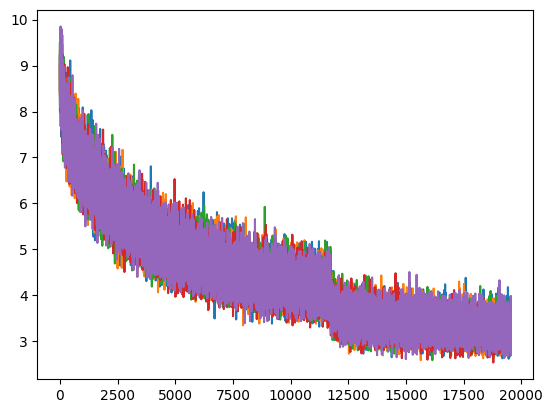

In [12]:
# Hyper parameters
# a = 0.5
# a = 0.0
a = 0.25
# temperature = 1.0
# temperature = 2.0
temperature = 4.0
# temperature = 8.0


# Create a new instance
student = Student1()

# Print the model architecture
print("Model Architecture:")
summary(student, input_size = (3, 32, 32))

# Teacher 
teacher = resnet32x4(num_classes = 100)
ckpt = torch.load("resnet32x4_vanilla/resnet32x4_best.pth", map_location = torch.device('cpu'), weights_only = False)
teacher.load_state_dict(ckpt['model'])
summary(teacher, input_size = (3, 32, 32))


# Lists to store metrics from each run
all_runs_test_accuracies_KD = []
all_runs_test_aucs_KD = []

for run in range(num_runs):
    print(f"\n--- Run {run + 1}/{num_runs} ---")
    
    # Create a new instance of the CNN model for each run
    student = Student1()
    
    # Print the model architecture
    print("Model Architecture:")
    summary(student, input_size = (3, 32, 32))

    optimizer = optim.SGD(student.parameters(), lr = lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, 30, 0.2)

    # Training_after_KD
    run_losses = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        epoch_losses = training_with_teacher(train_loader, student, teacher, criterion, optimizer, a, temperature, device)
        run_losses += epoch_losses
        scheduler.step()

    plt.plot(run_losses)

    # Save the trained model for the current run
    model_save_path = f"models/with_teaching/student_run_{run + 1}.pth"
    torch.save(student.state_dict(), model_save_path)
    print(f"Model for run {run + 1} saved to {model_save_path}")
    torch.save(run_losses, f"results/with_teaching/student_losses_run_{run + 1}.pth")

    # Testing_after_KD
    current_run_accuracy_KD, current_run_auc_KD = testing(test_loader, student, num_classes)
    
    all_runs_test_accuracies_KD.append(current_run_accuracy_KD)
    all_runs_test_aucs_KD.append(current_run_auc_KD)

    print(f"Run {run + 1} Test Accuracy: {current_run_accuracy_KD:.2f}%")
    print(f"Run {run + 1} Test AUC: {current_run_auc_KD:.4f}")

    # Add a separator for clarity between runs
    print("-" * 50)
    
print("\nAll runs completed.")

In [13]:
# --- Calculate and print average test metrics across all runs ---
print("\n--- Average Test Metrics Across All Runs ---")

avg_test_accuracy_KD = np.nanmean(all_runs_test_accuracies_KD) # Use nanmean to ignore NaNs if any occurred
std_test_accuracy_KD = np.std(all_runs_test_accuracies_KD)
avg_test_auc_KD = np.nanmean(all_runs_test_aucs_KD)

print(f"Average Test Accuracy over {num_runs} runs: {avg_test_accuracy_KD:.2f}%")
print(f"Standard deviation of Test Accuracy over {num_runs} runs: {std_test_accuracy_KD:.2f}%")
print(f"Average Test AUC (One-vs-Rest Macro) over {num_runs} runs: {avg_test_auc_KD:.4f}")


--- Average Test Metrics Across All Runs ---
Average Test Accuracy over 5 runs: 56.39%
Standard deviation of Test Accuracy over 5 runs: 0.46%
Average Test AUC (One-vs-Rest Macro) over 5 runs: 0.9711


In [14]:
all_runs_test_accuracies

[54.04, 53.559999999999995, 53.14, 53.32, 54.52]

In [15]:
all_runs_test_accuracies_KD

[56.25, 55.58, 56.89999999999999, 56.730000000000004, 56.489999999999995]

In [ ]:
acc_teach, auc_teach = testing(test_loader, teacher, num_classes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:48<00:00,  1.38s/it]


In [ ]:
test
logits = teacher() # Shape: (batch_size, num_class)
pred = torch.argmax(logits, dim = 1)